# Section I: Project Overview

## Project Description:

Household formation is generally recognized as an important driver of economic growth, prosperity, and human flourisihing. But what does it mean to be a household? Households composition varies, ranging from nuclear families, to roommates arrangements, to extended kinship situations, etc. This analysis examines household composition, and the relationship of household composition to markers of prosperity, by country and over time. In essence, this project aims to answer the question, "What types of household configurations predict happy lives?"

A number of proxies for "happy" are considered. Initially, HDI (Human Development Index) is chosen as a proxy, but this causes indirect data leakage with many features, which are meaningful and informative-features which should not be discarded. To mitigate this, Gini Index was selected as an alternative target, preserving key features while stopping the leakage.

The dataset is both sparse and high dimensional, presenting challenges to handling missing values without significant information loss. Reconstructing incomplete data can increase bias, noise, and multicollinearity. To address this, I deploy three different strategies for data imputation: (A) Interpolation, (B) Iterative Imputation, and (C) Matrix Decomposition. I fit models on the resulting reconstructed data, and compare model performance and feature importance.

**Finally, I create a weighted Gini index, to reduce the influence of high-equality low-GDP countries in the target. Equality in a populace is not the best measure of human flourishing, if the people in question are equally poor.**


## Data Sources:

Four (4) distinct data tables are used in this analysis:

The core data table is the "CoResidence Database", which was assembled by researchers at the University of Barcelona, for the EU Open Research Repository (pilot). Researchers compiled information about household configurations over time, from 1964-2023, both nationally and subnationally.

Additional data tables were merged with core features.

Data sets are described below:


### 1) Table 1: CoResidence National Database
**The CORESIDENCE Database: National and Subnational Data on Household and Living Arrangements Around the World, 1964-2021**

The CoResidence database is the core table used in this analysis. Only national data is used. National table consists of 809 entries and 178 features (1 out of 179 was a metadata tag and was dropped). 156 countries are represented, but not all countries have data available for every year in the time series range.

What I refer to as "core features" in the dataset are the features that describe household composition. Population and economic development data features are also included.

A metadata table Codebook deciphers the CoResidence column names, which are all encoded. The column 'Sub_family' in the Codebook table denotes four categories of core features:

1) Household headship (HH)
2) Size and age composition (HS)
3) Relationship to head (HR)
4) Household typology (HT)

More detail about each sub family can be found in Section II.

**Citation**: Esteve, A., Galeano, J., Turu, A., García-Román, J., Becca, F., Fang, H., Pohl, M. L. C., & Trias Prat, R. (2023).  Zenodo. https://doi.org/10.5281/zenodo.8142652

### 2) Merge I - The Gini Index 

The Gini Index measures the extent to which the distribution of income (or, in some cases, consumption expenditure) among individuals or households within an economy deviates from a perfectly equal distribution. Gini values range from 0 to 100. 

A Lorenz curve plots the cumulative percentages of total income received against the cumulative number of recipients, starting with the poorest individual or household. The Gini Index measures the area between the Lorenz curve and a hypothetical line of absolute equality, expressed as a percentage of the maximum area under the line. Thus a Gini index of 0 represents perfect equality (the 1:1 line), while an index of 100 implies perfect inequality (L-shape).

**Citation**: World Bank, Poverty and Inequality Platform. Data are based on primary household survey data obtained from government statistical agencies and World Bank country departments. Data for high-income economies are mostly from the Luxembourg Income Study database. For more information and methodology, please see pip.worldbank.org. 

https://data.worldbank.org/indicator/SI.POV.GINI

### 3) Merge II - UNPD Most Used

United Nations Population Division "Most Used" Table consists of most commonly used indicators pertaining to the populations of all countries.

https://population.un.org/wpp/Download/Standard/MostUsed/

Copyright © 2024 by United Nations, made available under a Creative Commons license CC BY 3.0 IGO: http://creativecommons.org/licenses/by/3.0/igo/ Suggested citation: United Nations, Department of Economic and Social Affairs, Population Division (2024). World Population Prospects 2024, Online Edition.


### 4) Merge III - UNDP

United Nations Development Programme. Table consists of all composite indices of the HDI (Human Development Index).

Citation not found. Data can be found at division website: https://hdr.undp.org/data-center/documentation-and-downloads


## Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


# Feature Selection
from sklearn.feature_selection import mutual_info_regression

# Model Selection
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score

# Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Linear Model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Word Matching
from thefuzz import process, fuzz

# Data Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.decomposition import TruncatedSVD, NMF

# Tree Estimators
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler



## Formulas and Persistent Data Storage

In [2]:
# initiate a list all_results to store model results across use of tscv_loop

all_results = []


In [3]:
# Write a formula to streamline this modelling loop

def tscv_loop(X, y, dataset, n_splits, models=None, scaling=True):
    """ 
    Runs cross validation on a time series split and evaluates models. Data must be sorted by time units.
    
    Parameters: 
    - X (DataFrame): Feature matrix
    - y (Series): Target variable
    - dataset (str): Name of dataset
    - n_splits (Integer): (TimeSeriesSplit number of splits)
    - models (dict): Dictionary of model names and initialized models. Defaults to Lasso, Ridge, and Random Forest
    - alpha (float): Value for Lasso alpha, default is 0.1
    - scaling (boolean): Apply scaling to data for certain models. If "False" skips scaling step.
    - n_components (int): Number of components for 
    
    Returns: 
    - DataFrame: Train/Test scores for each time series fold, for each model. 
    * For scale-sensitive models, StandardScaler is used on X
    - Dictionary: A dictionary of model names and trained models, which have the .feature_importances_ attribute
    * Dictionary will only contain feature importances for the last and final Fold 
    
    """
    
    if models is None:
        models = {
            "Linear Regression" : LinearRegression(),
            "Lasso" : Lasso(alpha=0.001),
            "Ridge" : Ridge(alpha=0.1),
            "Random Forest" : RandomForestRegressor(random_state=21)
                 }
        
    if scaling:
        scaler = StandardScaler()
    
    tscv = TimeSeriesSplit(n_splits = n_splits)
    
    for model_name, model in models.items():
        if scaling and isinstance(model, (Lasso, Ridge)):
            print(f"Model {model_name} requires scaling. Standard Scaler applied.")
            alpha_value = model.alpha if isinstance(model, Lasso) else model.alpha
            print(f"Model {model_name} alpha is {alpha_value}")
            X_scaled = scaler.fit_transform(X)
            X_used = X_scaled
        else:
            X_used = X
    
    for i, (train_index, test_index) in enumerate(tscv.split(X_used)):
        X_train, y_train = X_used.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X_used.iloc[test_index], y.iloc[test_index]
        
        trained_models ={}
        
        fold_scores = {
            "Fold":i+1,
            "Dataset":dataset
        }
    
        for model_name, model in models.items():
            model = model.fit(X_train, y_train)
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)
        
            fold_scores[f"{model_name} Train Score"] = train_score
            fold_scores[f"{model_name} Test Score"] = test_score
            
            if hasattr(model, 'feature_importances_'):
                trained_models['Dataset'] = dataset
                trained_models[model_name] = model
        
        all_results.append(fold_scores)
    
    return pd.DataFrame(all_results).drop_duplicates(subset=['Dataset', 'Fold']), trained_models

# Section II: Data Validation

## Table 1: Core Table and Metadata: 

CoResidence (df) and metadata table Codebook (code_dict)

Only "National" data has been used in this analysis. For validation purposes, sub-national data is examined. For some countries, national data appears to be mean of sub-national data, per year; whereas other countries have national data that is not a simple mean of subnational data. Sub-national year range is smaller or equal to the range represented in national data. In other words, sub-national data is equally or less comprehensive in terms of timeseries range.

Original shape of National dataset: (809, 179)

Feature groups:
- Core features describe household configuration and are in columns whose names start with 'H' ('HH', 'HS', 'HT', 'HR')
- Supplemental features pertaining to population or economy are in columns whose names start in 'D' or 'P'
- Place and Timeseries column names start with C (Country Name, Country Code) or T (Year)

Null values are distributed throughout, but mostly found outside of core features columns. 
- 91 columns out of 179 contain null values. Most of these missing values are not in core features
- Four rows (218, 219, 427, 428), which contain large sections of missing values in core features were b/ffilled
- All other missing values pertain to HT (household typology) group
- Columns HT18 and HT31 contain 530 null values converted to zero based on context (see II.3)
- All 809 rows contain at least one null value

Core features consist of two types: Proportions and Averages. For the most part, proportion categories belong to groups of columns, which sum to 1. Some proportion features are absolute proportions, as they are not part of any set of columns that adds to 1.

In [4]:
# Read in National Coresidence Dataset

df = pd.read_csv("./A0_CORESIDENCE_NATIONAL_DATASET_2024.csv",
                index_col='Unnamed: 0')

In [5]:
# Inspect table
df.head()

,C0,C1,C2,C3,C4,T1,T2,T3,T5,T10,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,DB
1,AF,AFG,Afghanistan,ASIA,Southern Asia,2015,2010,1,2011,2010,...,2101.589319,0.364833,7.791942,1.272154,681.131699,0.542189,12.44832,3.015346,3489.646939,NATIONAL
2,AO,AGO,Angola,AFRICA,Middle Africa,2015,2010,1,2011,2010,...,7652.656486,0.549279,10.690100,3.657993,6626.812049,0.614968,12.70450,5.922784,8705.839878,NATIONAL
3,AL,ALB,Albania,EUROPE,Southern Europe,2008,2010,0,2006,2000,...,9962.442236,0.715264,12.348200,8.771930,7208.741202,0.753432,11.90664,9.836990,12720.559540,NATIONAL
4,AL,ALB,Albania,EUROPE,Southern Europe,2017,2020,1,2016,2010,...,12802.148310,0.797816,15.511230,11.122311,10148.612870,0.805385,14.17994,10.721275,15442.824030,NATIONAL
5,AR,ARG,Argentina,LATIN-AMERICA,South America,1970,1970,0,1966,1960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL


In [6]:
# inspect C3 regions
df['C3'].value_counts()

AFRICA           241
EUROPE           212
ASIA             167
LATIN-AMERICA    144
OCEANIA           32
NORTH-AMERICA     11
Eastern Asia       2
Name: C3, dtype: int64

In [7]:
# Read in dataset metadata to interpret column names of coresidence
code_dict = pd.read_csv('./CODEBOOK_2024.csv', usecols=['Code', 'Sub_family', 'Description'])

# Cols excluded contain uni-value tags not needed in this analysis

In [8]:
# Read in Sub-National Coresidence Dataset

subnat_df = pd.read_csv("./A1_CORESIDENCE_SUBNATIONAL_DATASET.csv"
                      )

In [9]:
# What kind of year ranges are represented in subnational data vs. national data

subnat_range = (subnat_df
                .groupby('C1', group_keys=False)['T1']
                .apply(lambda x: max(x)-min(x))
                .sort_values(ascending=False))

nat_range = (df
             .groupby('C1', group_keys=False)['T1']
             .apply(lambda x: max(x)-min(x))
             .sort_values(ascending=False))

range_comp = pd.concat((subnat_range, nat_range), axis=1)
range_comp.columns = ['Sub National', 'National']
range_comp['Diff'] = range_comp['Sub National'] - range_comp['National']
range_comp['Diff'].value_counts().sort_index()

# National data has same or larger range than sub-national

-30.0      1
-25.0      1
-24.0      1
-21.0      1
-20.0      2
-15.0      2
-12.0      1
-11.0      1
-10.0      4
-8.0       1
-6.0       2
-5.0       5
-2.0       1
 0.0     127
Name: Diff, dtype: int64

In [10]:
# Check for inf values, which appear later. Will fix in HT section (II. 3)
inf_mask = df.applymap(lambda x: x==np.inf or x==-np.inf)
inf_mask_filter = df.loc[inf_mask.any(axis=1),inf_mask.any(axis=0)]
inf_mask_filter

,HT16,HT18,HT31
79,3.594203,inf,inf
325,inf,NaN,NaN
547,3.169451,inf,inf
569,4.687744,inf,inf
758,2.451415,inf,inf


In [11]:
# Typo discovered in column name. "Fertily" should be Fertility
code_dict.loc[code_dict['Description'].str.startswith(('f','F')), :]

,Sub_family,Code,Description
149,NaN,T5,Five years
164,NaN,P3,Fertily rate


In [12]:
# Replace 'Fertily' with 'Fertility'

code_dict['Description'] = code_dict['Description'].replace('Fertily rate', 'Fertility rate')

In [13]:
# Check to see if replace worked:

code_dict.loc[code_dict['Description'].str.startswith(('F', 'f')), :]

,Sub_family,Code,Description
149,NaN,T5,Five years
164,NaN,P3,Fertility rate


### Core Features (H Columns)

In [14]:
# Inspect core feature categories from metadata table
print('Feature Categories')
print(code_dict['Sub_family'].value_counts())
print(f"Number of Household Features: {code_dict['Sub_family'].value_counts().sum()}")

# All core feature categories begin with H and have a secondary letter code shown in the table below

Feature Categories
Household headship (H)          56
Size and age composition (S)    30
Relationship to head (R)        30
Household typology (T)          30
Name: Sub_family, dtype: int64
Number of Household Features: 146


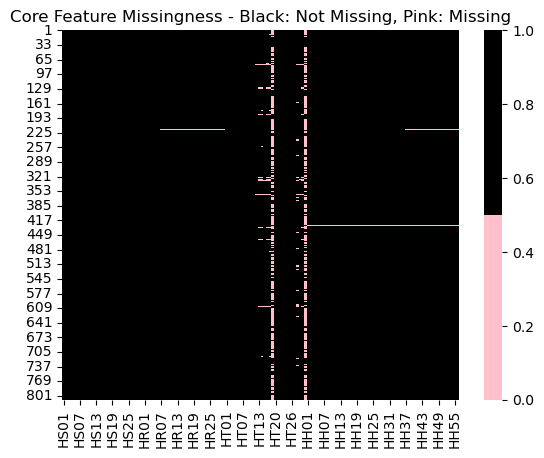

In [15]:
# Inspect where core features have null values

core_features = df.loc[:, df.columns.str.startswith('H')]
core_features_null_mask = core_features.notnull()

sns.heatmap(core_features_null_mask, cmap=['Pink', 'Black'])
plt.title("Core Feature Missingness - Black: Not Missing, Pink: Missing")
plt.show()

# Most null values are in HT18 and HT31. Potentially these are zero values and not null values.

#### 1) Household Headship (HH)

The household headship sub family of features describes household headship in two ways, **proportions and averages** both of which are bifurcated by sex.
- Proportions of households by size and type, separated by male and female 
- Averages of household size and type, separated by male and female

Male/Female-Headed are relative proportion columns, which add up to 1 (null values back filled and forward filled within respective country groups in rows 218, 219, 427, 428)

First column ('HH01') Proportion Male-Headed 
Second column ('HH02') Proportion Female-Headed ('HH01':'HH02' sum to one)

(I) Two main proportion vectors, bifurcated by male/female-headed are as follows:

**Vector a** Size of Household (relative proportions sum to one)
1) One person household (proportion male/female head of household)
2) Two person household ""
3) Three person household ""
4) Four person household ""
5) Five person household ""
6) Six person household ""
7) Seven person household ""
8) Eight person household ""
9) Nine person household ""
10) Ten person household ""
11) 11+ person household ""

- Proportion male headed columns: 'HH03':'HH13' (11 columns).
- Proportion female headed columns: 'HH14':'HH24' (11 columns).

**Vector b** Type of Household
1) Unipersonal (proportion male/female head of household)
2) Nuclear relationships to head
3) Stem-family relationships to head
4) Other family relationships to head
5) Non-family relationships to head
5) Other (residual)

- Proportion male headed columns: 'HH25':'HH30' (5 columns).
- Proportion female headed columns: 'HH31':'HH36' (5 columns).

(II) The averages vector is bifurcated by male-headed or female headed:

**Vector c** Size or Type
1) Average household size (in female/male headed household)
2) Average number of children (in female/male headed household)
2) "" of adults
3) "" spouses
4) "" persons 65+
5) "" childs
6) "" other relatives
7) "" other non-relatives
8) "" male adults
9) "" female adults

Columns are odd/even, male/female respectively, for the above group 'HH37':'HH56' (10 male, 10 female).

Note: In exactly 773 rows, sum-to-one proportion vector columns in fact sum to one. In 36 rows, this sum fails. I inspected the indices for the 36 rows with summation failure, and the indices are not the same for all groups. Based on this pattern, I suspect that there were data merge errors in the original data, where an aggregate of 36 items were not propertly normalized. I corrected this by normalizing the rows where summation fails, such that they add to one.

In [16]:
# Inspect feature categories: Sub Family - Household Headship

with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(code_dict.loc[code_dict['Sub_family'].str.contains('headship', na=False),['Description', 'Code']].values))
    
    

,0,1
0,Proportion of male-headed households,HH01
1,Proportion of female-headed households,HH02
2,Proportion of 1-person households of male-headed households,HH03
3,Proportion of 2-persons households of male-headed households,HH04
4,Proportion of 3-persons households of male-headed households,HH05
5,Proportion of 4-persons households of male-headed households,HH06
6,Proportion of 5-persons households of male-headed households,HH07
7,Proportion of 6-persons households of male-headed households,HH08
8,Proportion of 7-persons households of male-headed households,HH09
9,Proportion of 8-persons households of male-headed households,HH10


In [17]:
# Do male/female add up to 1 in all proportion categories?

print(f"Number of rows male/female headship whose sum is 1.0: {np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0).sum()}")


print(f"Number of male-headed 1-11+ person hh whose sum is 1.0: {np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed 1-11+ person hh whose sum is 1.0: {np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0).sum()}")

print(f"Number of male-headed by type hh whose sum is 1.0: {np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed by type hh whose sum is 1.0: {np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0).sum()}")

# I don't think it's a coincidence that proportion categories appear to sum to 1.0 across exact number of rows
# This may be indicative of a previous merge error in the data


Number of rows male/female headship whose sum is 1.0: 773
Number of male-headed 1-11+ person hh whose sum is 1.0: 773
Number of female-headed 1-11+ person hh whose sum is 1.0: 773
Number of male-headed by type hh whose sum is 1.0: 773
Number of female-headed by type hh whose sum is 1.0: 773


In [18]:
# Inspect rows where sum does not add up

print(f"Number of rows male/female headship whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0)).sum()}")


print(f"Number of male-headed 1-11+ person hh whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0)).sum()}")
print(f"Number of female-headed 1-11+ person hh whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0)).sum()}")

print(f"Number of male-headed by type hh whose sume is ~1.0: {(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0)).sum()}")
print(f"Number of female-headed by type hh whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0)).sum()}")



Number of rows male/female headship whose sum is ~1.0: 36
Number of male-headed 1-11+ person hh whose sum is ~1.0: 36
Number of female-headed 1-11+ person hh whose sum is ~1.0: 36
Number of male-headed by type hh whose sume is ~1.0: 36
Number of female-headed by type hh whose sum is ~1.0: 36


In [19]:
# Inspect index of proportion row groups that have summation failures within household headship groups

print("Male or Female Head of Household - HH01:HH02")
print(f"{df[(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0))].index}")

print("Male Head: 1-11+ person household - HH03:HH13")
print(f"{df[(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0))].index}")

print("Female Head: 1-11+ person household - HH14:HH24")
print(f"{df[(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0))].index}")

print("Male Head by type: uni, nuclear, stem, family, non, other - HH25:HH30")
print(f"{df[(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0))].index}")

print("Female Head by type: uni, nuclear, stem, family, non, other - HH31:HH36")
print(f"{df[(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0))].index}")

# No consistency across all groups that fail to sum. Male and female groups have same failure indexes

Male or Female Head of Household - HH01:HH02
Int64Index([  5,  12,  59,  71, 138, 156, 187, 206, 275, 298, 316, 317, 350,
            351, 357, 391, 407, 428, 443, 469, 471, 516, 528, 529, 541, 542,
            543, 546, 650, 691, 704, 719, 745, 751, 789, 797],
           dtype='int64')
Male Head: 1-11+ person household - HH03:HH13
Int64Index([ 32,  33,  49,  73, 108, 117, 118, 123, 128, 147, 172, 185, 187,
            202, 220, 226, 260, 277, 298, 313, 314, 352, 363, 365, 383, 388,
            425, 428, 480, 532, 539, 624, 662, 692, 696, 798],
           dtype='int64')
Female Head: 1-11+ person household - HH14:HH24
Int64Index([ 16,  21,  23,  24,  28,  30,  31, 108, 117, 118, 123, 128, 147,
            185, 202, 220, 226, 260, 298, 313, 350, 352, 363, 365, 388, 428,
            480, 519, 532, 539, 558, 624, 696, 746, 798, 801],
           dtype='int64')
Male Head by type: uni, nuclear, stem, family, non, other - HH25:HH30
Int64Index([ 32,  33,  49,  73, 108, 117, 118, 123, 128, 147, 

In [20]:
# Check for null values in HH group

df[df.loc[:,df.columns.str.startswith('HH')].isnull().any(axis=1)]



,C0,C1,C2,C3,C4,T1,T2,T3,T5,T10,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,DB
218,ES,ESP,Spain,EUROPE,Southern Europe,2010,2010,0,2006,2000,...,37173.68190,0.857565,16.746531,9.12660,28285.62443,0.874665,15.934190,9.61129,46273.56322,NATIONAL
219,ES,ESP,Spain,EUROPE,Southern Europe,2015,2010,0,2011,2010,...,37383.58643,0.879667,17.780121,9.77008,29466.57168,0.896751,17.179159,10.06324,45581.24946,NATIONAL
427,KR,KOR,South Korea,ASIA,Eastern Asia,1975,1970,0,1971,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL
428,KR,KOR,South Korea,ASIA,Eastern Asia,1980,1980,0,1976,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL


In [21]:
# Inspect surrounding columns to determine if backfill frontfill will work

pd.concat([df.loc[217:220,df.columns.str.startswith(('HH','C','T'))], df.loc[426:429,df.columns.str.startswith(('HH','C','T'))]])


# Surrounding values are populated. Good to frontfill and backfill. 
# Other null values in d columns are fine to ffill and backfill as well

,C0,C1,C2,C3,C4,T1,T2,T3,T5,T10,...,HH47,HH48,HH49,HH50,HH51,HH52,HH53,HH54,HH55,HH56
217,ES,ESP,Spain,EUROPE,Southern Europe,2005,2000,0,2001,2000,...,0.986817,0.740554,0.152802,0.191842,0.026344,0.028865,1.298277,0.660922,1.055987,1.256585
218,ES,ESP,Spain,EUROPE,Southern Europe,2010,2010,0,2006,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,ES,ESP,Spain,EUROPE,Southern Europe,2015,2010,0,2011,2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,ES,ESP,Spain,EUROPE,Southern Europe,2021,2020,1,2021,2020,...,0.670334,0.684711,0.173197,0.162967,0.032843,0.018399,1.224752,0.703103,0.886900,1.233258
426,KR,KOR,South Korea,ASIA,Eastern Asia,1970,1970,0,1966,1960,...,3.035974,2.272008,0.441491,0.357978,0.163010,0.213377,1.371856,0.394773,1.416338,1.503439
427,KR,KOR,South Korea,ASIA,Eastern Asia,1975,1970,0,1971,1970,...,2.792896,1.820398,0.412999,0.263917,0.097577,0.116315,NaN,NaN,NaN,NaN
428,KR,KOR,South Korea,ASIA,Eastern Asia,1980,1980,0,1976,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,KR,KOR,South Korea,ASIA,Eastern Asia,1985,1980,0,1981,1980,...,1.981509,1.204044,0.369165,0.367252,0.073454,0.153066,1.366772,0.422406,1.314438,1.443553


In [22]:
# ffill and bfill missing values in hh

df.loc[217:429,:] = df.loc[217:429,:].ffill().bfill()

In [23]:
# Check for null values again after backfilling and forward filling


df.loc[:, df.columns.str.startswith('H')].isnull().sum().sort_values(ascending=False).head(12)

HT31    394
HT18    394
HT17     26
HT28     25
HT14     22
HT16     20
HT13     19
HT30     17
HT29      4
HT15      3
HT12      2
HH51      0
dtype: int64

In [24]:
# Inspect columns where proportion figures do not add up to 1

normalize_groups = [df[(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1),1.0))]
                   ]


In [25]:
# create row index for normalization using the rows identified in normalize_groups

target_cols_row_index = set()
for group in normalize_groups:
    for x in group.index:
        target_cols_row_index.add(x)
        
#target_cols_row_index

In [26]:
# Normalize values in each group

normalize_groups = [df.loc[:,'HH01':'HH02'], 
                    df.loc[:,'HH03':'HH13'], 
                    df.loc[:,'HH14':'HH24'], 
                    df.loc[:,'HH25':'HH30'], 
                    df.loc[:,'HH31':'HH36']
                   ]

for row in target_cols_row_index:
    for group in normalize_groups:
        columns = group.columns
        denominator = df.loc[row, columns].sum()
        df.loc[row, columns] = df.loc[row, columns].apply(lambda x: x/denominator)

In [27]:
# Verify that normalization worked by printing any rows that fail to add up to 1

print("Male or Female Head of Household:")
print(f"{df[(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0))].index}")

print("Male Head: 1-11+ person household")
print(f"{df[(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0))].index}")

print("Female Head: 1-11+ person household")
print(f"{df[(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0))].index}")

print("Male Head by type: uni, nuclear, stem, family, non, other")
print(f"{df[(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0))].index}")

print("Female Head by type: uni, nuclear, stem, family, non, other")
print(f"{df[(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0))].index}")



Male or Female Head of Household:
Int64Index([], dtype='int64')
Male Head: 1-11+ person household
Int64Index([], dtype='int64')
Female Head: 1-11+ person household
Int64Index([], dtype='int64')
Male Head by type: uni, nuclear, stem, family, non, other
Int64Index([], dtype='int64')
Female Head by type: uni, nuclear, stem, family, non, other
Int64Index([], dtype='int64')


In [28]:
# Double verify that normalization worked


print(f"Number of rows male/female headship whose sum is 1.0 (HH01:HH02): {np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0).sum()}")


print(f"Number of male-headed 1-11+ person hh whose sum is 1.0 (HH03:HH13): {np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed 1-11+ person hh whose sum is 1.0 (HH14:HH24): {np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0).sum()}")

print(f"Number of male-headed by type hh whose sume is 1.0 (HH25:HH30): {np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed by type hh whose sum is 1.0 (HH31:HH36): {np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0).sum()}")

# All proportion group 809 rows now add up to 1

Number of rows male/female headship whose sum is 1.0 (HH01:HH02): 809
Number of male-headed 1-11+ person hh whose sum is 1.0 (HH03:HH13): 809
Number of female-headed 1-11+ person hh whose sum is 1.0 (HH14:HH24): 809
Number of male-headed by type hh whose sume is 1.0 (HH25:HH30): 809
Number of female-headed by type hh whose sum is 1.0 (HH31:HH36): 809


In [29]:
# Check for null values in HH groups


df.loc[:,df.columns.str.startswith('HH')].isnull().any(axis=1).any()

# No null values remaining in HH sub family

False

#### 2) Size and age composition (HS)

The size and age composition sub family is split into three groups of proportions, and averages

Proportion Groups:

(I) The first 11 columns ('HS01':'HS11') are relative proportions and add up to 1

1) Proportion of 1 person households
2) "" 2 person ""
3) "" 3 person ""
4) "" 4 person ""
5) "" 5 person ""
6) "" 6 person ""
7) "" 7 person ""
8) "" 8 person ""
9) "" 9 person ""
10) "" 10 person ""
11) "" 11+ person ""

(II) The next three columns are relative proportions ('HS12':'HS14') add up to 1 when 'HS01' (1-person households) is included

1) Proportion of 2-3 person households
2) "" 4-5 person ""
3) "" 6+ person ""

(III) The last two proportion columns ('HS15','HS16') do not add up to 1, and there are no other columns that complete the sum. Thus, I make the assumption that these are absolute proportions, to be understood as Y/N with the stated value representing Y.

Average Groups (HS17:HS30):

1) 'Average household size'
2) 'Average number of 0-4 children in the household'
3) 'Average number of adults in the household (aged 18+)'
4) 'Average number of children in the household (aged < 18)'
5) 'Average number of persons aged 65+ in the household'
6) 'Average number of 0-9 individuals in the household'
7) 'Average number of 10-19 individuals in the household'
8) 'Average number of 20-29 individuals in the household'
9) 'Average number of 30-39 individuals in the household'
10) 'Average number of 40-49 individuals in the household'
11) 'Average number of 50-59 individuals in the household'
12) 'Average number of 60-69 individuals in the household'
13) 'Average number of 70-79 individuals in the household'
14) 'Average number of 80+ individuals in the household'



In [30]:
# Size and age composition

with pd.option_context('display.max_colwidth', None):
    display(code_dict.loc[code_dict['Code'].str.startswith('HS'), ['Code','Description']])


,Code,Description
0,HS01,Proportion of 1-person households
1,HS02,Proportion of 2-persons households
2,HS03,Proportion of 3-persons households
3,HS04,Proportion of 4-persons households
4,HS05,Proportion of 5-persons households
5,HS06,Proportion of 6-persons households
6,HS07,Proportion of 7-persons households
7,HS08,Proportion of 8-persons households
8,HS09,Proportion of 9-persons households
9,HS10,Proportion of 10-persons households


In [31]:
# Proportion of #-person households summation
# Columns HS01-HS11 add up to 1

np.isclose(df.loc[:,'HS01':'HS11'].sum(axis=1), 1.0).all()

True

In [32]:
# Proportion of #-# person households summation

df.loc[:,'HS12':'HS14'].sum(axis=1).sort_values()


183    0.595094
390    0.605828
462    0.607974
182    0.610392
185    0.619704
         ...   
571    0.990161
572    0.991192
195    0.993345
1      0.998565
426    0.998751
Length: 809, dtype: float64

In [33]:
# Search for stray column that adds up to 1

for col in df.select_dtypes(exclude=['object']):
    remainder_fix = df.loc[:, 'HS12':'HS14'].sum(axis=1) + df[col]
    if np.isclose(remainder_fix, 1.0).all():
        print(f'Fix column found: {col}')
    
# HT01 is the same value in Household Typology sub family

Fix column found: HS01
Fix column found: HT01
Fix column found: HT20


In [34]:
# Inspect these fix columns. It makes some sense why HS01 == HT01 == HT20
code_dict.loc[
    (code_dict['Code'] == 'HS01') | 
    (code_dict['Code'] == 'HT01') | 
    (code_dict['Code'] == 'HT20'),
    ['Code','Description']]

,Code,Description
0,HS01,Proportion of 1-person households
60,HT01,Proportion of unipersonal households
78,HT20,Proportion of unipersonal households


In [35]:
# Proportion of households with at least one person 0-4 (HS15), at least one person 65+ (HS16)

df.loc[:, 'HS15':'HS16'].sum(axis=1)

1      0.880057
2      0.734931
3      0.523940
4      0.552676
5      0.480692
         ...   
805    0.621919
806    0.649612
807    0.644526
808    0.620795
809    0.637744
Length: 809, dtype: float64

In [36]:
# Search for a stray column that may be needed to complete

for col in df.select_dtypes(exclude=['object']).columns:
    test_sum = (df.loc[:,'HS15':'HS16'].sum(axis=1) + df[col])
    if (np.isclose(test_sum, 1.0)).all():
        print(f"Stray column found: {col}")
    
# No other column adds up to 1 with HS15 and HS16
# Assumption: these are raw proportions and not meant to add up to 1

In [37]:
# no single columns completed the sum
# search for a combination of multiple columns that may be needed to complete the sum

iter_cols = df.loc[:,df.columns.str.startswith('HS')]#.select_dtypes(exclude=['object']).columns

for num_iters in range(1, 6):
    found = False
    for col_combos in itertools.combinations(iter_cols, num_iters):
        test_sum = df.loc[:,'HS15':'HS16'].sum(axis=1) + df[list(col_combos)].sum(axis=1)
        if np.isclose(test_sum, 1.0).all():
            print(f"Remainder col found: {col_combos}")
            found = True
            break
    else: 
        if not found:
            print("Remainder column/s that sum to one with HS15:HS16 not found")

# No combinations found that will complete sum for Household Size proportion stragglers

Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found


In [38]:
# Check for null values before concluding section

df.loc[:, df.columns.str.startswith('HS')].isnull().any().any()

# No null values in household size category

False

#### 3) Household Typology (HT)

The household typology sub family of features consists of two types of groupings: Proportions and Averages. 
I) Proportion groupings describe the type of household by relationship to head
II) Average size of household by relationship to head

Each of these two types of groupings has two iterations, for a total of four column groupings. 

One is more extensive, while the other contains consolidated categories. I assume that the categories are consolidated, because some of the columns across the two groupings are duplicates. Thus, I conclude that the difference between the groupings is one of consolidation.

Given the duplicates, and the downstream issues with duplicated columns (multicollinearity, convergence failures, unstable matrices), I have decided to **eliminate columns HT01 through HT18.**

Group I - Relative proportion grouping:
1) Proportion unipersonal households
2) Proportion households with nuclear relationships to head
3) "" nuclear and other family ""
4) "" nuclear and non family ""
5) "" nuclear, other family, and non family ""
6) "" non nuclear family ""
7) "" non family ""
8) "" non nuclear family and non family ""
9) "" non nuclear family and/or non family ""

**Proportion columns ('HT01':'HT09') add to one.**
**Average size of household columns, by diversified typology groups above: ('HT10':'HT18')**


Group II - Simplified proportion grouping:
1) Proportion of unipersonal households
1) Proportion of households with nuclear relationships to head
2) Proportion of stem-family households based on relationship to head
3) Proportion of other family households based on relationship to head
4) Proportion non family households based on relationship to head
5) Proportion of other relative and / or non relative households based on relationship to head (residual category)

**Proportion columns add to one ('HT20':'HT25')**
**Average size of household by type ('HT26':'HT31')

Note on null values:
HT18 and HT31 contain 394 missing values each. The two columns HT18 and HT31 are residual categories for atypical households, and null values are assumed to be zero due to residual nature. All other null values are sporadic (26 null values or less), and are found in the "averages" columns. Thus, these values are assumed to be zero as well. Therefore, all null values in HT category were replaced with zero (0).

In [39]:
# Inspect Household Typology columns

HT = pd.DataFrame(code_dict[code_dict['Sub_family'].str.contains('typology', na=False)].values)
name_mapper = {col:name for col in HT.columns for name in ["Sub Family", "Column", "Description"]}
HT = HT.rename(name_mapper, axis=1)

with pd.option_context('display.max_colwidth', None):
    display(HT)


,Description,Description,Description
0,Household typology (T),HT01,Proportion of unipersonal households
1,Household typology (T),HT02,Proportion of households with nuclear relationships to head
2,Household typology (T),HT03,Proportion of households with nuclear and other family relationships to head
3,Household typology (T),HT04,Proportion of households with nuclear and non family relationships to head
4,Household typology (T),HT05,"Proportion of households with nuclear, other family, and non family relationships to head"
5,Household typology (T),HT06,Proportion of households with non nuclear family relationships to head
6,Household typology (T),HT07,Proportion of households with non family relationships to head
7,Household typology (T),HT08,Proportion of households with non nuclear family and non family relationships to head
8,Household typology (T),HT09,Proportion of households with non nuclear family and / or non family relationships to head
9,Household typology (T),HT10,Average size of unipersonal households


In [40]:
# Household Typology - Proportion category checks. Ensure all proportions add up to 1.0

assert np.isclose(df.loc[:,'HT01': 'HT09'].sum(axis=1), 1).all(), 'Typology proportions do not add up to 1'
assert np.isclose(df.loc[:,'HT20':'HT25'].sum(axis=1), 1).all(), 'Typology proportions do not add up to 1'

In [41]:
# Check for duplicate columns

dupe_cols = df.T[df.T.duplicated(keep=False)].index
print(dupe_cols)

dupe_pairs = []

for i, col1 in enumerate(dupe_cols):
    for col2 in dupe_cols[i+1:]:
        if df[col1].equals(df[col2]):
            dupe_pairs.append((col1, col2))
            

Index(['HR01', 'HT01', 'HT02', 'HT09', 'HT10', 'HT11', 'HT18', 'HT20', 'HT21',
       'HT25', 'HT26', 'HT27', 'HT31'],
      dtype='object')


In [42]:
dupe_pairs = pd.DataFrame(dupe_pairs, columns=['set1', 'set2'])
dupe_pairs


,set1,set2
0,HR01,HT10
1,HR01,HT26
2,HT01,HT20
3,HT02,HT21
4,HT09,HT25
5,HT10,HT26
6,HT11,HT27
7,HT18,HT31


In [43]:
# Lookup descriptions corresponding to duplicate columns

dupe_pairs['set1_des'] = dupe_pairs.merge(code_dict, left_on='set1', right_on='Code', how='left')['Description']
dupe_pairs['set2_des'] = dupe_pairs.merge(code_dict, left_on='set2', right_on='Code', how='left')['Description']

with pd.option_context('display.max_colwidth', None):
    display(dupe_pairs)
    
# Duplicates are just similar columns. 

,set1,set2,set1_des,set2_des
0,HR01,HT10,Average number of heads in the household,Average size of unipersonal households
1,HR01,HT26,Average number of heads in the household,Average size of unipersonal households based on relationship to head
2,HT01,HT20,Proportion of unipersonal households,Proportion of unipersonal households
3,HT02,HT21,Proportion of households with nuclear relationships to head,Proportion of households with nuclear relationships to head
4,HT09,HT25,Proportion of households with non nuclear family and / or non family relationships to head,Proportion of other relative and / or non relative households based on relationship to head (residual category)
5,HT10,HT26,Average size of unipersonal households,Average size of unipersonal households based on relationship to head
6,HT11,HT27,Average size of households with nuclear relationships to head,Average size of nuclear households based on relationship to head
7,HT18,HT31,Average size of households with non nuclear family and / or non family relationships to head,Average size of other relative and/or non relative households based on relationship to head (residual category)


In [44]:
# HT01 to HT09:  Proportion groups add to one
np.isclose(df.loc[:,'HT01':'HT09'].sum(axis=1), 1.0).all()

True

In [45]:
# Check that proportion groupings add to one

df.loc[:, 'HT20':'HT25'].sum(axis=1).all()

# Proportion groupings add to one respectively. HT01 and HT20 are not duplicates. Each is necessary in its own grouping.

True

In [46]:
# Check null values again

df.loc[:, df.columns.str.startswith('HT')].isnull().sum().sort_values(ascending=False).head(10)

# Categories after HT10 are averages, not proportions. Assume all null values to be zero.

HT31    394
HT18    394
HT17     26
HT28     25
HT14     22
HT16     20
HT13     19
HT30     17
HT29      4
HT15      3
dtype: int64

In [47]:
# Replace null Household Typology (HT) columns with zeros

df.loc[:, df.columns.str.startswith('HT')] = df.loc[:, df.columns.str.startswith('HT')].fillna(0)

In [48]:
# Check that null values are filled

df.loc[:, df.columns.str.startswith('HT')].isnull().any().any()

False

In [49]:
# Drop HT01 through HT18

ht_cols_to_drop = df.loc[:,'HT01':'HT18'].columns

df = df.drop(columns=ht_cols_to_drop)

In [50]:
# check to ensure duplicates have been removed

dupe_cols = df.T.duplicated(keep=False)
df.columns[dupe_cols]

Index(['HR01', 'HT26'], dtype='object')

In [51]:
# Drop HT26 ('Average size of unipersonal households based on relationship to head)
# HT26 is a functional duplicate of HR01

df = df.drop('HT26', axis=1)

#### 4) Relationship to head (HR)

All features in sub family "Relationship to Head" are expressed in raw averages, in contrast to all other sub families, which contain proportional groupings. There are no proportion categories in HR, unlike the other three sub families. 

HR data consists of 30 features, which represent a cross-tabulation of the following two vectors, expressed as an average:

**Vector a** Number of heads or members by relationship to head:
1) Heads in Household (average number of heads in household of b size)
2) Spouses of head (average number of spouses in household of b size)
3) Children of head ""
4) Other relatives of head ""
5) Non-relatives of head ""
6) Other (residual category) ""

**Vector b** Number of :
1) Household (*unspecified size*)
2) 2-person household
3) 3-person household
4) 4-person household
5) 5-person household

Therefore, a total of 30 (6 groups by 5 crosstabs) columns: 'HR01' through 'HR30'. Five groups are 
1) HR01:HR06 (unspecified size)
2) HR07:HR12 (2-person hh)
3) HR13:HR18 (3-person hh)
4) HR19:HR24 (4-person hh)
5) HR25:HR30 (5-person hh)

Assumptions about the data in this sub-family include the following:

- 'HR01':'HR06' descriptions do not specify a household size. Thus 
- If the household were "unipersonal" the remaining cross-tabulations would all be be populated with 1.0 or 0.0-values, because the household by definition only contains one person (and zero others). I explored whether the unspecified household size was an average of the other size categories, but the numbers clearly did not add up to a mean. Thus, I conclude that the household size is merely unspecified in the first group of six.


In [52]:
# No proportion categories in "Relationship to head," all averages

with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(code_dict.loc[code_dict['Code'].str.startswith('HR'), ['Description', 'Code']].values))

,0,1
0,Average number of heads in the household,HR01
1,Average number of spouses of the head in the household,HR02
2,Average number of children of the head in the household,HR03
3,Average number of other relatives of the head in the household,HR04
4,Average number of non relatives of the head in the household,HR05
5,Average number of other relatives and/or non relatives of the head in the household,HR06
6,Average number of Heads in 2 persons household,HR07
7,Average number of Spouses in 2 persons household,HR08
8,Average number of Children in 2 persons household,HR09
9,Average number of Other relatives in 2 persons household,HR10


In [53]:
# Check for null values

df.loc[:,df.columns.str.startswith('HR')].isnull().any().any()

# No null values

False

[0] max is 5.258203387957618
[1] max is 0.5732398728617071
[2] max is 1.7244520260960328
[3] max is 2.772968706392554
[4] max is 3.8122783307194004


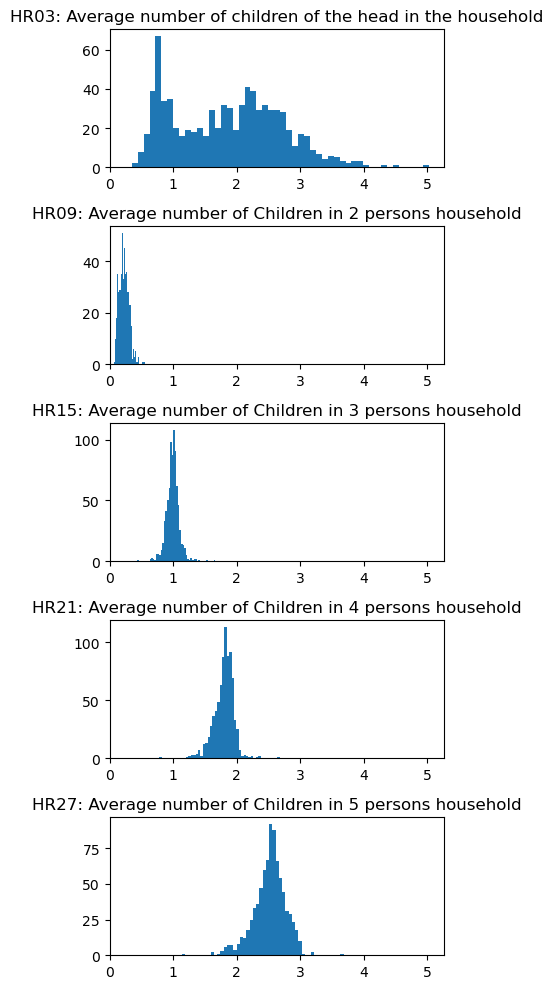

In [54]:
# Average number of children of the head in household of unspecified size
# Examine category to determine what size "unspecified" HR03 might be

fig, ax = plt.subplots(5, 1, figsize=(4,10))

for i in range(5):
        col_index = 3 + (i * 6)
        col_name = f'HR{col_index:02d}'
        ax[i].hist(df[col_name], bins=50)
        ax[i].set_title(f"{col_name}: {code_dict.loc[code_dict['Code']==col_name, 'Description'].values[0]}")

x_maxes = []

for i in range(5):
        x_maxes.append(ax[i].get_xlim()[1])
        print(f'{[i]} max is {ax[i].get_xlim()[1]}')

x_max = max(x_maxes)

for i in range(5):
        ax[i].set_xlim(0, x_max)

plt.tight_layout()

plt.show()

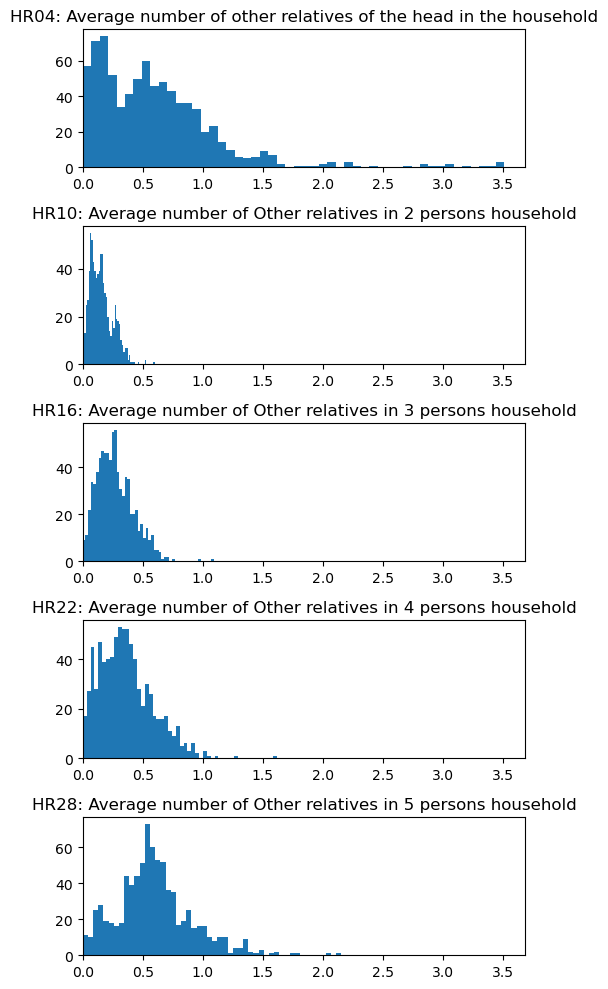

<Figure size 640x480 with 0 Axes>

In [55]:
# Average number of other relatives in household of varying size

fig, ax = plt.subplots(5, 1, figsize=(5,10))

for i in range(5):
        col_index = 4 + (i * 6)
        col_name = f'HR{col_index:02d}'
        ax[i].hist(df[col_name], bins=50)
        ax[i].set_title(f"{col_name}: {code_dict.loc[code_dict['Code']==col_name, 'Description'].values[0]}")

x_maxes = []

for i in range(5):
        x_maxes.append(ax[i].get_xlim()[1])
        #print(f'{[i]} max is {ax[i].get_xlim()[1]}')

x_max = max(x_maxes)

for i in range(5):
        ax[i].set_xlim(0, x_max)

plt.tight_layout()

plt.show()
plt.clf()

In [56]:
# Is the first set of averages (unspecified household size) an average of the other 4 sets?
# Is it the sum?

for i in range(6):
    agg_list = []
    
    target_col_index = 1 + i # construct index for columns in first grouping HR01:HR06
    target_column_name = f"HR{target_col_index:02d}"
    print(f"Target column: {target_column_name} is a mean or a sum of the following columns?")
    
    for j in range(4):
        meansum_col_index = 7+i + 6*j # skip ahead by 7 initially, plus 6*j for each iteration, to retrieve axis cols
        meansum_cols_names = f"HR{meansum_col_index:02d}"
        agg_list.append(meansum_cols_names)
        print(meansum_cols_names)
    agg_df = df[agg_list]

    mean = agg_df.mean(axis=1)
    sum_total = agg_df.sum(axis=1)
    target_col = df[target_column_name]
    
    if np.isclose(target_col, mean, atol=1e-3).all():
        print(f'{target_column_name} is the mean of {agg_list}')
    elif np.isclose(target_col, sum_total, atol=1e-3).all():
        print(f'{target_column_name} is the sum of {agg_list}')
    else:
        print('No cigar!')

# No. Unclear that it could plausibly represent 1-person households

Target column: HR01 is a mean or a sum of the following columns?
HR07
HR13
HR19
HR25
No cigar!
Target column: HR02 is a mean or a sum of the following columns?
HR08
HR14
HR20
HR26
No cigar!
Target column: HR03 is a mean or a sum of the following columns?
HR09
HR15
HR21
HR27
No cigar!
Target column: HR04 is a mean or a sum of the following columns?
HR10
HR16
HR22
HR28
No cigar!
Target column: HR05 is a mean or a sum of the following columns?
HR11
HR17
HR23
HR29
No cigar!
Target column: HR06 is a mean or a sum of the following columns?
HR12
HR18
HR24
HR30
No cigar!


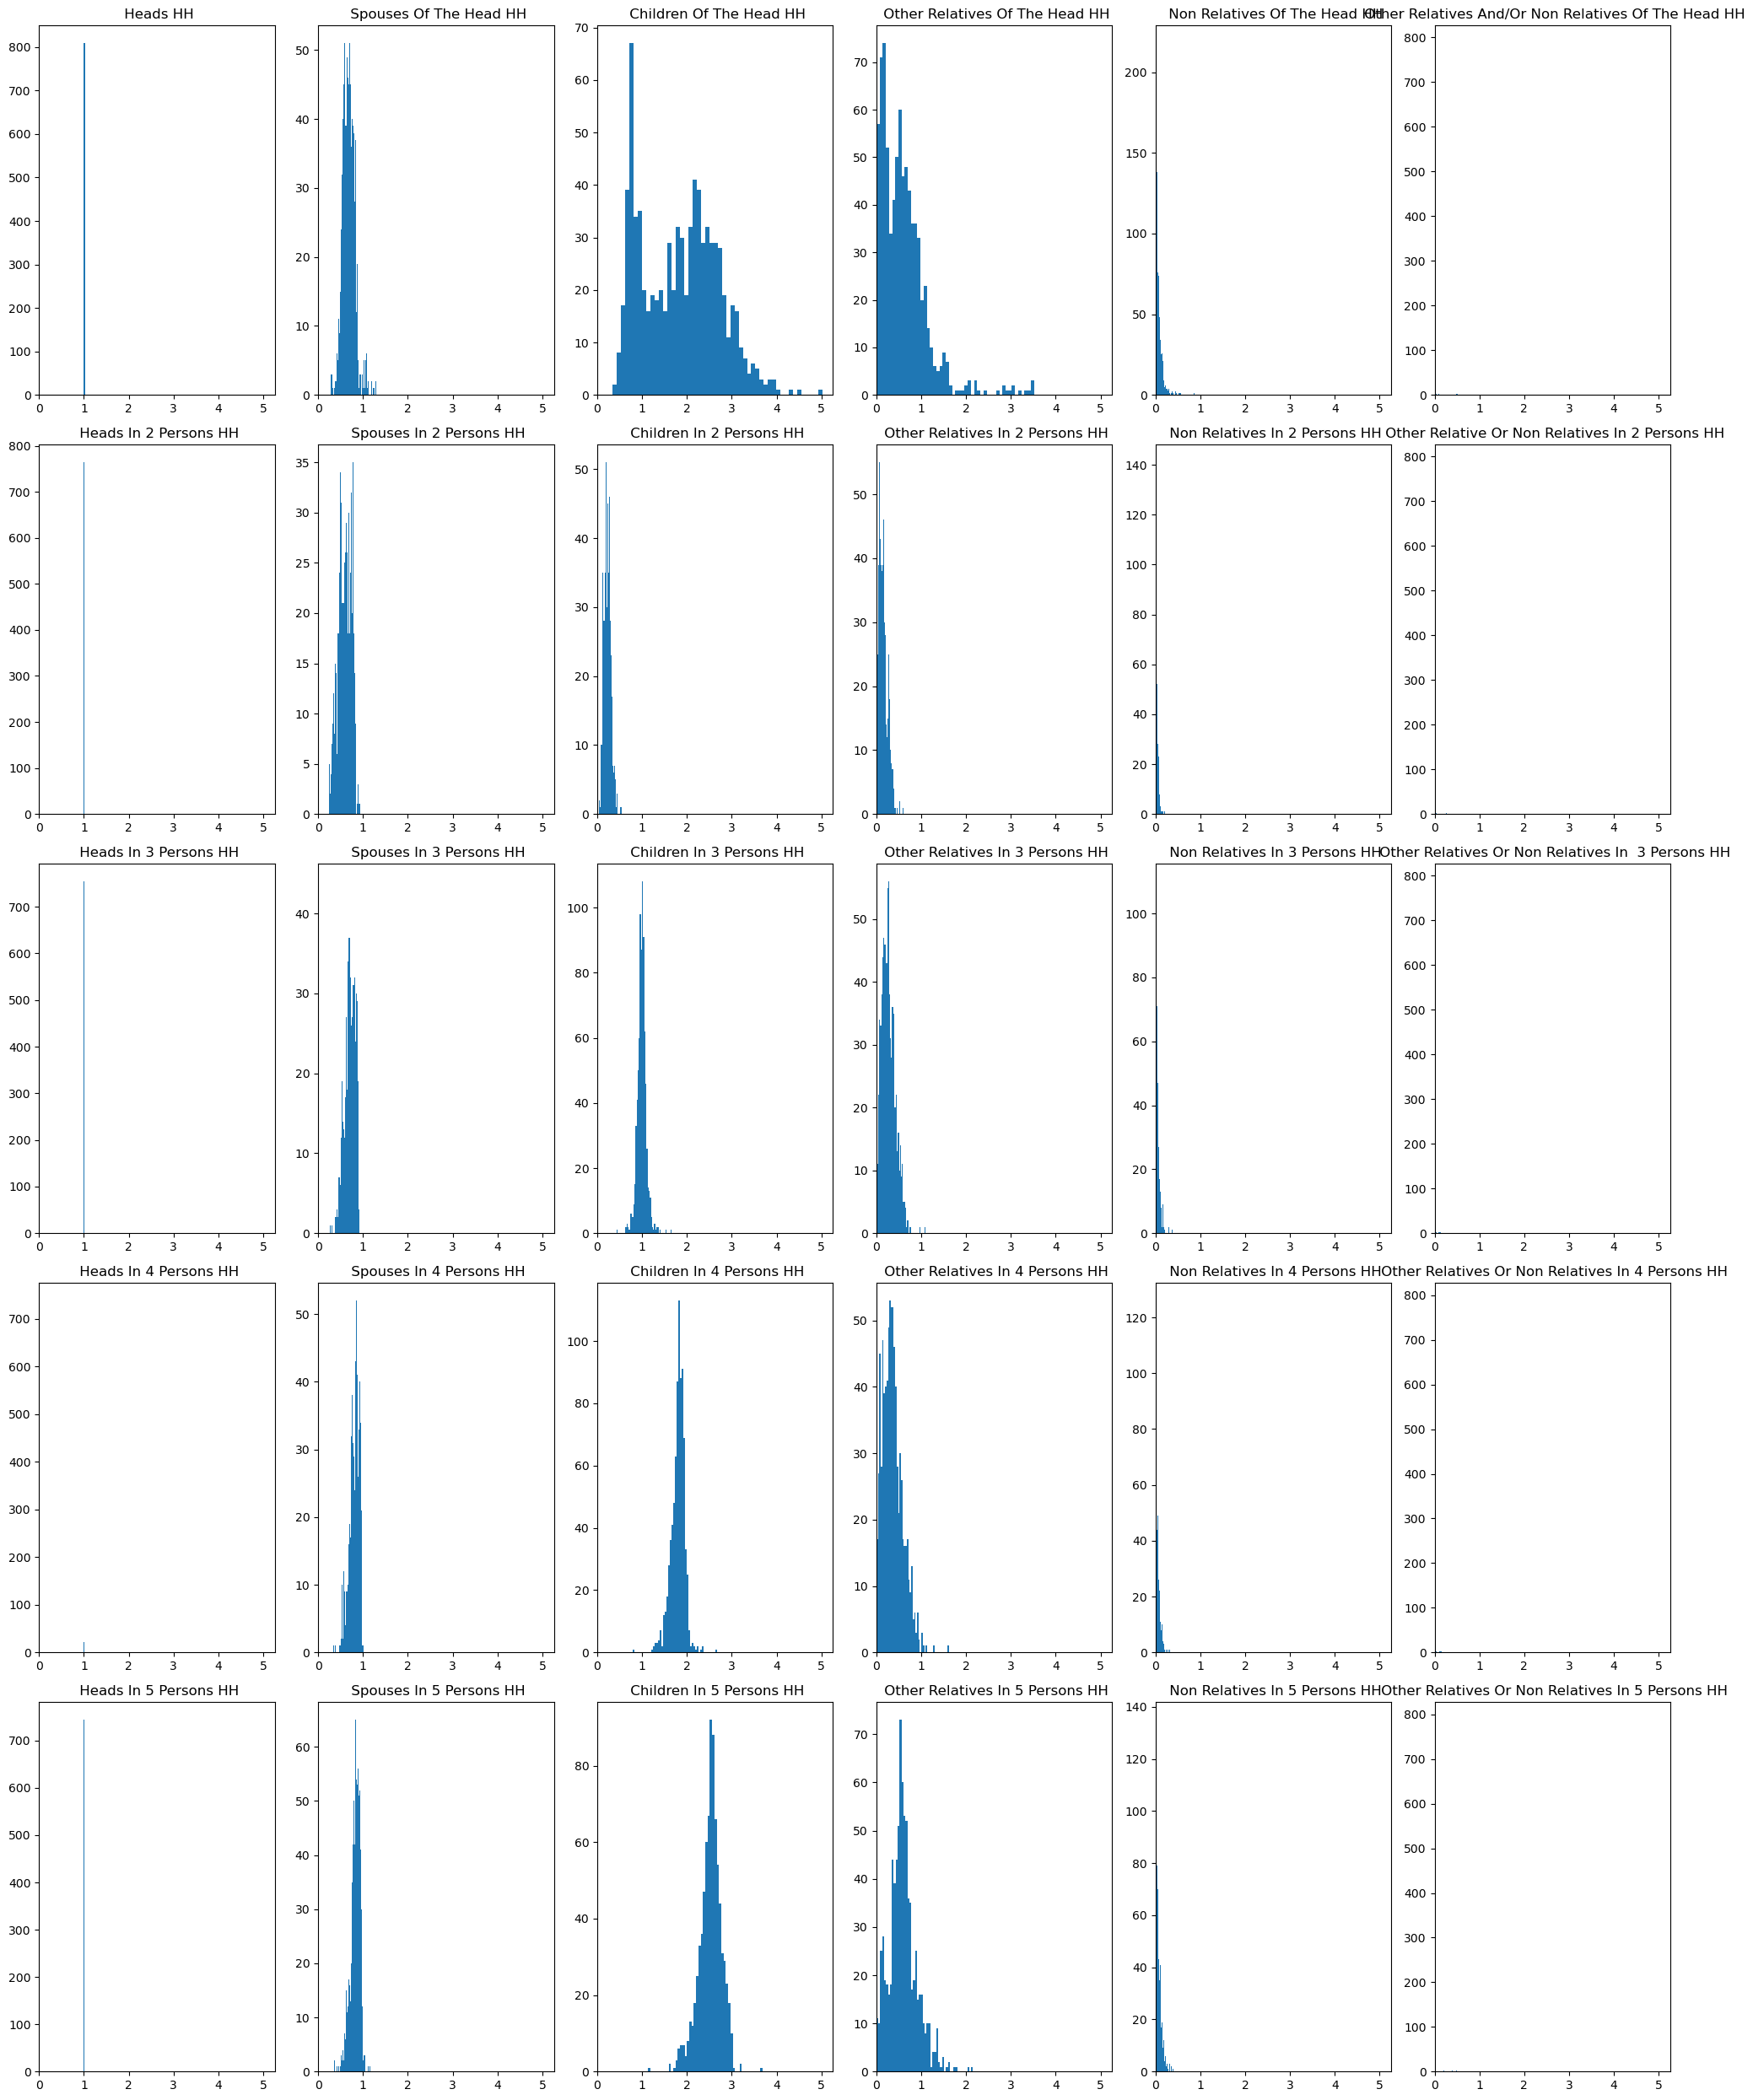

In [57]:
# Average number of people in 1-5 person household

fig, ax = plt.subplots(5, 6, figsize=(20,25))

col_index = 1

for i in range(5):
    for j in range(6):
        col_name = f'HR{col_index:02d}'
        ax[i,j].hist(df[col_name], bins=50)
        title = f"{code_dict.loc[code_dict['Code']==col_name, 'Description'].values[0]}"
        title_stripped = title.replace('Average number of','').replace('in the household', 'household')
        title_stripped = title_stripped.title().replace('Household','HH')
        ax[i,j].set_title(title_stripped)
        #print([i,j], f'{col_name} ', title_stripped)
        col_index += 1



x_maxes = []

for i in range(5):
    for j in range(6):
        x_maxes.append(ax[i,j].get_xlim()[1])
        #print(f'{[i,j]} max is {ax[i,j].get_xlim()[1]}')

x_max = max(x_maxes)

for i in range(5):
    for j in range(6):
        ax[i,j].set_xlim(0, x_max)

plt.tight_layout()
plt.show()

Some takeaways from visual analysis in HR Category:

HR category was perplexing because it contained "average number of a in b-size household." Variable "b" was not specified in the leading category of each a. Thus it was difficult to interpret whether "a[i]b[0]" was intended to be an aggregate of the remaining categories (sum or mean), or a household of unspecified size.

Based on the above analyses, the zero element of the b vector is "unspecified" size. 

In a household of unspecified size, there is always one head, an average of 2 children (most commonly 1 child, but sometimes 3 or 4), other relative of the head is more common than a spouse. About 75% of the time, there is a spouse. There is rarely (5% of the time) a non-relative inhabitant.

In [58]:
# Examine five person household numbers

five_person_hr = df.loc[:, 'HR25':'HR30'].columns.tolist()
code_dict[code_dict['Code'].apply(lambda x: x in five_person_hr)]

,Sub_family,Code,Description
54,Relationship to head (R),HR25,Average number of Heads in 5 persons household
55,Relationship to head (R),HR26,Average number of Spouses in 5 persons household
56,Relationship to head (R),HR27,Average number of Children in 5 persons household
57,Relationship to head (R),HR28,Average number of Other relatives in 5 persons...
58,Relationship to head (R),HR29,Average number of Non relatives in 5 persons h...
59,Relationship to head (R),HR30,Average number of Other relatives or Non relat...


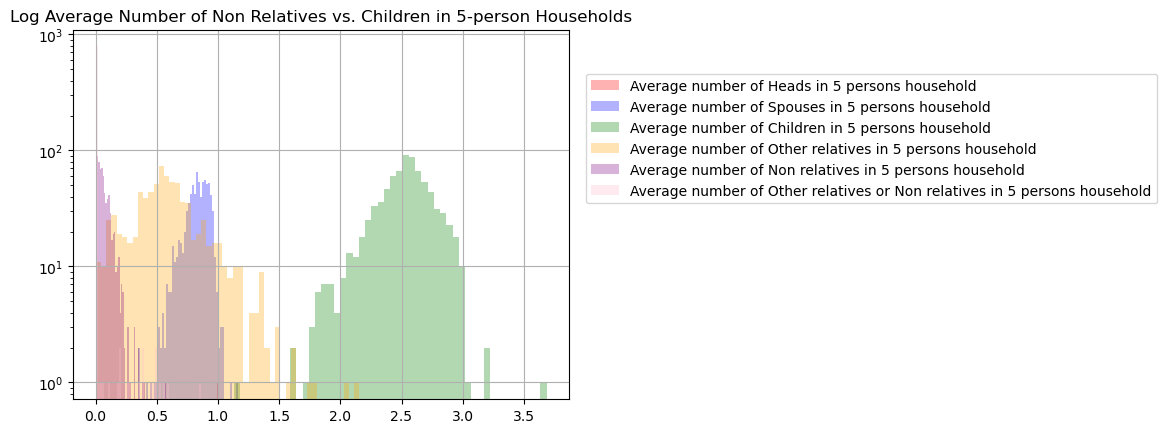

In [59]:
# Avg number of non relatives in 5 person households

colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']

for i, code in enumerate(five_person_hr):
        df[code].hist(bins=50, label=code_dict.loc[code_dict['Code']==code, 'Description'].values[0], color=colors[i], alpha = 0.3)

        plt.title('Log Average Number of Non Relatives vs. Children in 5-person Households')
        plt.legend()
        
plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(2.2,0.9))
plt.show()


### Non-Core Features (S, P, D)


In [60]:
# Create a not nulls mask to inspect nulls in non-core features
d_s_p_cols = df.loc[:,df.columns.str.startswith(('D', 'S', 'P'))]
d_s_p_nulls = d_s_p_cols[d_s_p_cols.isnull().any(axis=1)]
not_nulls_mask = d_s_p_nulls.notnull()

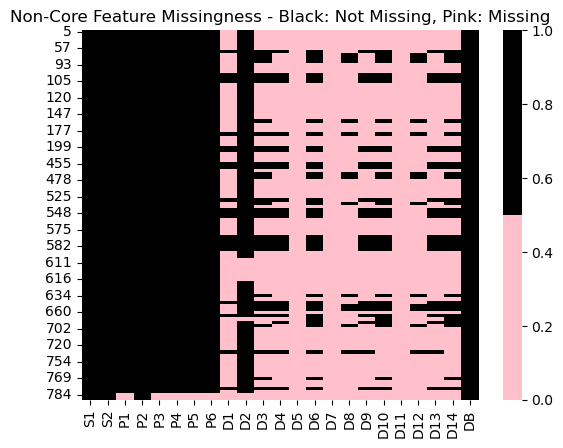

In [61]:
# Inspect columns where supplemental features have NaN values

sns.heatmap(not_nulls_mask, cmap=['Pink', 'Black'])
plt.title("Non-Core Feature Missingness - Black: Not Missing, Pink: Missing")
plt.show()

# There does not seem to be a pattern regarding null values in D columns vs. P or S columns
# Potentially need to import D values from elsewhere. All S columns will be dropped later

In [62]:
# Fetch descriptions for "C" and "D" columns
code_dict.loc[code_dict['Code'].str.startswith(('C', 'D', 'S')), ['Code', 'Description']]

,Code,Description
151,C0,Country ISO nomenclature 2 digits
152,C1,Country ISO nomenclature 3 digits
153,C2,Country
154,C3,Continent
155,C4,Sub continent
156,C5,Region
157,C6,Region Name
158,S1,Sample identification
159,S2,Data source
160,S3,Sample region identification


In [63]:
# Table contains infinite values. Testing .applymap() method to look for inf values
# Something I did to 218 and 219 created infinite values

inf_mask = df.applymap(lambda x: x==np.inf or x==-np.inf)
inf_mask_filter = df.loc[inf_mask.any(axis=1),inf_mask.any(axis=0)]
inf_mask_filter

,HT31
79,inf
547,inf
569,inf
758,inf


In [64]:
# Fill inf values with column mean

inf_index = inf_mask_filter.index

for col in inf_mask_filter.columns:
    for index in inf_index:
        if np.isinf(df.loc[index, col]):
            #print(f"Column {col}, Row {index} is inf")
            replace_num_col = df[col].replace([np.inf, -np.inf], np.nan).dropna()
            replace_col_mean = np.mean(replace_num_col)
            #print(col, replace_col_mean)
            df.loc[index, col] = np.mean(replace_num_col)


In [65]:
# Side-by-side comparison of before and after to check that find and replace worked
pd.concat([inf_mask_filter, df.loc[inf_mask.any(axis=1), inf_mask.any(axis=0)]], axis=1)

,HT31,HT31
79,inf,1.92573
547,inf,1.92573
569,inf,1.92573
758,inf,1.92573


In [66]:
# Inspect dataframe where D columns have null values

df.loc[(df.loc[:,df.columns.str.startswith('D')].isnull().any(axis=1)),:]

# Potential to fill these columns after merge with UN data


,C0,C1,C2,C3,C4,T1,T2,T3,T5,T10,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,DB
5,AR,ARG,Argentina,LATIN-AMERICA,South America,1970,1970,0,1966,1960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL
6,AR,ARG,Argentina,LATIN-AMERICA,South America,1980,1980,0,1976,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL
37,AT,AUT,Austria,EUROPE,Western Europe,1971,1970,0,1971,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL
38,AT,AUT,Austria,EUROPE,Western Europe,1981,1980,0,1981,1980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL
49,BE,BEL,Belgium,EUROPE,Western Europe,1985,1980,0,1981,1980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,VE,VEN,Venezuela,LATIN-AMERICA,South America,1981,1980,0,1981,1980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL
773,VE,VEN,Venezuela,LATIN-AMERICA,South America,1990,1990,0,1986,1980,...,16424.636,NaN,NaN,5.22118,10041.61263,NaN,NaN,5.46128,22775.1836,NATIONAL
775,VN,VNM,Vietnam,ASIA,South-Eastern Asia,1989,1990,0,1986,1980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL
784,XK,XXK,Kosovo,EUROPE,Eastern Europe,2014,2010,0,2011,2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL


In [67]:
# Check how many values are missing per column. Sort by how many values are missing. Rename results of query.

major_missing_values = (
    pd.DataFrame(
        df
        .isnull().sum().sort_values(ascending=False)
        .reset_index()
        .head(15)
        .rename(columns={'index':'Code', 0:'Num Missing'})
    )
)

major_missing_values

# First merge attempt failed due to data type mismatch. Changing the datatype of the query to match merge table
#major_missing_values['Code'] = major_missing_values['Code'].astype('object')

,Code,Num Missing
0,D7,112
1,D11,112
2,D5,112
3,D12,99
4,D8,99
5,D1,90
6,D13,88
7,D9,88
8,D4,87
9,D3,78


In [68]:
# Merge column Code names with Descriptions. Inspect the descriptive names of columns with substantial missing values
mmv_df = major_missing_values.merge(code_dict[['Code','Description']], on='Code', how='left')
mmv_df

# I want to keep these columns, as they are informative. I will deal with missing values by dropping rows instead
# Or imputing values using UN data

,Code,Num Missing,Description
0,D7,112,Human development index female
1,D11,112,Human development index male
2,D5,112,Gross Domestic income
3,D12,99,Expected years of schooling male
4,D8,99,Expected years of schooling female
5,D1,90,Human development index
6,D13,88,Mean years of schooling male
7,D9,88,Mean years of schooling female
8,D4,87,Mean years of schooling
9,D3,78,Expected years of schooling


In [69]:
# Compiling a list of uninformative or vague columns to drop in preprocessing

drop_cols_list = ['C0', 'C4', 'T2', 'T3', 'T5', 'T10', 'S1', 'S2', 'DB']

drop_cols = pd.DataFrame(drop_cols_list, columns=['Code'])
drop_cols_schema = pd.DataFrame(drop_cols.merge(code_dict[['Code', 'Description']], on='Code', how='left').values, 
                                columns=['Code', 'Description'])

# Inspect features and descriptions of features to be dropped
drop_cols_schema


,Code,Description
0,C0,Country ISO nomenclature 2 digits
1,C4,Sub continent
2,T2,Census round
3,T3,Most recent year
4,T5,Five years
5,T10,Decade
6,S1,Sample identification
7,S2,Data source
8,DB,NaN


In [70]:
# drop drop_cols_list

df = df.drop(columns=drop_cols_list)

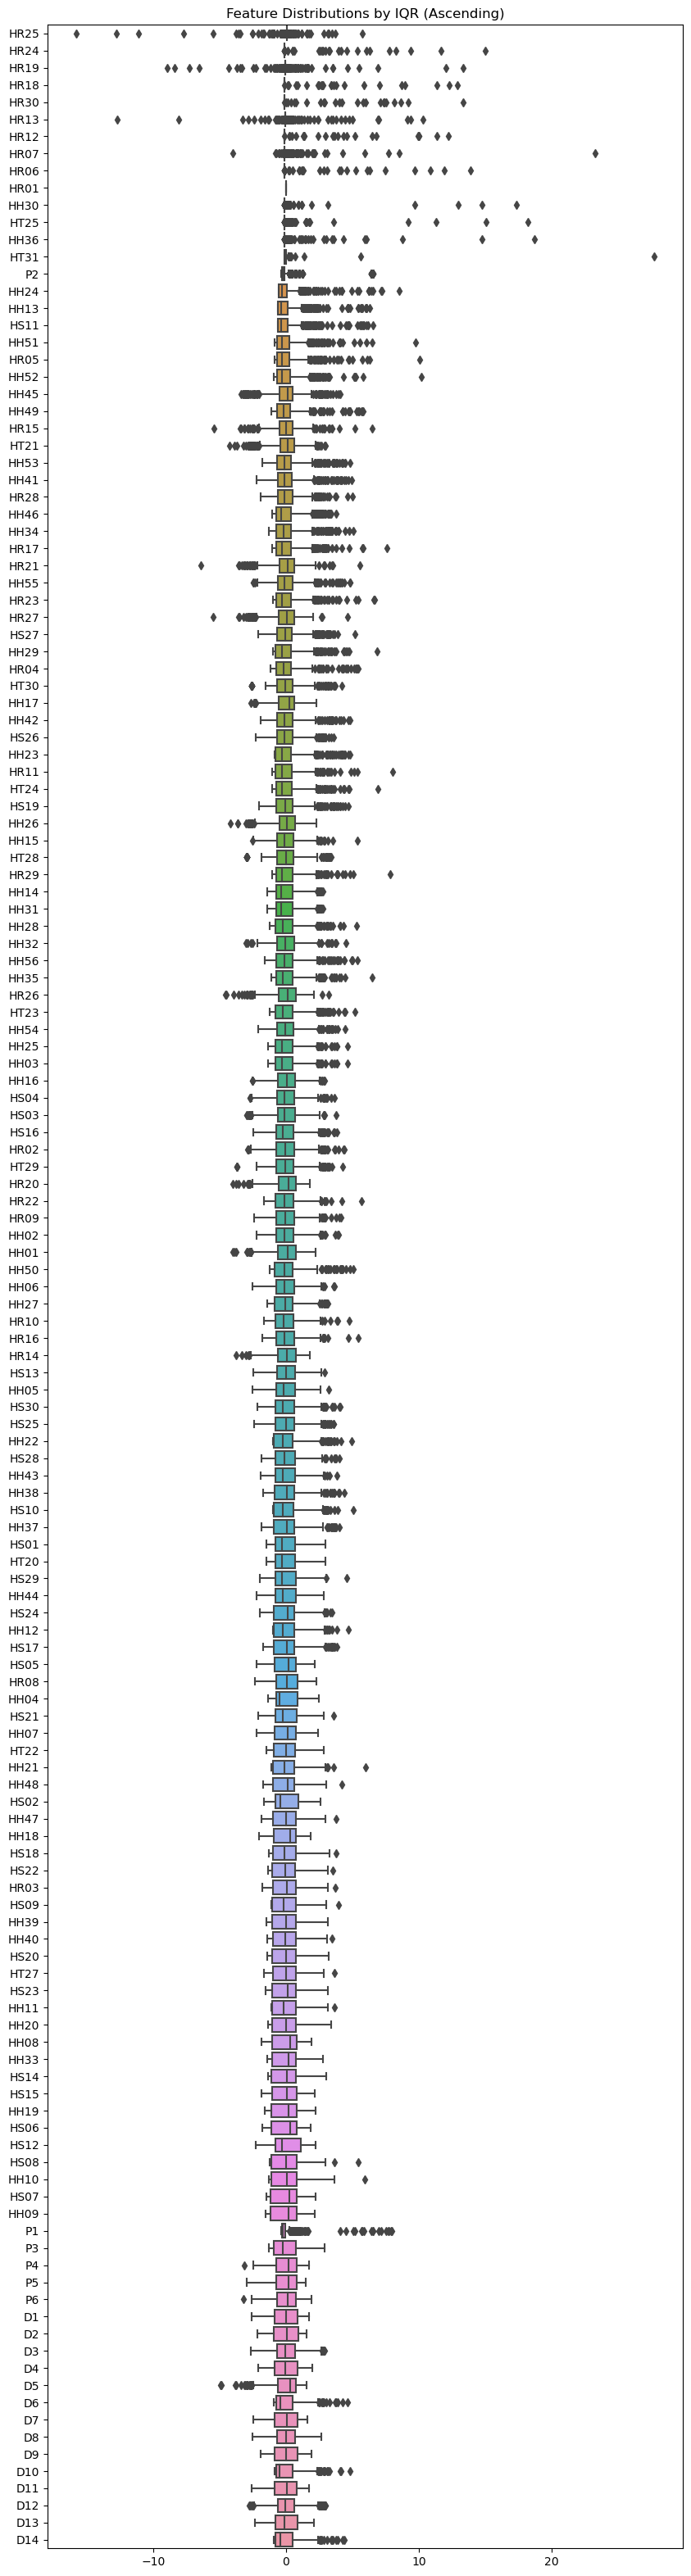

In [71]:
# check for outliers, distributions, using scaled data in box plot

scaler = StandardScaler()
scaled = scaler.fit_transform(df.select_dtypes(include=['number']))
df_scaled = pd.DataFrame(scaled, columns=df.select_dtypes(include=['number']).columns, index=df.index)
iqr_vals = df_scaled.apply(lambda col: np.percentile(col, 75) - np.percentile(col, 25))
iqr_vals = iqr_vals.drop('T1').sort_values(ascending=True)
iqr_vals_sorting_index = iqr_vals.index

plt.figure(figsize=(10,40))
sns.boxplot(df_scaled[iqr_vals_sorting_index], orient='h')
plt.title("Feature Distributions by IQR (Ascending)")
plt.show()

In [72]:
# observe values via .describe()

describe_df = df_scaled.describe().T
describe_df = describe_df.merge(code_dict[['Code', 'Description']], left_on=describe_df.index, right_on='Code')
describe_df['IQR'] = describe_df['75%'] - describe_df['25%']
describe_df = describe_df.sort_values(by='IQR', ascending=True)
describe_df
iqr_zero_df = describe_df[np.isclose(describe_df['IQR'], 0, atol=1e-3)]

iqr_zero_df

,count,mean,std,min,25%,50%,75%,max,Code,Description,IQR
55,809.0,-2.865885e-14,1.000619,-15.753870,0.067188,0.067188,0.067188,5.754020,HR25,Average number of Heads in 5 persons household,0.0
43,809.0,4.781452e-14,1.000619,-12.694715,-0.079014,-0.079014,-0.079014,10.344547,HR13,Average number of Heads in 3 persons household,0.0
42,809.0,4.391488e-18,1.000619,-0.131171,-0.131171,-0.131171,-0.131171,12.251135,HR12,Average number of Other relative or Non relati...,0.0
37,809.0,2.840634e-14,1.000619,-4.013355,-0.105337,-0.105337,-0.105337,23.274015,HR07,Average number of Heads in 2 persons household,0.0
36,809.0,3.952339e-17,1.000619,-0.126584,-0.126584,-0.126584,-0.126584,13.920813,HR06,Average number of other relatives and/or non r...,0.0
31,809.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,HR01,Average number of heads in the household,0.0
54,809.0,-3.952339e-17,1.000619,-0.132614,-0.132614,-0.132614,-0.132614,14.982355,HR24,Average number of Other Relatives or Non relat...,0.0
48,809.0,-8.782976e-18,1.000619,-0.130004,-0.130004,-0.130004,-0.130004,12.925818,HR18,Average number of Other relatives or Non relat...,0.0
60,809.0,1.317446e-17,1.000619,-0.139468,-0.139468,-0.139468,-0.139468,13.334333,HR30,Average number of Other relatives or Non relat...,0.0
49,809.0,4.907488e-14,1.000619,-8.929243,-0.020703,-0.020703,-0.020703,13.364777,HR19,Average number of Heads in 4 persons household,0.0


Number of columns with zero IQR: 10


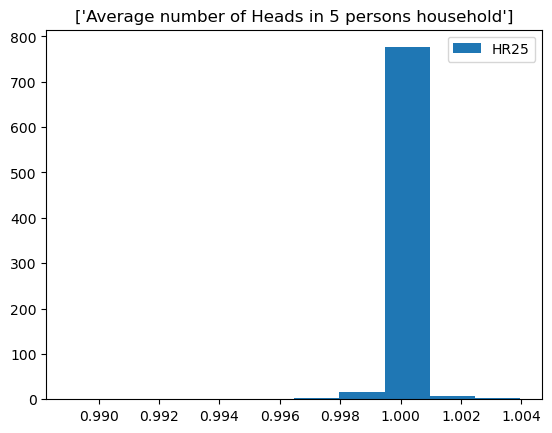

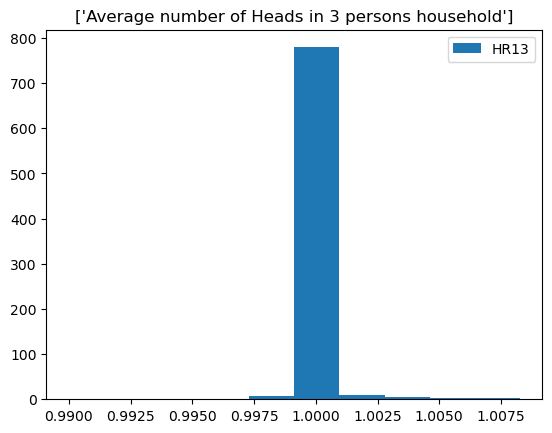

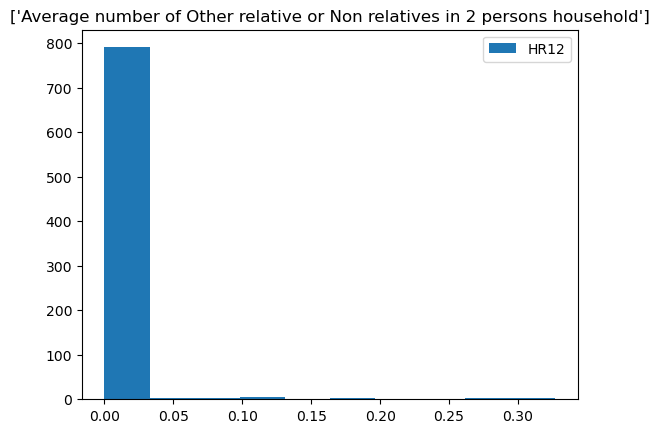

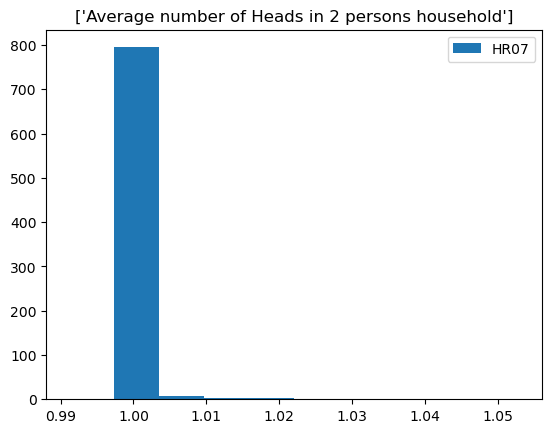

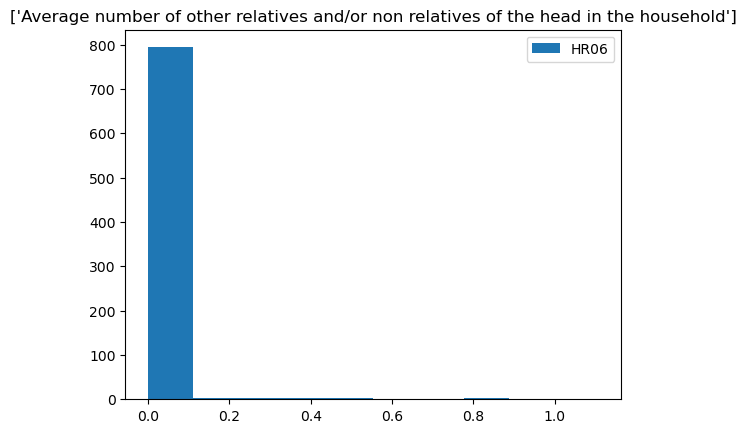

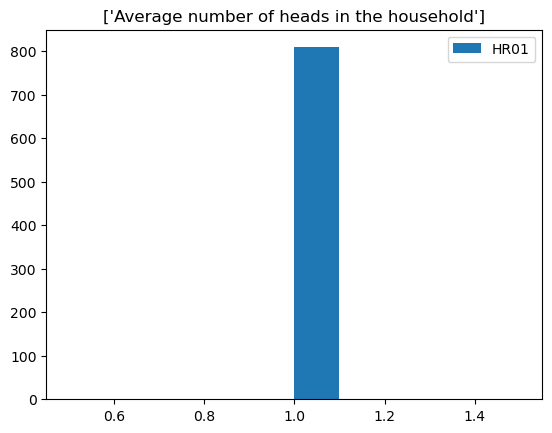

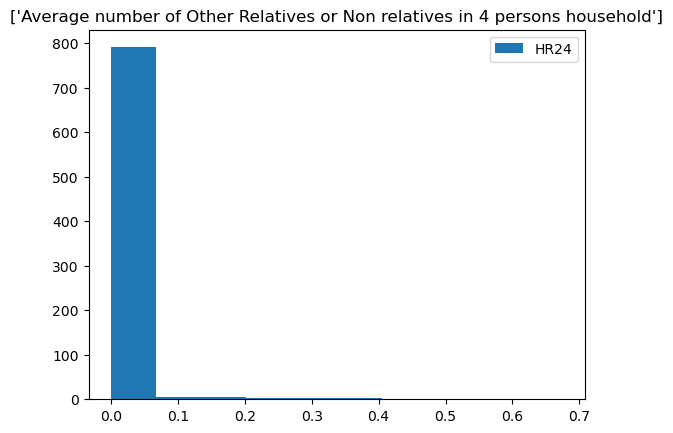

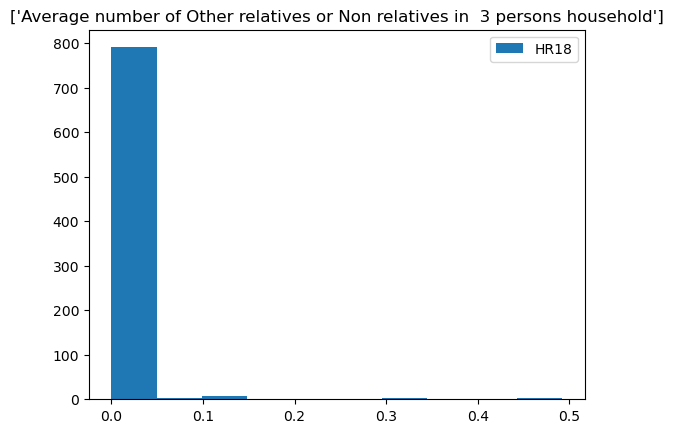

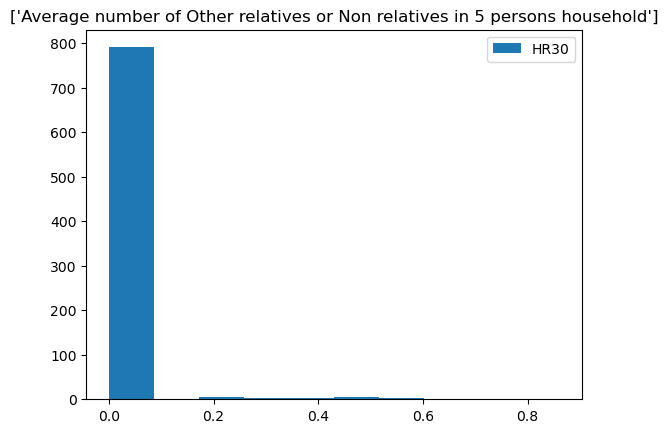

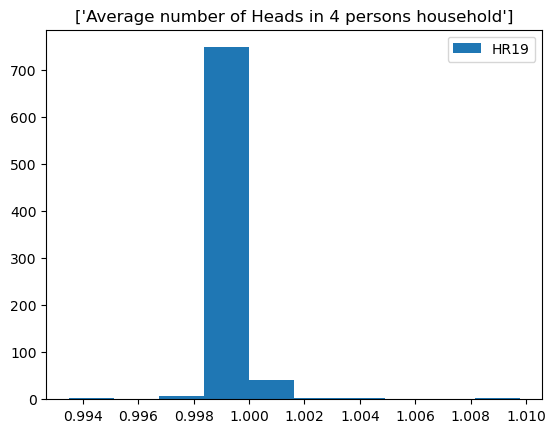

In [73]:
# inspect unscaled version of iqr zero columns
iqr_zero_cols = iqr_zero_df['Code'].values.tolist()

print(f"Number of columns with zero IQR: {len(iqr_zero_cols)}")
iqr_zero_df

for col in iqr_zero_cols:
    plt.hist(df[col], label=col)
    plt.title(f"{code_dict.loc[code_dict['Code']==col, 'Description'].values}")
    plt.legend()
    plt.show()

In [74]:
# drop zero IQR columns and revise groupings

print(f"The following columns are near-constant and must be dropped: {iqr_zero_cols}")

df = df.drop(iqr_zero_cols, axis=1)

The following columns are near-constant and must be dropped: ['HR25', 'HR13', 'HR12', 'HR07', 'HR06', 'HR01', 'HR24', 'HR18', 'HR30', 'HR19']


### Changes Log (df)

List of changes to CoResidence table (df) thus far:

**Unused Columns Dropped:**
- 'DB' column is a metadata tag (all row == "National") (as opposed to Sub-National)
- 'C0' Country ISO nomenclature 2 digits
- 'C4' Sub continent
- 'T2' Census round
- 'T3' Most recent year
- 'T5' Five years
- 'T10' Decade
- 'S1' Sample identification
- 'S2' Data source

**Effective Duplicate Columns Dropped:**
- 'HT01':'HT18' - these columns were duplicates of other columns in the Household Typology sub-family
- 'HT26' - This column was a duplicate of 'HR01'

**Miscellaneous Changes**
- Select null values forward and back filled in rows 218, 219, 427, 428

- 36 rows within six proportional column groupings that fail to add-to-one were normalized (see normalize_groups variable for proportional column groupings)

- Null values in Household Typology columns (HT) replaced with zeros, as these are assumed to be sub-detectable averages

- Infinite "inf" values identified in rows 79, 325, 547, 569, 758 and replaced with column means

- Rows of country "Kosovo" to be deleted, as no development data is available

**Zero IQR Columns**
- 10 columns have been identified as having a zero interquartile range, (saved as a list under variable iqr_zero_cols): 'HR01', 'HR06', 'HR07', 'HR12', 'HR13', 'HR18', 'HR19', 'HR24', 'HR25', 'HR30'
- These ten columns fit into one of two types: "Average number of heads of household" (values are 1), and residual categories for "Other" family or nonfamily household members (values tend to be near zero)
- Upon inspection of unscaled features, these are nearly constant, and should were dropped to avoid multicolinearity 


## Exploratory Feature Selection

Now that basic data validation and cleaning is complete (see Changes Log), we are ready to begin exploratory modelling.

The dataset is **feature-rich**, with over **150 features**. Which features to begin with? Which target to select? In this section, I create a working copy of table df called df_kbest (df.copy()) to handle preliminary feature selection.

I use **multiple info regression** as a feature selection method because it is agnostic to linearity. MI estimates the  joint probability density for each feature-target pair using Euclidean distance pairs as a proxy. These estimated densitites are then used to maximize dependency (or minimize uncertainty) in the feature-target relationship.

The intent of using MI at this stage is not to eliminate features, understand feature relationships deeply, or to select a model. MI evaluates feature-target relationships in a univariate fashion, which cannot capture feature interactions. Thus, it is not a substitute for a model. The intent is rather to examine features at a high level.

The provisional target variable chosen initially is column 'D1', "Human Development Index", (which is a weighted sum of various measures of human flourishing). MI identifies the need for a new target, after data leakage from P and D features is revealed.

In [75]:
# Create a kbest copy of dataframe to run feature selection, drop null-containing rows
df_kbest = df.copy()

In [76]:
# Null values in "D" columns to be filled by backfill and forward fill

df_kbest.loc[:, df_kbest.columns.str.startswith('D')] = (
    df_kbest
    .groupby('C1', group_keys=False)
    [df_kbest.columns[df_kbest.columns.str.startswith('D')]]
    .transform(
    lambda x: x.ffill().bfill()
)
                                                        )

In [77]:
# drop remaining null values to prepare for feature selection and preliminary models
df_kbest = df_kbest.dropna()

In [78]:
print(f"Shape after dropping null values: {df_kbest.shape}")
print(f"Number of Countries after dropping null values: {df_kbest['C1'].nunique()}")
print(f"Year Range after dropping null values: Min {min(df_kbest['T1'])}, Max {max(df_kbest['T1'])}")

Shape after dropping null values: (796, 141)
Number of Countries after dropping null values: 151
Year Range after dropping null values: Min 1960, Max 2021


In [79]:
# Check for successful drop of null values
df_kbest.isnull().sum().sum()

0

In [80]:
# shuffle the data, then sort by year to prepare for time series modelling

df_kbest = df_kbest.sample(frac=1)
df_kbest = df_kbest.sort_values(by='T1')
df_kbest.head()

,C1,C2,C3,T1,HS01,HS02,HS03,HS04,HS05,HS06,...,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
574,PAN,Panama,LATIN-AMERICA,1960,0.130945,0.124407,0.136229,0.129064,0.121272,0.106852,...,0.968,10345.730200,0.704162,12.898770,7.478220,5523.889400,0.727515,11.786000,7.337380,15092.778400
702,TGO,Togo,AFRICA,1960,0.184261,0.127159,0.109405,0.107965,0.085893,0.070058,...,0.761,1751.716825,0.376757,7.061355,2.041250,1418.953019,0.495042,11.225550,5.140753,2087.301569
759,USA,United States,NORTH-AMERICA,1960,0.133270,0.280937,0.187643,0.172980,0.111087,0.058994,...,0.987,39472.302100,0.864349,15.840340,12.880528,29087.562270,0.875303,15.022860,13.087013,50300.030670
240,FRA,France,EUROPE,1962,0.195290,0.266903,0.187401,0.148474,0.094147,0.053035,...,0.941,11465.922010,0.701620,14.665449,10.249335,6909.730576,0.745988,14.192471,10.177794,15916.780660
627,PRY,Paraguay,LATIN-AMERICA,1962,0.076302,0.098380,0.117423,0.125040,0.124459,0.119231,...,0.911,8212.272417,0.564696,8.537507,5.419169,5066.614897,0.619961,8.893613,5.950947,11287.375430


In [81]:
# Split the data with target == 'D1'which corresponds to column "Human Development Index"
# Drop 'C1' country code, 'C3' (continent), 'D1' (target), plus drop cols list

X = df_kbest.drop(columns=['T1', 'C1', 'C2', 'C3', 'D1'])

y = df_kbest['D1']

In [82]:
# Check for any remaining non-numeric columns

numeric = X.select_dtypes(include=['number'])

for col in X.columns:
    if col not in numeric.columns:
        description = code_dict[code_dict['Code']==col]['Description'].values[0]
        print(f"{col} not numeric. {col} datatype is {X[col].dtype}, {description}")
        

In [83]:
# run selector
mi_scores = mutual_info_regression(X, y, random_state=21)

In [84]:
# Create a dataframe to display selector metrics

metrics_df = pd.DataFrame(zip(X.columns, mi_scores), columns=['Code', 'MI Score'])

In [85]:
# Pull in 'Description' names of features from code_dict for features deemed important according to KBest selector
metrics_df = metrics_df.merge(code_dict[['Code','Description']], on='Code', how='left')


In [86]:
# Inspect columns deemed important by KBest selector

metrics_df.sort_values(by='MI Score', ascending=False).head(10)


,Code,MI Score,Description
132,D11,2.697603,Human development index male
128,D7,2.544426,Human development index female
127,D6,1.639000,Gross National Income per capita
131,D10,1.564947,Gross National Income per capita female
135,D14,1.525213,Gross National Income per capita male
124,D3,1.469873,Expected years of schooling
129,D8,1.426559,Expected years of schooling female
134,D13,1.337099,Mean years of schooling male
130,D9,1.324669,Mean years of schooling female
133,D12,1.323158,Expected years of schooling male


### Exploratory Feature Selection Summary

Choosing HDI (column 'D1') as a provisional target value creates indirect (extra-tabular) data leakage via the 'D' and 'P' columns, which are the constituent elements of the Human Development Index. In other words, the features identified as most salient to the model are the very same features used to generate HDI, which is unsuprising in hindsight. 

Two potential solutions: (1) Select a different target, or (2) Exclude composite index feature columns from the model. 

For the purposes of preliminary feature analysis, we will drop the 'D' and 'P' columns to observe only household configuration columns.

In [87]:
# Drop the D and P columns and try again, as the D columns the constituent indices of HDI

X = X.drop(X.columns[X.columns.str.startswith(('D','P'))], axis=1)


In [88]:
# Run selector again without d cols in X

mi_scores_2 = mutual_info_regression(X, y, random_state=21)


In [89]:
# metrics_df_2

metrics_df_2 = pd.DataFrame(zip(X.columns, mi_scores_2), columns=['Features', 'MI Score II'])

metrics_df_2 = metrics_df_2.merge(code_dict[['Code','Description']], left_on='Features', right_on='Code', how='left')

In [90]:
# Examine features without confounding D-features

with pd.option_context('display.max_colwidth', None):
    display(metrics_df_2.sort_values(by='MI Score II', ascending=False).head(10))

# Will be interesting to see if these remain the most salient features after imputation

,Features,MI Score II,Code,Description
19,HS20,0.816342,HS20,Average number of children in the household (aged < 18)
21,HS22,0.784437,HS22,Average number of 0-9 individuals in the household
99,HH39,0.759942,HH39,Average number of children in male-headed households
22,HS23,0.751021,HS23,Average number of 10-19 individuals in the household
17,HS18,0.727075,HS18,Average number of 0-4 children in the household
14,HS15,0.718278,HS15,Proportion of households with at least one person 0-4 years old
97,HH37,0.712634,HH37,Average household size of male-headed households
13,HS14,0.674275,HS14,Proportion of 6+ persons households
1,HS02,0.672226,HS02,Proportion of 2-persons households
71,HH11,0.671747,HH11,Proportion of 9-persons households of male-headed households


In [91]:
# train vs. test scores

results, models = tscv_loop(X, y, 'exploratory', 3)
results

Model Lasso requires scaling. Standard Scaler applied.
Model Lasso alpha is 0.001
Model Ridge requires scaling. Standard Scaler applied.
Model Ridge alpha is 0.1


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.360e-04, tolerance: 5.049e-04
  model = cd_fast.enet_coordinate_descent(
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e-03, tolerance: 1.098e-03
  model = cd_fast.enet_coordinate_descent(


,Fold,Dataset,Linear Regression Train Score,Linear Regression Test Score,Lasso Train Score,Lasso Test Score,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score
0,1,exploratory,0.807431,-1.129928,0.460003,0.711903,0.618340,0.647420,0.912739,0.719852
1,2,exploratory,0.789408,0.807142,0.647880,0.849672,0.736662,0.889681,0.955404,0.894450
2,3,exploratory,0.834503,0.778791,0.734382,0.852711,0.808055,0.884196,0.969668,0.871427


In [92]:
# feature importances
exploratory_importances = pd.DataFrame(
    zip(X.columns,
        models['Random Forest'].feature_importances_),
    columns=['Features', 'RF Importances'])
        
top_ten = (
    exploratory_importances
    .sort_values(by='RF Importances', ascending=False)
    .merge(code_dict[['Code', 'Description']], left_on='Features', right_on='Code', how='left')
)

top_ten.head(10)

,Features,RF Importances,Code,Description
0,HH39,0.161114,HH39,Average number of children in male-headed hous...
1,HS22,0.091880,HS22,Average number of 0-9 individuals in the house...
2,HS23,0.078032,HS23,Average number of 10-19 individuals in the hou...
3,HS20,0.054753,HS20,Average number of children in the household (a...
4,HS18,0.049983,HS18,Average number of 0-4 children in the household
5,HS15,0.047683,HS15,Proportion of households with at least one per...
6,HH11,0.040884,HH11,Proportion of 9-persons households of male-hea...
7,HT30,0.034654,HT30,Average size of other non family households b...
8,HR03,0.032105,HR03,Average number of children of the head in the ...
9,HR10,0.028408,HR10,Average number of Other relatives in 2 persons...


### Core Table Validation and Exploratory Model Summary

Initial feature selection showed indirect data leakage from 'P' and 'D' columns (population and development information), into target column HDI (Human Development Index). Leaky features were dropped to examine feature-target relationships in exclusion of these features.

One solution for leakage would be to drop the leaky features from the data. However, these features likely have meaningful impacts on the target, or important interactions with other features. Dropping the features wholesale would constitute a loss of valuable information.

In order to select a target that is independent of, and free from, data leakage, while preserving population and development data, I will import a new target: Gini Index
 
**Potential to compare HDI to Gini later in the analysis**


## Table 2: Gini Index

In the previous section, I conducted a preliminary feature selection analysis using a linearity-agnostic method (mutual info regression). This analysis made clear that my original choice for a target variable, Human Development Index ('D1') was subject to data leakage vis a vis the index's consituent indices ('P' and 'D' columns). 

To avoid eliminating potentially informative features, I select a new target variable. 

**Why Gini Index?**
- Data Independence: Methodology of generating the index does not rely on the leaky features at all
- Availability: Gini data is readily available and free.
- Serves as a good proxy of human flourishing, which is the qualitative goal of this study. 
- Robustness: Similar to how a median statistic is more stable than a mean. Gini Index provides an indication of whether the "happiness" of a populace is typical or atypical.

**Challenges Introduced with Gini**

- While Gini data is available for similar year ranges as CoResidence data,  not every year in the Gini range matches the years in the CoResidence range. 
- As a result, it is necessary to conduct an outer merge, in order to preserve all Gini data. This creates data sparsity.
- Missing values are handled using three imputation methods, in order to avoid bias introduced by reconstructing data.

Gini Index table is horizontal (266, 69) consists of:
- 266 countries (1 row per country)
- 69 columns consist of the 64 years in the range, 1960-2024, as well as 'Country Name', 'Country Code', and two columns that are uninformative to our purposes.
- Table is melted into long format. New shape is (17,024, 4)
- The vast majority of rows in the Gini table are blank. Not all years represented have Gini values: Only 2,108 values out of 17,024 are not null. 98 countries (37%) have no gini values at all.

Changes made to merged table before merge:
- Dropped: 'Indicator Name' (all values = 'Gini index), 
- Dropped: 'Indicator Code' (all values = 'SI.POV.GINI')
- Dropped: 'Unnamed: 68' (all values NaN)
- Reshaped: Wide shape (266, 69) is melted into vertical shape (17024, 4) with 64 * 266 rows (64 year-rows per country).


In [93]:
# Read in gini index dataset for new target selection

file_path = './API_SI.POV.GINI_DS2_en_csv_v2_3401539/API_SI.POV.GINI_DS2_en_csv_v2_3401539.csv'
gini_df = pd.read_csv(file_path,
                     skiprows=3)


In [94]:
# Wide format data must be melted on 'Year'. 
# Drop columns which are not needed and will complicate melt.
gini_df = gini_df.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 68'], axis=1)

In [95]:
# Melt into long format with Gini values in Year variable
gini_df = pd.melt(gini_df, id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='Gini')


In [96]:
# Inspect post-melt table
gini_df.loc[gini_df['Gini'].notnull()].head()
print(gini_df.shape)

(17024, 4)


In [97]:
# How many countries have all null Gini values

all_null_gini = gini_df.groupby('Country Code')['Gini'].apply(lambda x: x.isnull().all())
all_null_gini[all_null_gini]

print(f"Percentage of countries with no Gini values: {round(len(all_null_gini[all_null_gini])/gini_df['Country Code'].nunique()*100, 2)}%")



Percentage of countries with no Gini values: 36.84%


In [98]:
# Assess CoResidence column candidates for merge join condition 'C1' (Country Code) vs. 'C2' (Country Name)

print(f"Country Code in CoResidence but not in Gini:"
      f"{[value for value in df['C1'].unique() if value not in gini_df['Country Code'].unique()]}")

print(f"Country Code in Gini but not in CoResidence:"
     f"{[value for value in gini_df['Country Code'].unique() if value not in df['C1'].unique()]}")
      
# XXK and XKX are 'Kosovo' and names will be standardized

Country Code in CoResidence but not in Gini:['XXK']
Country Code in Gini but not in CoResidence:['ABW', 'AFE', 'AFW', 'AND', 'ARB', 'ARE', 'ASM', 'ATG', 'BHR', 'BHS', 'BMU', 'BRB', 'BRN', 'CEB', 'CHI', 'CPV', 'CSS', 'CUW', 'CYM', 'DMA', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'EMU', 'ERI', 'EUU', 'FCS', 'FRO', 'FSM', 'GIB', 'GNQ', 'GRD', 'GRL', 'GUM', 'HIC', 'HKG', 'HPC', 'IBD', 'IBT', 'IDA', 'IDB', 'IDX', 'IMN', 'INX', 'ISL', 'JPN', 'KIR', 'KNA', 'KWT', 'LAC', 'LBN', 'LBY', 'LCN', 'LDC', 'LIC', 'LIE', 'LKA', 'LMC', 'LMY', 'LTE', 'MAC', 'MAF', 'MCO', 'MEA', 'MHL', 'MIC', 'MLT', 'MNA', 'MNP', 'NAC', 'NCL', 'NOR', 'NRU', 'NZL', 'OED', 'OMN', 'OSS', 'PLW', 'PRE', 'PRK', 'PSS', 'PST', 'PYF', 'SAS', 'SAU', 'SGP', 'SLB', 'SMR', 'SSA', 'SSF', 'SST', 'SXM', 'SYC', 'TCA', 'TEA', 'TEC', 'TLA', 'TMN', 'TON', 'TSA', 'TSS', 'UMC', 'VCT', 'VGB', 'VIR', 'VUT', 'WLD', 'XKX']


In [99]:
# Examine country names in CoResidence (df['C2']) but not in Gini (gini_df['Country Name'])

mismatched_country_names = [value for value in df['C2'].unique() if value not in gini_df['Country Name'].unique()]
mismatched_country_names = df.loc[df['C2'].isin(mismatched_country_names),'C1': 'C2']
print(f'Following country names are in CoResidence but not Gini:')
print(mismatched_country_names.value_counts())
mismatched_country_names.nunique()

Following country names are in CoResidence but not Gini:
C1   C2                       
EGY  Egypt                        10
KOR  South Korea                   9
VNM  Vietnam                       8
TUR  Turkey                        8
CZE  Czech Republic                5
VEN  Venezuela                     4
LAO  Laos                          4
SVK  Slovakia                      4
PSE  Palestine                     3
COD  Congo Democratic Republic     2
RUS  Russia                        2
MKD  Macedonia                     2
COG  Congo                         2
LCA  Saint Lucia                   2
IRN  Iran                          2
GMB  Gambia                        2
YEM  Yemen                         2
SYR  Syria                         1
dtype: int64


C1    18
C2    18
dtype: int64

In [100]:
# Examine why country names were mismatched, while respective codes were not, with side-by side comparison of both tables
# Missing countries are correctly encoded, but have minor spelling differences

gini_df.loc[
    gini_df['Country Code'].isin(mismatched_country_names['C1']), 
    ['Country Name', 'Country Code']].merge(df[['C1', 'C2']], 
                                            right_on='C1', left_on='Country Code', how='left').drop_duplicates()


,Country Name,Country Code,C1,C2
0,"Congo, Dem. Rep.",COD,COD,Congo Democratic Republic
2,"Congo, Rep.",COG,COG,Congo
4,Czechia,CZE,CZE,Czech Republic
9,"Egypt, Arab Rep.",EGY,EGY,Egypt
19,"Gambia, The",GMB,GMB,Gambia
21,"Iran, Islamic Rep.",IRN,IRN,Iran
23,"Korea, Rep.",KOR,KOR,South Korea
32,Lao PDR,LAO,LAO,Laos
36,St. Lucia,LCA,LCA,Saint Lucia
38,North Macedonia,MKD,MKD,Macedonia


In [101]:
# Update 'Year' in gini_df to match data type of T1 (year in df) to facilitate merge

gini_df['Year'] = gini_df['Year'].astype('int64')

In [102]:
# Update Kosovo C1 value in left table to XKX to match right table to ensure proper merges with gini_df

df.loc[df['C1']=='XXK', 'C1'] ='XKX'

### MERGE 1: Coresidence and Gini

Merge tables: df outer merged with gini_df (new target variable). 
- Shape of df before merge is (809, 178)
- Shape of df_merge1 (df after merge) is (17,036, 182)

Merged on ISO code and 'Year' ('T1'). First merge condition is 'C1' (Country ISO nomenclature 3 digits) on CoResidence (left) table, which matches to 'Country Code' on (right) table Gini Index. 'Country Name' ('C2') would have been another potential merge condition, but presents too many variations in spelling.

Kosovo country code was the only three digit ISO code to have any variation between tables, and was updated in CoResidence (left table) to prepare for the merge. No other country codes were altered in CoResidence. 

Left table does not have all years within total time range populated, therefore a left merge on 'T1' ('Year') would eliminate Gini data.

In preparation for interpolation and imputation, countries with fewer than two Gini values and fewer than two rows of Core Feature ('H' columns) are identified.


In [103]:
# Merge df with gini df. C1= Country Code, C2 = Country Name, T1 = Year

print(f'Shape before merge is {df.shape}')

df_merge1 = df.merge(gini_df, left_on=['C1', 'T1'], right_on=['Country Code', 'Year'], how='outer')

print(f'Shape after merge is {df_merge1.shape}')

Shape before merge is (809, 141)
Shape after merge is (17036, 145)


In [104]:
# How many countries

merge1_country_total = df_merge1['Country Code'].nunique()

print(f"Total number of countries after merge: {merge1_country_total}")

Total number of countries after merge: 266


In [105]:
# Sort values. Inspect merge results
df_merge1 = df_merge1.sort_values(by=['Country Code', 'Year'])

In [106]:
# how many countries have no gini data at all in gini 

all_gini_nulls = gini_df.groupby('Country Code', group_keys=False)['Gini'].apply(lambda x: x.isnull().all())

print(f"Countries with no Gini data: {len(all_gini_nulls[all_gini_nulls])}, Total rows with no Gini data: {len(gini_df.loc[gini_df['Country Code'].isin(all_gini_nulls[all_gini_nulls].index),:])}")
print(f"Total rows in data: {len(gini_df)}")

Countries with no Gini data: 98, Total rows with no Gini data: 6272
Total rows in data: 17024


In [107]:
# drop rows of countries with fewer than two gini values (two values needed for interpolation)

two_fewer_gini = (
    df_merge1
    .groupby('Country Code', group_keys=False)['Gini']
    .apply(lambda group: group.notnull().sum()<2)
)

two_fewer_gini_countries = two_fewer_gini[two_fewer_gini].index
print(f"{len(two_fewer_gini_countries)} with fewer than two rows of Gini values")
two_fewer_gini_countries

# 98 countries have no Gini values at all, should be dropped

108 with fewer than two rows of Gini values


Index(['ABW', 'AFE', 'AFG', 'AFW', 'AND', 'ARB', 'ASM', 'ATG', 'BHR', 'BHS',
       ...
       'TLA', 'TMN', 'TSA', 'TSS', 'TUV', 'UMC', 'VCT', 'VGB', 'VIR', 'WLD'],
      dtype='object', name='Country Code', length=108)

In [108]:
# examine countries with fewer than two rows of core feature ('H') data

h_cols = df_merge1.columns.str.startswith('H')
two_fewer_hh = (
    df_merge1
    .groupby('Country Code', group_keys=False)
    .apply(lambda group: (
        group.loc[:, h_cols].notnull().sum()<2
    )
           .all())
)
    
two_fewer_hh_countries = two_fewer_hh[two_fewer_hh].index
len(two_fewer_hh_countries)
two_fewer_hh_countries

Index(['ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'AND', 'ARB', 'ARE', 'ASM', 'ATG',
       ...
       'TSS', 'TUN', 'TUV', 'UMC', 'VCT', 'VGB', 'VIR', 'VUT', 'WLD', 'WSM'],
      dtype='object', name='Country Code', length=133)

In [109]:
# union of two fewer hh and two fewer gini

two_fewer_countries = two_fewer_gini_countries.union(two_fewer_hh_countries)
len(two_fewer_countries)

139

In [110]:
# Create a drop row index corresponding to these countries

two_fewer_drop_index = []

for country in two_fewer_countries:
    country_index = df_merge1[df_merge1['Country Code']==country].index
    two_fewer_drop_index.extend(country_index)

In [111]:
len(two_fewer_drop_index)

8896

In [112]:
# drop two_fewer_drop_index as these changes should apply to all future merges

df_merge1 = df_merge1.drop(two_fewer_drop_index)

In [113]:
# define a small gini range as less than a decade of gini data

max_year = df_merge1[df_merge1['Gini'].notnull()].groupby('Country Code')['Year'].max()
min_year = df_merge1[df_merge1['Gini'].notnull()].groupby('Country Code')['Year'].min()

# check if indexes are equal before zipping
max_year.index.equals(min_year.index)

True

In [114]:
# calculate year range and inspect results
year_range = pd.DataFrame(
    zip(min_year.index, max_year.index, min_year, max_year, max_year-min_year), 
    columns=['Min Country','Max Country','Min', "Max", "Diff"]
)

small_gini_range = year_range[year_range['Diff']<8]
small_gini_range

,Min Country,Max Country,Min,Max,Diff
23,COG,COG,2005,2011,6
75,MMR,MMR,2015,2017,2
112,TTO,TTO,1988,1992,4
113,TUR,TUR,2017,2021,4


In [115]:
# construct small gini range countries drop index

small_gini_range_countries = small_gini_range['Min Country']

small_gini_range_drop_index = df_merge1[df_merge1['Country Code'].isin(small_gini_range_countries)].index

In [116]:
# drop small gini range

df_merge1 = df_merge1.drop(small_gini_range_drop_index)

In [117]:
# df_merge1 shape and values

df_merge1.shape
df_merge1['Country Code'].value_counts()

NPL    66
FRA    65
BGD    65
COL    65
NGA    65
       ..
GIN    64
GHA    64
GBR    64
GAB    64
ZWE    64
Name: Country Code, Length: 123, dtype: int64

In [118]:
# validate drops so far

original_country_total = df['C1'].nunique()

countries_dropped = list(two_fewer_gini_countries.union(two_fewer_hh_countries.union(small_gini_range_countries)))
num_countries_dropped = len(countries_dropped)
countries_remaining = df_merge1['Country Code'].unique()
num_countries_remaining = df_merge1['Country Code'].nunique()


assert (merge1_country_total == num_countries_dropped + num_countries_remaining), "Uh-oh lost track of a country!"
print(f"""Coresidence Country Total: {original_country_total},
    Post-Merge Country Total: {merge1_country_total},
      Countries Dropped: {num_countries_dropped}, 
      Countries Remaining: {num_countries_remaining}""")

Coresidence Country Total: 157,
    Post-Merge Country Total: 266,
      Countries Dropped: 143, 
      Countries Remaining: 123


In [119]:
# countries remaining versus original coresidence country list 
original_countries = list(df['C1'].unique())
dropped_cores_countries = [country for country in original_countries if country not in countries_remaining]
print(f"Number of countries dropped from CoResidence data: {len(dropped_cores_countries)}")
print(f"Name of countries dropped: {df.loc[df['C1'].isin(dropped_cores_countries), 'C2'].unique()}")

Number of countries dropped from CoResidence data: 34
Name of countries dropped: ['Afghanistan' 'Angola' 'Azerbaijan' 'Belize' 'Bhutan' 'Canada' 'Congo'
 'Cuba' 'Djibouti' 'Denmark' 'Finland' 'Georgia' 'Guyana' 'Haiti' 'Iraq'
 'Cambodia' 'Saint Lucia' 'Myanmar' 'Puerto Rico' 'Qatar' 'Sudan'
 'Somalia' 'South Sudan' 'Sao Tome and Principe' 'Suriname' 'Sweden'
 'Eswatini' 'Syria' 'Turkmenistan' 'Trinidad and Tobago' 'Tunisia'
 'Turkey' 'Tuvalu' 'Samoa']


### Merge 1 Summary

Summary of merge of core table with new target.

Concluding the merge between the CoResidence and Gini Index tables, the dataframe **df_merge1** is created. This df_merge1 is the most filtered version of the dataset. In other words, the rows in df_merge1 constitute the set of final rows to be included in this analysis. **Any future merges will branch off of df_merge1** and will be named according to merge order.

Filtering decisions were made with interpolation and iterative imputation methods in mind. Representing change requires at least two observations. Ideally, more than two samples are available per features/target pairing. To avoid dropping more countries than necessary, countries with **fewer than two rows of Gini data (target)** or **fewer than two rows of CoResidence core feature data** were dropped. Additionally, countries with a Gini timespan of fewer than 8 years were excluded; the rationale being that a span of 8+ years is long enough to represent meaningful change within a country.

Moving forward, target values ('Gini') will be interpolated using linear spline interpolation. I chose linear spline, out of a limited set of choices (given the sparsity of data), rather than pure linear interpolation. Spline was selected to better mimic the typical shape of continuous variables in sociological data.

As a result of this filtering criteria:
- Out of the original 157 countries in CoResidence, 34 were dropped, with 123 remaing. 
- More than half of 266 countries in the Gini dataset were dropped. Many of these countries were merged into CoResidence in an outer merge, despite having no match in the original CoResidence data. 
- 34 of the original 157 CoResidence coutries were dropped, leaving 123 remaining. 
- Increasing row-completeness thresholds would have resulted in dropping many more countries.

# Section III: Missing Values - Three Imputation Approaches

## A: Interpolation

Now that CoResidence is properly merged with the new target variable, Gini, and properly filtered down to rows with workable data, I interpolate missing values, using a simple "two brushstroke" approach (to use a painting metaphor).

Any method selected for handling missing values involves implicit assumptions. Meaning that the resulting dataset, is a type of simulated fact universe, which can only be as accurate as those assumptions are valid. I chose linear spline rather than purely linear interpolation, because sociological phenomena typically follow curved rather than strictly linear trends—though this is itself an assumption.

Given the sparsity of my data, I had needed to use some type of linear method, as other methods require more than two anchor points. The interpolation process was completed in two steps:
- Step 1: Interpoled the swath of rows missing in the middle the data, bounded by the earliest and latest samples respectively (grouped by country). This effectively "colors in" the years of missing data between (at least) two recorded observations. 
- Step 2: For the target, I made sure that the two rows of available data were at least 8 years apart. For the features, I did not consider the timespan of the data.

These two "brushstrokes" of filled-in years did not always line up. To resolve this:
- I deleted rows on the unknown edges of the data, where neither feature nor target data were available. The assumption beings that if we have data for either features or target, we at least know *something* about the truth.
- Finally, I backfilled and forward filled the remaining rows.

In [120]:
# Drop rows_to_drop
df_baseline = df_merge1.copy()
df_baseline = df_baseline.sort_values(by=['Country Code', 'Year'])

In [121]:
# check number of unique countries
print(f"Number of countries remaining after two-or-fewer countries dropped: {df_baseline['Country Code'].nunique()}")
print(f"Number of rows of remaining: {len(df_baseline)}")

Number of countries remaining after two-or-fewer countries dropped: 123
Number of rows of remaining: 7884


In [122]:
# examine merge results
df_baseline.head()

,C1,C2,C3,T1,HS01,HS02,HS03,HS04,HS05,HS06,...,D9,D10,D11,D12,D13,D14,Country Name,Country Code,Year,Gini
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1960,NaN
1077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1961,NaN
1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1962,NaN
1607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1963,NaN
1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1964,NaN


In [123]:
# fill in missing 'Continent' variable rows for country groups using existing continent data

df_baseline['C3_'] = (
    df_baseline.groupby('Country Code', group_keys=False)['C3']
    .transform(lambda group: group.bfill().ffill())
)



In [124]:
# Inspect 'C3' vs 'C3_' for accuracy

df_baseline[df_baseline['C3'].isnull()][['C1', 'C2', 'C3', 'C3_', 'Country Code', 'Country Name']].head()

,C1,C2,C3,C3_,Country Code,Country Name
814,NaN,NaN,NaN,EUROPE,ALB,Albania
1077,NaN,NaN,NaN,EUROPE,ALB,Albania
1343,NaN,NaN,NaN,EUROPE,ALB,Albania
1607,NaN,NaN,NaN,EUROPE,ALB,Albania
1872,NaN,NaN,NaN,EUROPE,ALB,Albania


In [125]:
# country groups where 'C3' contains two different non-null values

c3_per_country = df_baseline.groupby('Country Code')['C3_'].apply(lambda group: len(group.value_counts())>1)

c3_per_country[c3_per_country]

Country Code
CHN    True
Name: C3_, dtype: bool

In [126]:
# inspect why CHN has two different values for "continent"

df_baseline[df_baseline['Country Code']=='CHN'][['C3','C3_']].value_counts()
df_baseline.loc[df_baseline['C3']=='ASIA','Country Name'].value_counts()

# transform c3 for group 'CHN'

df_baseline.loc[df_baseline['C3']=='CHN','C3_'] = 'ASIA'


In [127]:
# replace 'C3' with 'C3_' and drop 'C3_'

df_baseline['C3'] = df_baseline['C3_']

df_baseline = df_baseline.drop(columns='C3_', axis=1)

In [128]:
# prepare index for smooth interpolation 

df_baseline = df_baseline.sort_values(by=['Country Code', 'Year']).reset_index(drop=True)


In [129]:
# create new column for interpolation

df_baseline['Gini_interpol'] = df_baseline['Gini'].copy()  

In [130]:
# interpolate target column by country

df_baseline['Gini_interpol'] = (
    df_baseline.groupby('Country Code', group_keys=False)['Gini_interpol']
    .transform(lambda group: group.interpolate(method='slinear'))
)                                                                                     

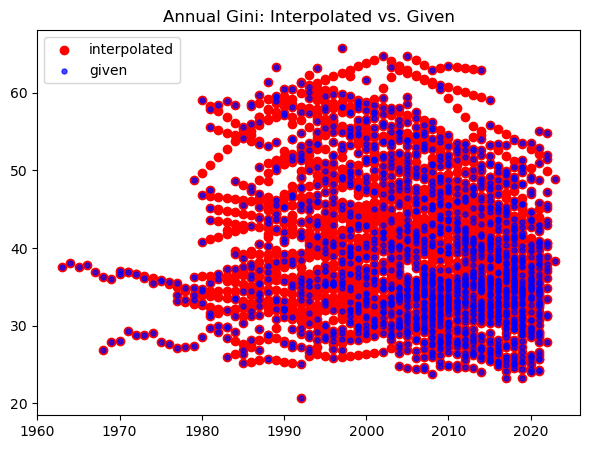

In [131]:
# visualize interpolated target Gini_interpl versus Gini

fig = plt.figure(figsize=(7,5))
plt.scatter(df_baseline['Year'], df_baseline['Gini_interpol'], color='red', label='interpolated')
plt.scatter(df_baseline['Year'], df_baseline['Gini'], color='blue', marker='o', s=13, alpha=0.7, label='given')
#plt.scatter(df_baseline['Year'], df_baseline.where(df_baseline['Gini']==df_baseline['Gini_interpol'])['Gini_interpol'], color='black')
plt.title("Annual Gini: Interpolated vs. Given")
plt.legend()
plt.show()

In [132]:
# Fix title formatting
df_baseline['C3'] = df_baseline['C3'].str.title()

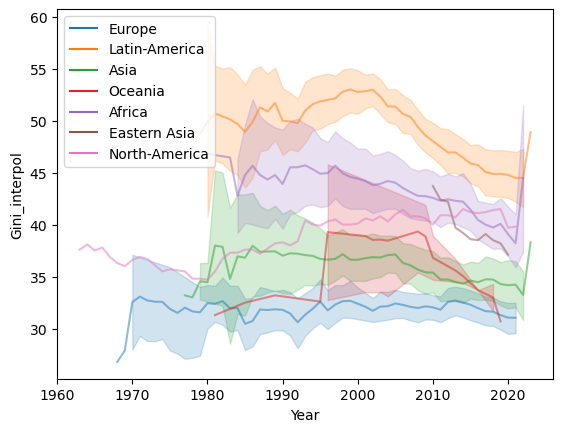

In [133]:
# hue = continent

plt.figure()
sns.lineplot(x='Year', y='Gini_interpol', data=df_baseline, hue='C3', legend=True, alpha=0.5)
plt.legend()
plt.show()

# break up countries into groups by color #hue values are missing

In [134]:
# Sparsity after target interpolation

df_baseline.isna().sum().sum() / df_baseline.size

0.8792534559329456

In [135]:
# create a function that handles interpolation per group, column

def group_interpol(group, columns):
    for column in columns:
        # fill columns with dummy value, these will be dropped if they have no Gini or core feature data
        if group[column].notnull().sum() < 2:
            group[column] = group[column].fillna(group[column].mean())
            
        # interpolate missing values where possible. these will be retained if Gini or core feature data available
        elif group[column].notnull().sum() >= 2:
            group[column] = group[column].interpolate(method = 'slinear')
    return group


In [136]:
# Apply function group_interpol() to interpolate values on D, P, H columns

columns_list = df_baseline.loc[: , df_baseline.columns.str.startswith(('D', 'P', 'H'))].columns.to_list()

df_baseline = (
    df_baseline.groupby('Country Code', group_keys=False)
    .apply(lambda group: group_interpol(group, columns_list))

)

In [137]:
# Identify rows where both Gini_interpol and core feature are totally blank

columns_list = ['Gini_interpol'] + list(df_baseline.columns[df_baseline.columns.str.startswith('H')])

both_gini_h_cols_null = (
    df_baseline.groupby('Country Code', group_keys=False)
    .apply(lambda group: group[columns_list].isnull().all(axis=1))
)

totally_blank_rows = both_gini_h_cols_null[both_gini_h_cols_null].index
print(f"Number of totally blank rows to be dropped: {len(totally_blank_rows)} out of {len(df_merge1)}")


Number of totally blank rows to be dropped: 3559 out of 7884


In [138]:
# drop rows that have no Gini_interpol values or H columns values identified above

df_baseline = df_baseline.drop(totally_blank_rows)

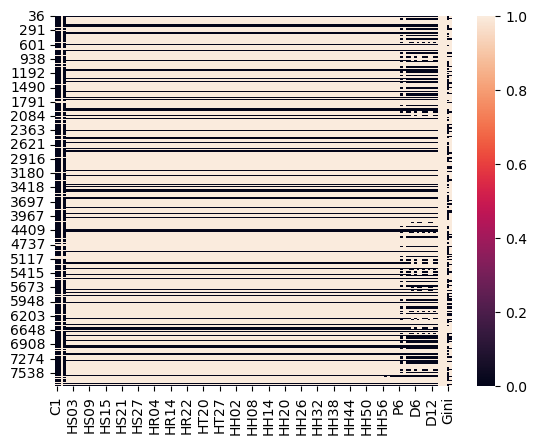

In [139]:
# Observe null values 
df_baseline = df_baseline.sort_values(by=['Country Code','Year'])
sns.heatmap(df_baseline.notnull())
plt.show()

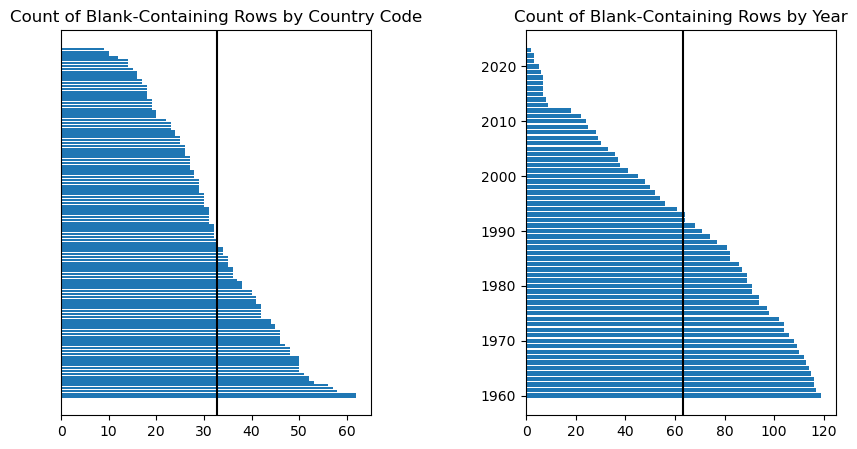

In [140]:
# observe distribution of null-containing rows
# .dropna() of these rows may enhance biases due to uneven temporal distribution of missingness

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
i = 0

for aggregator in ['Country Code', 'Year']:
    agg = (
        df_baseline.groupby(by=[aggregator], group_keys=False)
        .apply(lambda group: group.isnull().any(axis=1).sum(axis=0))
)
   
    ax[i].barh(agg.index, width = agg.sort_values(ascending=False))
    ax[0].set_yticks([])
    ax[i].set_title(f"Count of Blank-Containing Rows by {aggregator}")
    ax[i].axvline(agg.sum()/df_baseline[aggregator].nunique(), c='black')
    
    i+=1

plt.show()

In [141]:
# sparsity after interpolation and before back/forwardfill

df_baseline.isna().sum().sum()/df_baseline.size

0.21984955261699263

In [142]:
# Now that we have interpolated middle swath, back and forward fill remaining nulls

df_baseline = (
    df_baseline.groupby('Country Code', group_keys=False)
    .apply(lambda x: x.bfill().ffill())
)                                                                          

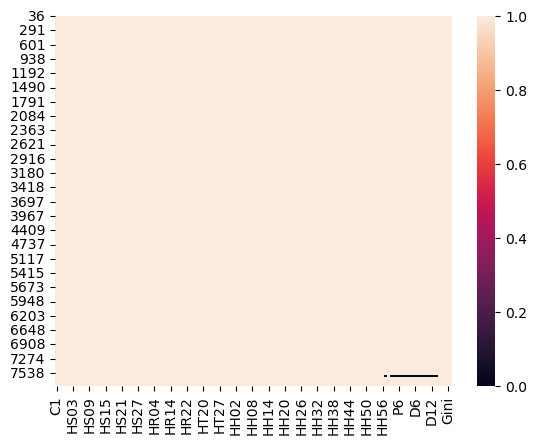

In [143]:
# check null values
sns.heatmap(df_baseline.notnull())
plt.show()

In [144]:
# fill all null values with column mean per country group

df_baseline = df_baseline.fillna(df_baseline.mean(numeric_only=True))

In [145]:
# observe any remaining null values
# namibia has blanks in C0, which will be dropped prior to modelling

df_baseline.isnull().sum().sum()

0

### Baseline Models

In [146]:
# drop 'C1' and 'T1'
df_baseline = df_baseline.drop(['C1', 'T1'], axis=1)

In [147]:
# Shuffle values to shuffle countries

df_baseline = df_baseline.sample(frac=1)

In [148]:
# Sort the values by year again (countries now shuffled) to prepare for tscv

df_baseline = df_baseline.sort_values(by='Year')

In [149]:
# Inspect results of time-ordered shuffle. Countries appear shuffled.
df_baseline.head(5)

,C2,C3,HS01,HS02,HS03,HS04,HS05,HS06,HS07,HS08,...,D10,D11,D12,D13,D14,Country Name,Country Code,Year,Gini,Gini_interpol
7306,United States,North-America,0.133270,0.280937,0.187643,0.172980,0.111087,0.058994,0.026453,0.013148,...,29087.562270,0.875303,15.02286,13.087013,50300.030670,United States,USA,1960,37.6,37.6
5642,Panama,Latin-America,0.130945,0.124407,0.136229,0.129064,0.121272,0.106852,0.087416,0.059651,...,5523.889400,0.727515,11.78600,7.337380,15092.778400,Panama,PAN,1960,48.7,48.7
6794,Togo,Africa,0.184261,0.127159,0.109405,0.107965,0.085893,0.070058,0.058541,0.049904,...,1418.953019,0.495042,11.22555,5.140753,2087.301569,Togo,TGO,1960,42.2,42.2
7307,United States,North-America,0.137414,0.282421,0.186253,0.171116,0.109682,0.058548,0.026791,0.012783,...,29087.562270,0.875303,15.02286,13.087013,50300.030670,United States,USA,1961,37.6,37.6
5643,Panama,Latin-America,0.130047,0.124742,0.135243,0.129216,0.121445,0.106951,0.087064,0.060255,...,5523.889400,0.727515,11.78600,7.337380,15092.778400,Panama,PAN,1961,48.7,48.7


In [150]:
# Drop the target to split the data

X = df_baseline.select_dtypes(include=['number']).drop(columns=['Gini_interpol', 'Gini'], axis=1)
y = df_baseline['Gini_interpol']

In [151]:
# baseline results

baseline_results, trained_models = tscv_loop(X, y, 'baseline', 3)

Model Lasso requires scaling. Standard Scaler applied.
Model Lasso alpha is 0.001
Model Ridge requires scaling. Standard Scaler applied.
Model Ridge alpha is 0.1


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.323e+03, tolerance: 9.592e+00
  model = cd_fast.enet_coordinate_descent(
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.84051e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e+04, tolerance: 1.924e+01
  model = cd_fast.enet_coordinate_descent(
/Users/lilianb

In [152]:
# view results
baseline_results

,Fold,Dataset,Linear Regression Train Score,Linear Regression Test Score,Lasso Train Score,Lasso Test Score,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score
0,1,exploratory,0.807431,-1.129928,0.460003,0.711903,0.618340,0.647420,0.912739,0.719852
1,2,exploratory,0.789408,0.807142,0.647880,0.849672,0.736662,0.889681,0.955404,0.894450
2,3,exploratory,0.834503,0.778791,0.734382,0.852711,0.808055,0.884196,0.969668,0.871427
3,1,baseline,0.948447,-1.700506,0.871992,0.298582,0.876610,0.335915,0.996399,0.609845
4,2,baseline,0.800335,0.080635,0.752631,0.352040,0.764073,0.327086,0.994591,0.642871
5,3,baseline,0.744017,0.061401,0.700533,0.288440,0.711260,0.289586,0.994941,0.709607


In [153]:
# Top Ten Feature Importances - Baseline Model

feature_importances = trained_models['Random Forest'].feature_importances_

baseline_rf_importances = (
    pd.DataFrame(zip(X.columns, feature_importances), columns=['Code', 'Importance'])
    .sort_values(by='Importance', ascending= False)
)

with pd.option_context('display.max_colwidth', None):
    display(baseline_rf_importances.merge(code_dict[['Code', 'Description']], on='Code', how='left').head(10))


,Code,Importance,Description
0,HH34,0.313562,Proportion of other family households based on relationship to head of male-headed households
1,D5,0.074808,Gross Domestic income
2,HR23,0.048504,Average number of Non relatives in 4 persons household
3,P6,0.045405,Life expectancy male
4,HH21,0.037946,Proportion of 8-persons households of female-headed households
5,HR08,0.028146,Average number of Spouses in 2 persons household
6,HR17,0.021271,Average number of Non relatives in 3 persons household
7,HH52,0.021040,Average number of other non relatives of female-headed households
8,HR09,0.021005,Average number of Children in 2 persons household
9,HH29,0.017432,Proportion non family households based on relationship to head of male-headed households


In [154]:
# check 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Condition number of X_scaled: {np.linalg.cond(X_scaled)} (>10e3 is ill conditioned)")


vif_df = pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF']= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


Condition number of X_scaled: 1.381755545856227e+16 (>10e3 is ill conditioned)


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [155]:
# variance inflation factors very high
vif_df.sort_values(by='VIF', ascending=False).head(10)
top_ten_vif = vif_df.sort_values(by='VIF', ascending=False).head(10)['Feature'].tolist()

In [156]:
# VIF df correlation matrix

high_vif_correlation_matrix = df_baseline[top_ten_vif].corr().abs()

stacked_df = high_vif_correlation_matrix.stack().reset_index()
stacked_df.columns = ['feature_1', 'feature_2', 'correlation']
stacked_df.query('0.9 < correlation < 1.0')

,feature_1,feature_2,correlation
4,HH38,HS17,0.922942
7,HH38,HH40,0.940110
9,HH38,HS23,0.917997
12,HH37,HH39,0.969579
13,HH37,HS20,0.962244
14,HH37,HS17,0.993328
19,HH37,HS23,0.961078
21,HH39,HH37,0.969579
23,HH39,HS20,0.994407
24,HH39,HS17,0.963196


In [157]:
# Correlation matrix shows high collinearity for a number of features 
# After importing additional observations, try decomposition methods for dimensionality reduction

correlation_matrix = pd.DataFrame(
    df_baseline.corr(numeric_only=True).abs()
)

correlation_matrix
high_correlation_features = [column for column in correlation_matrix.columns if any((correlation_matrix[column] >0.9) & 
                                                                             (correlation_matrix[column] <1))]

print(f"""Percentage of highly correlated features: 
{round(len(high_correlation_features)/len(correlation_matrix.columns)*100,2)}%""")

Percentage of highly correlated features: 
79.29%


### Baseline Models Summary

Baseline models performed poorly on interpolated data. Lasso threw convergence warnings, and Ridge generated ill conditioned matrix warnings. I tuned alpha values and max_iter parameters for Lasso and Ridge to extremes, and convergence was still not achieved. 

To diagnose the problem, I analyzed variance inflation factors and found extreme results, which suggest that many of my features are nearly identical.  A further, cursory examination of feature correlations shows that 77% of features have at least one very high correlation with another feature. 

Initially, my primary concern with interpolation was the risk of introducing bias. I did not initially consider that interpolation might create such highly correlated features that they are nearly identical. 

In the two following sections, we will use other data imputation methods, such as iterative imputation and matrix factorization. 


## B: Iterative Imputation - Domain and Algorithmic

In Section III-A, I handled missing data using interpolation and backfilling. Interpolation reduced sparsity from 88% to 24% (prior to back and forward filling). A total of 3559 out of 7884 were dropped due to lack of data. 

In this section, we take a different approach to handling missing data. Prior to handling missing data, new data is brought in from 3 sources: United Nations "Most Used" dataset, United Nations Population Division, and United Nations Development Programme. Once additional observations are brought in followed by iterative imputation. 

Iterative Imputer is deployed in what I term a "plaid pattern." Both horizontal (row) and vertical (column) subsets are sequestered and imputed separately. Because the data admits of vertical groupings and horizontal groupings organically, choice of groups was straightforward. 


### Table 2: United Nations Population Division - Most Used

United Nations Population Data will be used to fill missing values for years missing from CoResidence database.

Specfically the following features are brought in from United Nations PD "Most Used" table are:
1. 'Fertility Rate'
2. 'Life Expectancy'
3. 'Life expectancy male'
4. 'Life expectancy female'
6. 'Population'

These features are duplicates of features in CoResidence, however, the UN database includes data for years that are missing from the CoResidence database. Using these added features as a supplement, I will take the following approach:

1) Manually inspect and validate features for approximate identity with CoResidence
2) Fill in gaps in CoResidence using imported features from UN Most Used


In [158]:
# Read in supplemental data from UN to fill in missing rows for imputation
# Skip rows 1-15 as these contain a UN graphic header
# Index column should be 'Index'
skip_rows = list(range(0,16))

df_econ = pd.read_excel('./WPP2024_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT.xlsx',
                       skiprows = skip_rows, index_col='Index')




In [159]:
# In this project, I are interested in country level data only, 'Type' column should be filtered
df_econ = df_econ[(df_econ['Type']=='Country/Area')]

In [160]:
df_econ.head()

,Variant,"Region, subregion, country or area *",Notes,Location code,ISO3 Alpha-code,ISO2 Alpha-code,SDMX code**,Type,Parent code,Year,...,"Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)","Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)","Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)","Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)","Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)","Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)"
Index,,,,,,,,,,,,,,,,,,,,,
2595,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1950.0,...,639.661,590.518,290.807,309.954,273.27,423.97,454.751,395.92,-13.334,-5.913
2596,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1951.0,...,636.943,585.391,288.479,308.601,270.021,421.038,453.082,391.799,-13.202,-5.726
2597,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1952.0,...,634.07,581.696,286.669,307.12,267.899,418.773,451.245,389.151,-13.691,-5.812
2598,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1953.0,...,630.348,578.471,284.712,304.927,266.165,416.309,448.483,387.006,-14.93,-6.207
2599,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1954.0,...,627.641,575.264,283.199,303.61,264.461,414.421,446.853,384.896,-14.57,-5.936


In [161]:
# Inspect country codes in df_merge1 (left table) that are not in df_econ (right table)
unmatched_left = [ccode for ccode in list(df_merge1['Country Code'].unique()) if ccode not in list(df_econ['ISO3 Alpha-code'].unique())]
print(f"There are {len(unmatched_left)} countries in merged CoResidence-Gini table, which are not in UN table.")


There are 0 countries in merged CoResidence-Gini table, which are not in UN table.


In [162]:
# Country codes in df_econ (right table) not in df_merge1

unmatched_right = [ccode for ccode in list(df_econ['ISO3 Alpha-code'].unique()) if ccode not in list(df_merge1['Country Code'].unique())]

print(f"There are {len(unmatched_right)} countries in UN data, which are not in merged Coresidence-Gini table.")

There are 114 countries in UN data, which are not in merged Coresidence-Gini table.


In [163]:
# Examine countries in unmatched_right
df_econ.loc[df_econ['ISO3 Alpha-code'].isin(unmatched_right),'Region, subregion, country or area *'].unique()

#df_econ.head()

array(['Djibouti', 'Eritrea', 'Mayotte', 'Réunion', 'Seychelles',
       'Somalia', 'South Sudan', 'Angola', 'Congo', 'Equatorial Guinea',
       'Sao Tome and Principe', 'Libya', 'Sudan', 'Tunisia',
       'Western Sahara', 'Eswatini', 'Cabo Verde', 'Saint Helena',
       'Turkmenistan', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, Taiwan Province of China',
       "Dem. People's Republic of Korea", 'Japan', 'Afghanistan',
       'Bhutan', 'Sri Lanka', 'Brunei Darussalam', 'Cambodia', 'Myanmar',
       'Singapore', 'Azerbaijan', 'Bahrain', 'Georgia', 'Iraq', 'Kuwait',
       'Lebanon', 'Oman', 'Qatar', 'Saudi Arabia', 'Syrian Arab Republic',
       'Türkiye', 'United Arab Emirates', 'Denmark', 'Faroe Islands',
       'Finland', 'Guernsey', 'Iceland', 'Isle of Man', 'Jersey',
       'Norway', 'Sweden', 'Andorra', 'Gibraltar', 'Holy See', 'Malta',
       'San Marino', 'Liechtenstein', 'Monaco', 'Anguilla',
       'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados',
     

In [164]:
# Fuzzy word matching: prepare column codes and descriptive names list

cores_vals = df_merge1.columns[df_merge1.columns.str.startswith(('D','P'))]
print(cores_vals)

cores_cols = []
for item in cores_vals:
    cores_cols.append(code_dict.loc[code_dict['Code']==item, 'Description'].item())
print(cores_cols)


Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14'],
      dtype='object')
['Population', 'Population 2021', 'Fertility rate', 'Life expectancy', 'Life expectancy female', 'Life expectancy male', 'Human development index', 'Human development index 2021', 'Expected years of schooling', 'Mean years of schooling', 'Gross Domestic income', 'Gross National Income per capita', 'Human development index female', 'Expected years of schooling female', 'Mean years of schooling female', 'Gross National Income per capita female', 'Human development index male', 'Expected years of schooling male', 'Mean years of schooling male', 'Gross National Income per capita male']


In [165]:
# Use fuzz to find matches across column names

econ_cols = df_econ.columns.astype('str').tolist()

matches = [(col, process.extractOne(col, econ_cols, scorer=fuzz.token_set_ratio)) for col in cores_cols]

matches = pd.DataFrame(matches, columns=['CoRes', 'UN Econ'])

matches[['UN Econ','Match Score']] = matches['UN Econ'].apply(lambda x: pd.Series([x[0], x[1]]))

matches = matches.merge(code_dict[['Code','Description']], left_on='CoRes', right_on='Description', how='left')

matches = matches.sort_values(by='Match Score', ascending=False)

with pd.option_context('display.max_colwidth', None):
    display(matches.head(5))


,CoRes,UN Econ,Match Score,Code,Description
0,Population,"Total Population, as of 1 January (thousands)",100,P1,Population
2,Fertility rate,Total Fertility Rate (live births per woman),100,P3,Fertility rate
3,Life expectancy,"Life Expectancy at Birth, both sexes (years)",100,P4,Life expectancy
4,Life expectancy female,Female Life Expectancy at Birth (years),100,P5,Life expectancy female
5,Life expectancy male,Male Life Expectancy at Birth (years),100,P6,Life expectancy male


UN Most-Used table contains features that match the following, which can be imported following sanity checks.

1) Population (P1)
2) Fertility rate (P3)
3) Life expectancy (P4)
4) Life expectancy female (P5)
5) Life expectancy male (P6)

We still need to source the following features, to fill in missing values. These will be imported in the next merge:

1) Years of schooling
2) Human Development Index
3) Gross National Income


In [166]:
# Dictionary to update column names of df_econ for readability and to prepare for smoother join with coresidence data
# Renaming features from right table (US Most Used)

mapper = dict(zip(matches['UN Econ'][0:5], matches['Code'][0:5]+"_"))

mapper['ISO3 Alpha-code'] = 'Country Code'
mapper['Year'] = 'Year_'

mapper

{'Total Population, as of 1 January (thousands)': 'P1_',
 'Total Fertility Rate (live births per woman)': 'P3_',
 'Life Expectancy at Birth, both sexes (years)': 'P4_',
 'Female Life Expectancy at Birth (years)': 'P5_',
 'Male Life Expectancy at Birth (years)': 'P6_',
 'ISO3 Alpha-code': 'Country Code',
 'Year': 'Year_'}

In [167]:
# Update column names using mapper for ease of viewing and manipulation

df_econ = df_econ.rename(mapper, axis=1)

### MERGE 2

In [168]:
# reduce UN table to subset containing only columns of interest

df_econ = df_econ[mapper.values()]

In [169]:
df_econ

,P1_,P3_,P4_,P5_,P6_,Country Code,Year_
Index,,,,,,,
2595,2229.322,6.923,40.938,42.245,39.571,BDI,1950.0
2596,2280.554,6.914,41.229,42.61,39.791,BDI,1951.0
2597,2330.938,6.9,41.48,42.883,40.019,BDI,1952.0
2598,2380.67,6.915,41.743,43.126,40.299,BDI,1953.0
2599,2429.703,6.917,41.973,43.368,40.517,BDI,1954.0
...,...,...,...,...,...,...,...
21979,11.74,2.048,77.994,78.993,77.058,WLF,2019.0
21980,11.632,1.574,78.164,79.167,77.22,WLF,2020.0
21981,11.6,1.459,77.461,78.523,76.452,WLF,2021.0


In [170]:
# Merge 2

df_merge2 = df_merge1.merge(df_econ, left_on=['Country Code','Year'], right_on=['Country Code','Year_'], how='left')

In [171]:
# observe difference in null values between core table and new data

old_cols = matches.loc[matches['Match Score']==100, 'Code'].tolist()
new_cols = [col+"_" for col in old_cols]


for i in range(len(old_cols)):
    p_cols = {"old_cols" : old_cols}
    p_cols['new_cols'] = new_cols
    
p_cols['old_count'] = df_merge2[old_cols].count().tolist()
p_cols['new_count'] = df_merge2[new_cols].count().tolist()
    
p_cols_df = pd.DataFrame(p_cols)
p_cols_df['diff'] = p_cols_df['new_count'] - p_cols_df['old_count']
p_cols_df

,old_cols,new_cols,old_count,new_count,diff
0,P1,P1_,736,7884,7148
1,P3,P3_,736,7884,7148
2,P4,P4_,736,7884,7148
3,P5,P5_,736,7884,7148
4,P6,P6_,736,7884,7148


In [172]:
# sanity check: visually inspect imported columns side-by-side

old_and_new = [item for row in zip(old_cols, new_cols) for item in row]

no_nulls = df_merge2[old_and_new]

no_nulls[no_nulls.notnull().all(axis=1)]

,P1,P1_,P3,P3_,P4,P4_,P5,P5_,P6,P6_
48,2951690.0,3008.329,1.6480,1.616,77.7,78.248,80.4,81.076,75.2,75.531
57,2879361.0,2899.839,1.4909,1.486,79.0,78.9,81.5,80.795,76.9,76.997
74,23842804.0,23689.611,3.0883,3.085,65.6,65.647,69.7,69.564,62.0,62.165
84,28024808.0,27788.76,3.3013,3.301,68.6,68.576,72.5,72.047,64.8,65.282
95,33105766.0,32997.086,3.0119,3.012,72.3,72.02,75.6,75.344,69.0,68.681
...,...,...,...,...,...,...,...,...,...,...
7859,11716452.0,11710.427,4.0089,4.056,45.2,46.379,47.5,47.811,43.1,45.031
7865,12224758.0,12426.272,3.6651,3.693,44.8,46.57,45.6,47.005,43.9,46.198
7870,12839774.0,13243.097,4.0248,4.04,50.7,51.925,52.2,52.655,48.9,51.197
7872,13265331.0,13720.85,4.0958,4.134,55.6,55.386,57.7,56.609,53.4,54.066


In [173]:
# fix population scale

print(f"Scale of P1 is {(no_nulls['P1']/no_nulls['P1_']).mean()} times P1_")
df_merge2['P1_'] = df_merge2['P1_']*1000



Scale of P1 is 1003.1653363426077 times P1_


In [174]:
# ensure population scale worked
df_merge2[['P1', 'P1_']].loc[df_merge2.notnull().all(axis=1)]

,P1,P1_
48,2951690.0,3008329.0
57,2879361.0,2899839.0
95,33105766.0,32997086.0
105,37480492.0,37421389.0
124,45036032.0,45116150.0
...,...,...
7541,80642304.0,78373390.0
7553,91235504.0,91106419.0
7559,96648680.0,97620404.0
7792,8902025.0,8891999.0


In [175]:
# fill nulls in old column with new
# prepare drop list to drop original version of columns
cols_to_drop = []

for old_col, new_col in zip(old_cols, new_cols):
    df_merge2[old_col] = df_merge2[old_col].fillna(df_merge2[new_col])
    cols_to_drop.append(new_col)

cols_to_drop

['P1_', 'P3_', 'P4_', 'P5_', 'P6_']

In [176]:
# drop duplicates
df_merge2 = df_merge2.drop(cols_to_drop, axis=1)

In [177]:
# Verify values were filled in old cols

df_merge2[old_cols].count()

P1    7884
P3    7884
P4    7884
P5    7884
P6    7884
dtype: int64

In [178]:
# shape of df_merge2
df_merge2.shape

(7884, 146)

### Table 3: United Nations Development Programme - Development Reports

I will source the following columns from the UNDP HDI composite indices

1) mys - mean years of schooling
2) mys_m - mean years of schooling male
3) mys_f - "" female
4) eys - expected years of schooling
5) eys_m - "" male
6) eys_f - "" female
7) gnipc - gross national income per capita
8) gni_pc_m - "" male
9) gni_pc_f - "" female
10) hdi - human development index

* potential duplicates of UN Most Used

https://hdr.undp.org/data-center/documentation-and-downloads

In [179]:
# Read in UNDO
file = './HDR23-24_Composite_indices_complete_time_series.csv'
chunksize = 1000

chunks = []

for chunk in pd.read_csv(file, chunksize=chunksize, encoding_errors='replace'):
        #print(chunk.head())
    chunks.append(chunk)


In [180]:
# Concatenate chunks into df
df_undp = pd.concat(chunks, ignore_index=True)

In [181]:
# # Subset UNDP data to desired columns using metadata tags specified above

df_undp = df_undp.loc[:, (df_undp.columns.str.startswith(('mys', 'gni', 'eys','gdi','hdi'))) | (df_undp.columns=='iso3')]

df_undp.head()

,iso3,hdicode,hdi_rank_2022,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,hdi_1995,hdi_1996,...,gni_pc_m_2013,gni_pc_m_2014,gni_pc_m_2015,gni_pc_m_2016,gni_pc_m_2017,gni_pc_m_2018,gni_pc_m_2019,gni_pc_m_2020,gni_pc_m_2021,gni_pc_m_2022
0,AFG,Low,182.0,0.284,0.292,0.299,0.307,0.300,0.318,0.326,...,3645.424062,3669.659016,3372.919210,3373.450057,3416.103907,3373.607531,3456.606979,3275.057369,2430.862265,2256.217507
1,ALB,High,74.0,0.649,0.632,0.616,0.618,0.623,0.632,0.644,...,14198.930400,14712.782440,14109.622100,14844.565910,15339.767550,15686.449040,15676.463990,14983.695140,16252.408730,17398.003690
2,DZA,High,93.0,0.593,0.596,0.601,0.602,0.603,0.607,0.618,...,18360.185310,18814.559940,18875.767780,19229.537090,18955.501270,18654.742490,18491.950240,17305.912600,17604.030850,17858.790780
3,AND,Very High,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGO,Medium,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8804.685855,9429.575348,9227.254116,8439.056683,7874.582331,7212.947316,7228.519455,6168.069689,6248.437323,5973.845631


In [182]:
# Drop unused columns prior to melt

df_undp = df_undp.drop(columns = ['hdicode','hdi_rank_2022'])

In [183]:
# Melt vertical

df_undp = pd.melt(df_undp, id_vars=['iso3'], var_name='Year', value_name='Value')

df_undp.head()

,iso3,Year,Value
0,AFG,hdi_1990,0.284
1,ALB,hdi_1990,0.649
2,DZA,hdi_1990,0.593
3,AND,hdi_1990,NaN
4,AGO,hdi_1990,NaN


In [184]:
# Split the year and value name

df_undp[['Metric','Year']] = df_undp['Year'].str.extract(r'(.+?)(\d{4})')

# remove the trailing underscore from the metric name
df_undp['Metric'] = df_undp['Metric'].str.rstrip('_')

In [185]:
# Now unmelt (pivot) back to horizontal form

df_undp = df_undp.pivot(index=['iso3','Year'], columns='Metric', values='Value').reset_index()

In [186]:
# Examine what the null values per year look like in population

df_undp.sort_values(by=['iso3','Year']).head(5)

Metric,iso3,Year,eys,eys_f,eys_m,gdi,gdi_group,gni_pc_f,gni_pc_m,gnipc,hdi,hdi_f,hdi_m,mys,mys_f,mys_m
0,AFG,1990,2.936460,2.117230,4.532768,NaN,NaN,NaN,NaN,3115.670448,0.284,NaN,NaN,0.871962,0.201659,1.493952
1,AFG,1991,3.228456,2.246242,4.768261,NaN,NaN,NaN,NaN,2817.304736,0.292,NaN,NaN,0.915267,0.218944,1.578809
2,AFG,1992,3.520452,2.383115,5.015989,NaN,NaN,NaN,NaN,2474.681985,0.299,NaN,NaN,0.958573,0.236229,1.663665
3,AFG,1993,3.812448,2.528328,5.276587,NaN,NaN,NaN,NaN,1723.019763,0.307,NaN,NaN,1.001878,0.253514,1.748522
4,AFG,1994,4.104445,2.682390,5.550723,NaN,NaN,NaN,NaN,1202.010488,0.300,NaN,NaN,1.045184,0.270800,1.833378


In [187]:
# Drop iso codes with >3 letters, as these represent regions rather than countries

drop_index = df_undp[df_undp['iso3'].str.len()>3].index

df_undp = df_undp.drop(drop_index)

In [188]:
# Inspect iso3 df_undp vs. Country Code in df_merge1 to prepare for merge

mismatched_left = [code for code in set(df_merge2['Country Code']) if code not in set(df_undp['iso3'])]

print(f"The following country code/s are in core table but not in UN data: {mismatched_left}")

# Some codes in CoRes data have no match in undp data
# 'XKX' Kosovo not in undp data

The following country code/s are in core table but not in UN data: ['XKX']


In [189]:
# delete Kosovo from df_merge2 as Kosovo has no demographic (d cols) data

kosovo_drop_index = df_merge2.loc[df_merge2['Country Name']=='Kosovo'].index

df_merge2 = df_merge2.drop(kosovo_drop_index)

In [190]:
# Inspect 'iso3' in df_undp vs. 'Country Code' in df_merge1 to prepare for merge
# Codes in right table not in left table

mismatched_right = [code for code in df_undp['iso3'].unique() if code not in df_merge2['Country Code'].unique()]

print(f"There are {len(mismatched_right)} countries in UN data, which are not in core table.")


There are 73 countries in UN data, which are not in core table.


In [191]:
# import metadata table

metadata = pd.read_excel('./HDR23-24_Composite_indices_metadata.xlsx')


In [192]:
metadata.head()

,Full name,Short name,Time series,Note
0,ISO3,iso3,-,NaN
1,HDR Country Name,country,-,NaN
2,Human Development Groups,hdicode,-,NaN
3,UNDP Developeing Regions,region,-,NaN
4,"File ""HDI_HDR2324_012924.csv""",NaN,NaN,NaN


In [193]:
# look up full names for columns in metadata table

result = [[column, metadata.loc[metadata['Short name']==column, 'Full name'].values[0]]
          if not metadata.loc[metadata['Short name']==column, 'Full name'].empty
          else [column, None]
          for column in df_undp.columns]

result = pd.DataFrame(result, columns = ['Short Name', 'Full Name'])
result

,Short Name,Full Name
0,iso3,ISO3
1,Year,None
2,eys,Expected Years of Schooling (years)
3,eys_f,"Expected Years of Schooling, female (years)"
4,eys_m,"Expected Years of Schooling, male (years)"
5,gdi,Gender Development Index (value)
6,gdi_group,GDI Group
7,gni_pc_f,"Gross National Income Per Capita, female (2017..."
8,gni_pc_m,"Gross National Income Per Capita, male (2017 P..."
9,gnipc,Gross National Income Per Capita (2017 PPP$)


In [194]:
# fuzzy matching

matches = [(col, process.extractOne(col, result['Full Name'])) for col in code_dict['Description']]

matches = pd.DataFrame(matches, columns=['Description','Match'])
matches['Code'] = code_dict.loc[code_dict['Description'].isin(matches['Description']), 'Code']
matches[['UN Name', 'Match Score']] = matches['Match'].apply(lambda x: pd.Series([x[0], x[1]]))
matches.drop('Match', axis=1).sort_values(by='Match Score', ascending=False).head(12)

,Description,Code,UN Name,Match Score
181,Gross National Income per capita male,D14,"Gross National Income Per Capita, male (2017 P...",95
176,Mean years of schooling female,D9,Mean Years of Schooling (years),95
170,Expected years of schooling,D3,Expected Years of Schooling (years),95
171,Mean years of schooling,D4,Mean Years of Schooling (years),95
173,Gross National Income per capita,D6,Gross National Income Per Capita (2017 PPP$),95
175,Expected years of schooling female,D8,Expected Years of Schooling (years),95
168,Human development index,D1,Human Development Index (value),95
177,Gross National Income per capita female,D10,"Gross National Income Per Capita, female (2017...",95
180,Mean years of schooling male,D13,Mean Years of Schooling (years),95
179,Expected years of schooling male,D12,Expected Years of Schooling (years),95


In [195]:
# rename df_undp columns prior to merge, fetching code values from code_dict
# rather than importing metadata table and parsing through fuzz match, a manual mapper is faster in this case

mapper = {'mys':'Mean years of schooling', 
          'mys_m': 'Mean years of schooling male',
          'mys_f': 'Mean years of schooling female',
          'eys': 'Expected years of schooling',
          'eys_f': 'Expected years of schooling female',
          'eys_m': 'Expected years of schooling male',
          'gnipc': 'Gross National Income per capita', 
          'gni_pc_m': 'Gross National Income per capita male',
          'gni_pc_f': 'Gross National Income per capita female',
          'hdi': 'Human development index',
          'hdi_m' : 'Human development index male',
          'hdi_f' : 'Human development index female'
             }

mapper_conversion = {key:code_dict.loc[code_dict['Description']== value, 'Code'].values[0]+"_" 
                     for key,value in mapper.items()}
mapper_conversion

{'mys': 'D4_',
 'mys_m': 'D13_',
 'mys_f': 'D9_',
 'eys': 'D3_',
 'eys_f': 'D8_',
 'eys_m': 'D12_',
 'gnipc': 'D6_',
 'gni_pc_m': 'D14_',
 'gni_pc_f': 'D10_',
 'hdi': 'D1_',
 'hdi_m': 'D11_',
 'hdi_f': 'D7_'}

In [196]:
# rename columns to prepare for merge 3

df_undp = df_undp.rename(columns=mapper_conversion)


df_undp.columns

Index(['iso3', 'Year', 'D3_', 'D8_', 'D12_', 'gdi', 'gdi_group', 'D10_',
       'D14_', 'D6_', 'D1_', 'D7_', 'D11_', 'D4_', 'D9_', 'D13_'],
      dtype='object', name='Metric')

In [197]:
# drop gdi and gdi_group as these will not be used

df_undp = df_undp.drop(columns=['gdi', 'gdi_group'])

In [198]:
# update merge condition year data type in preparation for merge
df_undp['Year'] = df_undp['Year'].astype('int64')

### MERGE 3

Recap:

- df_merge1 - Outer join of CoResidence and Gini with countries dropped that have less than two Gini or H col values
- df_merge2 - Left join of merge1 and df_econ
- df_merge3 - Will be a left join of df_merge2 and df_undp


In [199]:
# Merge df_merge3 with df_undp, left on 'Country Code', 'Year', right on 'iso3' and 'Year'

df_merge3 = df_merge2.merge(df_undp, left_on=['Country Code', 'Year'], right_on=['iso3', 'Year'], how='left')

In [200]:
# Now that I have merged all necessary tables, comb for missing values, interpolate, impute, etc.
df_merge3.shape

(7820, 159)

In [201]:
# create a dictionary of old columns and new columns with their respective counts from df_merge3
# create a flat list for observing data

d_cols = {}
d_dict = []
d_cols_flat = []

for column in df_merge3.columns:
    if column + "_" in df_merge3.columns:
        d_cols_dict = {'old_col':column}
        d_cols_dict['new_col'] = column+"_"
        d_cols_dict['old_count'] = df_merge3[column].count()
        d_cols_dict['new_count'] = df_merge3[column+"_"].count()
        d_dict.append(d_cols_dict)
        d_cols_flat.extend((column, column+"_"))


In [202]:
# sanity check: visually inspect non-null D columns

df_merge3.loc[df_merge3[d_cols_flat].notnull().all(axis=1), d_cols_flat]

# values look approximately equal across partner columns. 

,D1,D1_,D3,D3_,D4,D4_,D6,D6_,D7,D7_,...,D11,D11_,D12,D12_,D13,D13_,D14,D14_,Year,Year_
48,0.736,0.747,12.124880,13.175100,9.276760,9.276760,9962.442236,9962.428183,0.715264,0.726797,...,0.753432,0.764882,11.906640,13.143930,9.836990,9.836990,12720.559540,12379.472420,2008,2008.0
57,0.802,0.796,14.816130,15.325940,10.910692,9.976700,12802.148310,12802.175940,0.797816,0.782182,...,0.805385,0.809306,14.179940,15.113010,10.721275,10.304840,15442.824030,15339.767550,2017,2017.0
95,0.730,0.731,13.235740,13.352440,8.192950,8.192950,14803.998880,14790.845360,0.719238,0.715120,...,0.734132,0.737121,12.525383,12.570447,8.302910,8.302910,19962.775080,21076.188360,1991,1991.0
105,0.784,0.785,16.169960,16.305780,8.867060,8.867060,17153.297700,17058.178000,0.777137,0.778691,...,0.785177,0.784924,15.507800,15.424810,8.742920,8.742920,22505.636970,22779.669800,2001,2001.0
124,0.840,0.841,17.874870,18.361160,11.147269,11.144080,19178.331840,19183.115250,0.831993,0.832788,...,0.832784,0.833979,16.551460,16.758520,10.906023,10.857980,24077.505160,23983.331150,2020,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7795,0.457,0.431,10.255620,10.254440,6.392959,6.392959,2664.181190,1561.673459,0.432812,0.402897,...,0.481973,0.459333,10.625300,11.027320,7.324286,7.324286,3291.783286,1935.693926,1999,1999.0
7801,0.448,0.420,10.251804,10.434010,7.158781,7.158781,1973.994783,1132.816185,0.418780,0.389779,...,0.476860,0.449479,10.555666,10.976756,7.934024,7.934024,2371.978568,1342.485865,2005,2005.0
7806,0.512,0.481,11.108115,10.797110,7.666366,7.666366,2817.502775,1659.431490,0.491970,0.459884,...,0.531513,0.501781,11.383433,11.315223,8.174664,8.174664,3278.955279,1903.015042,2010,2010.0
7808,0.557,0.522,11.450640,10.942350,7.869400,7.869400,3618.629526,2078.953775,0.540584,0.497026,...,0.571984,0.544773,11.714540,11.450610,8.270920,8.270920,4193.823396,2625.321877,2012,2012.0


In [203]:
# average difference in count of observations

d_col_df = pd.DataFrame(d_dict)
d_col_df = d_col_df.drop(12) # drop year column
d_col_df['diff'] = d_col_df['new_count'] - d_col_df['old_count']

print(f"Average number of observations added in d columns {d_col_df['diff'].mean()}")
d_col_df

Average number of observations added in d columns 3057.25


,old_col,new_col,old_count,new_count,diff
0,D1,D1_,661,3856,3195
1,D3,D3_,673,3994,3321
2,D4,D4_,663,3900,3237
3,D6,D6_,673,4003,3330
4,D7,D7_,641,3285,2644
5,D8,D8_,652,3774,3122
6,D9,D9_,663,3890,3227
7,D10,D10_,673,3482,2809
8,D11,D11_,641,3285,2644
9,D12,D12_,652,3774,3122


In [204]:
# inject new column values into old columns

for old_col, new_col in zip(d_col_df['old_col'], d_col_df['new_col']):
    df_merge3[old_col] = df_merge3[old_col].fillna(df_merge3[new_col])


In [205]:
# drop cols

d_cols_drop = d_col_df['new_col'].tolist()
d_cols_drop

['D1_',
 'D3_',
 'D4_',
 'D6_',
 'D7_',
 'D8_',
 'D9_',
 'D10_',
 'D11_',
 'D12_',
 'D13_',
 'D14_']

In [206]:
# drop the columns from which we sourced information (new_cols)
df_merge3 = df_merge3.drop(d_cols_drop, axis=1)

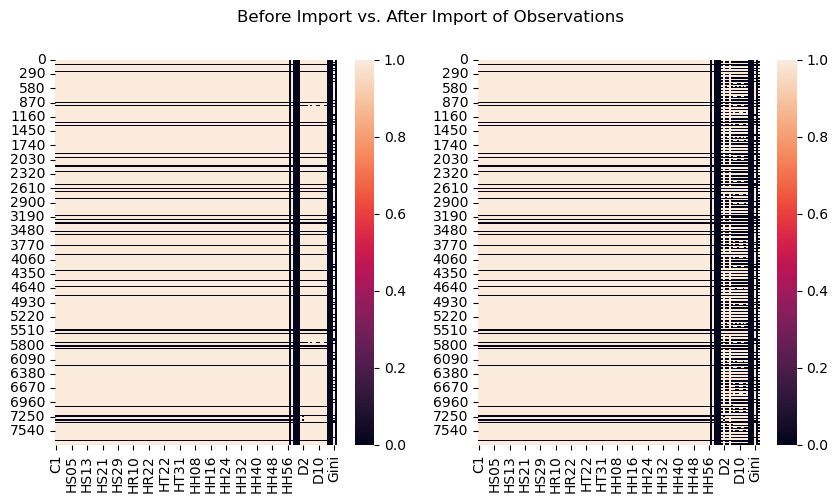

In [207]:
# Observe nulls. Most rows are null, no interpolation has occurred yet
df_merge3 = df_merge3.sort_values(by=['Country Code', 'Year'])

fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.heatmap(df_merge2.isnull(), ax=ax[0])
sns.heatmap(df_merge3.isnull(), ax=ax[1])
plt.suptitle("Before Import vs. After Import of Observations")
plt.show()


In [208]:
# fetch description of d_cols

old_cols = d_col_df['old_col'].tolist()
code_dict.loc[code_dict['Code'].isin(old_cols), ['Code','Description']]



,Code,Description
168,D1,Human development index
170,D3,Expected years of schooling
171,D4,Mean years of schooling
173,D6,Gross National Income per capita
174,D7,Human development index female
175,D8,Expected years of schooling female
176,D9,Mean years of schooling female
177,D10,Gross National Income per capita female
178,D11,Human development index male
179,D12,Expected years of schooling male


In [209]:
# clean up unneeded columns
df_merge3 = df_merge3.drop(columns=['Year_', 'iso3'])

Summary: 

Nulls have been eliminated in the following columns via importing observations from external data sources:

1. Population (P1) *note that imported data was rescaled by 1,000 to match left table scale
2. Fertility rate (P3)
3. Life expectancy (P4)
4. Life expectancy female (P5)
5. Life expectancy male (P6)
6. Human development index (D1)
7. Expected years of schooling (D3)
8. Mean years of schooling (D4)
9. Gross National Income per capita (D6)
9. Human development index female (D7)
10. Expected years of schooling female (D8)
11. Mean years of schooling female (D9)
12. Gross National Income per capita female (D10)
12. Human development index male (D11)
13. Expected years of schooling male (D12)
14. Mean years of schooling male (D13)
15. Gross National Income per capita male (D14)


#### df_mstr

In [210]:
# Create an imputation dataframe

df_mstr = df_merge3.copy()

In [211]:
df_merge3.shape

(7820, 145)

In [212]:
df_mstr.columns

Index(['C1', 'C2', 'C3', 'T1', 'HS01', 'HS02', 'HS03', 'HS04', 'HS05', 'HS06',
       ...
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'Country Name', 'Country Code',
       'Year', 'Gini'],
      dtype='object', length=145)

### Iterative Imputer

In the previous section, we imported thousands of observations in the 'D' (development) and 'P' (population) columns from external data sets provided by the United Nations Population Division and the United Nations Development Programme. 
- 'D' columns retrieved an average of 3,057 new observations per column.
- 'P' columns retrieved an 7,148 new observations per column.

To preserve an unaltered record of all merges, "master" dataframe, **df_mstr**. This table stores the combined results of all three merges without any material alterations. Any and all changes to the data pertained to **cleaning**, or **dropping of unused or duplicate columns** (see "Changes Log"). 

The following section uses "Iterative Imputer" to impute missing values on df_imputed, which begins as a copy of df_merge3/df_mstr. Note: the index for df_imputer is reset to reflect sorted order. Once imputation is performed, certain post-processing steps are applied. More detail is provided in the Iterative Imputer Summary section.

**Dropped Columns:** The following columns are dropped from df_mstr:


Duplicates from the merge:
- 'Year_' (duplicate of 'Year' created in merge)
- 'iso3' (duplicate of 'Country Code' created in merge)

Not needed for analysis:
- 'gdi' (Gross Domestic Income not needed for analysis)
- 'gdi_group' (GDI ranking not neede for analysis)
- 'C0', 'C4', 'T2', 'T3', 'T5', 'T10', 'S1', 'S2'(original CoRes columns not needed; see drop_cols_list)
    
**Filtered Columns:**
- df_merge1 involved dropping countries for any countries with fewer than two rows of core feature observations, fewer than two rows of Gini observation, and less than an 8-year timespan between Gini values. This filerting carries through to df_mstr

- df_imputed is created to store modified values created during imputation with Iterative Imputer. For ease of reference, feature column names in df_imputed will not be changed versus the original table. Where alterations to the target feature occur, a changed column name is used. 

To view native observation values, refer to df_mstr.

In [213]:
df_imputed = df_merge3.copy()

In [214]:
df_imputed

,C1,C2,C3,T1,HS01,HS02,HS03,HS04,HS05,HS06,...,D9,D10,D11,D12,D13,D14,Country Name,Country Code,Year,Gini
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1960,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1961,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1962,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1963,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Albania,ALB,1964,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.070020,1804.460974,0.580313,11.359176,9.462640,2551.748403,Zimbabwe,ZWE,2019,50.3
7816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.190793,1643.892266,0.572064,11.375836,9.590724,2262.626717,Zimbabwe,ZWE,2020,NaN
7817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.190793,1963.726056,0.559934,11.375836,9.590724,2150.173744,Zimbabwe,ZWE,2021,NaN
7818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.190793,1761.979860,0.568315,11.375836,9.590724,2433.257978,Zimbabwe,ZWE,2022,NaN


In [215]:
# Make sure the index is sequential prior to shuffling
df_imputed = df_imputed.sort_values(by=['Country Code', 'Year']).reset_index(drop=True)


<Axes: >

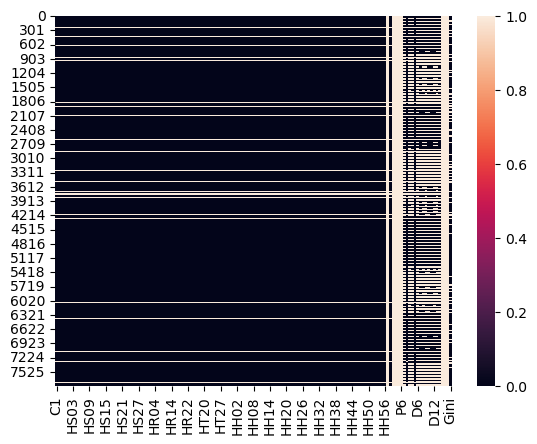

In [216]:
sns.heatmap(df_imputed.notnull())

In [217]:
# Vertical impuation groups

vertical_groups = [
    ('HH01','HH02'),
    ('HH03','HH13'),
    ('HH14','HH24'),
    ('HH25','HH30'),
    ('HH31','HH36'),
    ('HH37','HH38'),
    ('HH39','HH40'),
    ('HH41','HH42'),
    ('HH43','HH44'),
    ('HH45','HH46'),
    ('HH47','HH48'),
    ('HH49','HH50'),
    ('HH51','HH52'),
    ('HH53','HH54'),
    ('HH55','HH56'),
    ('HS01','HS11'),
    ('HS12','HS14'),
    ('HS15','HS16'),
    ('HS17','HS30'),
    ('HT20','HT25'),
    ('HT27','HT31'),
    ('HR02','HR05'),
    ('HR08','HR11'),
    ('HR14','HR17'),
    ('HR20','HR23'),
    ('HR26','HR29')
]

    #('HT01','HT09') dropped in HT section
    #('HT10','HT18') dropped in HT section
    
len(vertical_groups)

26

In [218]:
# define horizontal_group as columns not being imputed with iterative imputer
# exclude 'Year' (an index) and 'Gini' (the target) to avoid data leakage

horizontal_group = df_imputed.columns[df_imputed.columns.str.startswith(('P', 'D'))].tolist()
print(horizontal_group)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']


In [219]:
# create h_nulls_index to use when applying min_max scaling to average_groups imputations

h_nulls = df_imputed.loc[:, df_imputed.columns.str.startswith('H')].isnull().all(axis=1)

h_nulls_index = df_imputed.loc[h_nulls,:].index
h_nulls_index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7809, 7810, 7812, 7813, 7814, 7815, 7816, 7817, 7818, 7819],
           dtype='int64', length=7084)

In [220]:
# Iterative Imputer with default Bayesian Ridge used to impute missing h_cols
# list of unique countries

unique_countries = df_imputed['Country Code'].unique().tolist()

# for each country...
for country in unique_countries:
    
    # re-initialize imputer for each loop
    imputer = IterativeImputer(random_state=21, tol=1e-4, sample_posterior=True)
    
    # for each H column group
    for start, end in vertical_groups:
        
        # indicate rows for each country
        country_rows = df_imputed['Country Code'] == country

        # select informative columns for each country, create row index
        high_info_cols = df_imputed.loc[country_rows, horizontal_group].apply(lambda cols: cols.notnull().mean() > 0.6)
        high_info_col_index = high_info_cols[high_info_cols].index
        
        # concatenate imputation group per vertical group, high info column index
        country_block = pd.concat(
            [df_imputed.loc[country_rows, start:end], df_imputed.loc[country_rows, high_info_col_index]], axis = 1
        )
        
        country_block_col_index = country_block.columns
        country_block_row_index = country_block.index
                            
         # conduct imputation, prepare output for assignment
        imputed_data = imputer.fit_transform(country_block)
        imputed_vals_df = pd.DataFrame(imputed_data, columns=country_block_col_index, index=country_block_row_index)
        
        # assign imputed values back to df_imputed
        df_imputed.loc[country_rows, start:end] = imputed_vals_df.loc[country_rows, start:end]

# make a fresh copy of df_imputed to avoid downstream fragmentation warnings

df_imputed = df_imputed.copy()

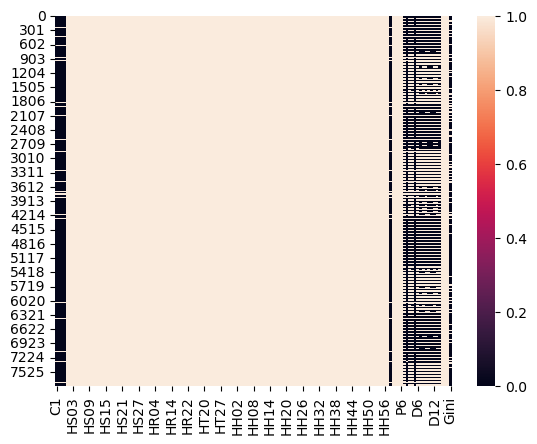

In [221]:
# Observe nulls heatmap

sns.heatmap(df_imputed.notnull())
plt.show()

In [222]:
# Some health checks for df_imputed

df_imputed.shape

(7820, 145)

In [223]:
# observe negative values

negative_mask = df_imputed.select_dtypes(include=['number'])<0

df_imputed.select_dtypes(include=['number']).loc[negative_mask.any(axis=1), negative_mask.any(axis=0)]

,HS01,HS02,HS03,HS04,HS05,HS06,HS07,HS08,HS09,HS10,...,HH47,HH48,HH49,HH50,HH51,HH52,HH53,HH54,HH55,HH56
0,0.471305,1.684304,0.516918,-0.227637,-0.607273,-0.515653,-0.252916,-0.127076,-0.067042,-0.064944,...,-5.368031,-5.379904,-1.376710,-2.177627,0.061572,0.295828,2.081289,-0.326338,-0.502648,-0.600375
1,0.428209,1.671936,0.544401,-0.265850,-0.635879,-0.515641,-0.224367,-0.151847,-0.054669,-0.112142,...,-5.071989,-5.122619,-1.246744,-2.153525,-0.023686,0.307839,2.167200,-0.203252,-0.468647,-0.632101
2,0.413560,1.591044,0.574846,-0.250974,-0.580157,-0.306710,-0.189492,-0.219067,-0.171411,-0.036782,...,-4.849228,-4.887589,-1.231075,-2.091093,0.055942,0.270030,2.135253,-0.239501,-0.352422,-0.468442
3,0.444811,1.487934,0.522088,-0.210577,-0.443446,-0.330659,-0.235922,-0.140976,0.028127,-0.024159,...,-4.584970,-4.569500,-1.115499,-1.889111,0.090243,0.243554,2.061081,-0.148746,-0.321044,-0.407215
4,0.382724,1.458506,0.449256,-0.196994,-0.476070,-0.395029,-0.202562,-0.135690,-0.119841,0.070082,...,-4.355496,-4.452735,-1.120272,-1.851167,0.080596,0.189565,2.089799,-0.125468,-0.222379,-0.332591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,0.190279,0.160221,0.204528,0.228537,0.199487,0.094514,0.014964,0.057968,-0.003963,0.004946,...,0.448492,0.377145,0.754085,0.965233,-0.004188,-0.007311,1.287833,0.232323,0.749940,1.206767
7816,0.199196,0.135341,0.204340,0.183300,0.160107,0.082344,-0.060604,0.041554,0.001299,-0.061590,...,2.279280,1.156584,0.637467,0.853365,0.026128,0.093360,1.254435,0.415339,0.865329,1.420593
7817,0.095781,0.202513,0.283986,0.245231,0.195736,0.079781,0.035421,-0.109439,-0.035675,0.030305,...,2.191446,1.017563,0.564987,1.564818,-0.003617,0.095930,1.220569,0.275202,1.073985,1.313195
7818,0.127363,0.159019,0.210768,0.358431,0.143829,0.046581,0.050137,0.132314,0.016051,-0.015303,...,1.758836,2.216668,0.758174,1.355852,0.156745,0.030613,1.227017,0.685901,0.789872,1.254513


In [224]:
# make all groups non-negative by shifting group by the absolute value of the most negative value

denegify_groups = vertical_groups

# define the start and end of column groupings to be shifted and normalized
for start, end in denegify_groups:
    subset = df_imputed.loc[:, start:end]
    row_mins = subset.min(axis=1)
    mask = row_mins<0
    df_imputed.loc[mask, start:end] += abs(row_mins[mask]).values.reshape(-1,1)
         

In [225]:
# Check to make sure all negative h_col negative values are gone

negative_mask = df_imputed.select_dtypes(include=['number'])<0

df_imputed.select_dtypes(include=['number']).loc[negative_mask.any(axis=1), negative_mask.any(axis=0)]

""


In [226]:
# manually denegify these rows as the add-to-one group was not comprised of sequential columns

min_val = df_imputed.loc[:, ['HS01', 'HS12', 'HS13', 'HS14']].min(axis=1)
min_val_mask = min_val < 0
df_imputed.loc[min_val_mask, ['HS01', 'HS12', 'HS13', 'HS14']] += abs(min_val[min_val_mask])



In [227]:
# Column groups to be shifted, normalized, and scaled as described above

add_to_one_groups = [('HH01','HH02'), 
                     ('HH03','HH13'), 
                     ('HH14','HH24'), 
                     ('HH25','HH30'), 
                     ('HH31','HH36'), 
                     ('HS01','HS11'),
                     ('HS15','HS15'),
                     ('HS16','HS16'),
                     ('HT20','HT25')]
#('HS01', 'HS12', 'HS14'), cannot be represented in (start:stop) syntax, to be normalized manually
#('HT01','HT09'), # dropped in HT section as a duplicate


average_groups = [('HS17','HS30'),
                ('HT27','HT31'),
                ('HR02','HR05'),
                ('HR08','HR11'),
                ('HR14','HR17'),
                ('HR20','HR23'),
                ('HR26','HR29'),
                  ('HH37','HH38'),
                  ('HH39','HH40'),
                  ('HH41','HH42'),
                  ('HH43','HH44'),
                  ('HH45','HH46'),
                  ('HH47','HH48'),
                  ('HH49','HH50'),
                  ('HH51','HH52'),
                  ('HH53','HH54'),
                  ('HH55','HH56')]
 
#('HT10','HT18'), 'HT26' #dropped in HT section as a duplicate

In [228]:
# Normalize add-to-one columns, now that denegification is complete
# Divide each column by the row sum for that group

for start, end in add_to_one_groups:
    row_sum = df_imputed.loc[:, start:end].sum(axis=1)
    df_imputed.loc[:, start:end] = df_imputed.loc[:, start:end].div(row_sum, axis=0)
    

In [229]:
# Check values manually

df_imputed.loc[:, start:end].sum(axis=1).value_counts()


1.0    4576
1.0    1683
1.0    1074
1.0     443
1.0      34
1.0       8
1.0       2
dtype: int64

In [230]:
# define a reasonable range for averages columns using pre-scaled min/max values from same columns
# not defining min/max per country to avoid introducing country bias
# use the pre-imputation ranges established from df_mstr to scale averages groups


# only applying scaling to rows that were imputed, which are captured in h_nulls_index

# (start, end, group_range)

for start, end in average_groups:
    mstr_group_max = df_mstr.loc[:, start:end].max().max()
    mstr_group_min = df_mstr.loc[:, start:end].min().min()
    
    print(f"Processing subset {start}:{end}. Group Min = {mstr_group_min}, Group Max = {mstr_group_max}")
    subset = df_imputed.loc[:, start:end]
    scaler = MinMaxScaler(feature_range=(mstr_group_min, mstr_group_max))
    
    scaled_data = scaler.fit_transform(subset)
    scaled_updates_df = pd.DataFrame(scaled_data, columns=subset.columns, index=df_imputed.index)

   
    # update each start, end pair
    df_imputed.loc[h_nulls_index, start:end] = scaled_updates_df.loc[h_nulls_index, subset.columns]
    



Processing subset HS17:HS30. Group Min = 0.0, Group Max = 9.54983888687221
Processing subset HT27:HT31. Group Min = 0.0, Group Max = 477.6
Processing subset HR02:HR05. Group Min = 0.0, Group Max = 5.02420950201352
Processing subset HR08:HR11. Group Min = 0.0, Group Max = 0.931478195072304
Processing subset HR14:HR17. Group Min = 0.0, Group Max = 1.66294227188082
Processing subset HR20:HR23. Group Min = 0.0, Group Max = 2.67810849735958
Processing subset HR26:HR29. Group Min = 0.0, Group Max = 3.68454172366621
Processing subset HH37:HH38. Group Min = 1.32910166630243, Group Max = 9.97776097300368
Processing subset HH39:HH40. Group Min = 0.145268625223178, Group Max = 5.04525032430489
Processing subset HH41:HH42. Group Min = 1.09134392963627, Group Max = 4.93251064869879
Processing subset HH43:HH44. Group Min = 0.0706499097347591, Group Max = 0.661996431479854
Processing subset HH45:HH46. Group Min = 0.0, Group Max = 1.37941007319329
Processing subset HH47:HH48. Group Min = 0.25977925661

In [231]:
# now that core features are scaled, use same to impute missing values in non-core features
# leverage unique_countries list from previous iterative imputer loop
# do not impute target yet

non_core_features = df_imputed.loc[:, df_imputed.columns.str.startswith(('D', 'P'))].columns
core_features = df_imputed.loc[:, df_imputed.columns.str.startswith('H')].columns
all_features = non_core_features.union(core_features)

for country in unique_countries:
    
    #initiate imputer
    imputer = IterativeImputer(random_state=21, tol=1e-3, sample_posterior=True)
    
    # initiate
    country_rows = df_imputed['Country Code']==country
    
    country_block = df_imputed.loc[country_rows, all_features]
    
    imputed_data = imputer.fit_transform(country_block)
    
    imputed_data_df = pd.DataFrame(imputed_data, columns=country_block.columns, index=country_block.index)
    
    df_imputed.loc[country_rows, non_core_features] = imputed_data_df.loc[:, non_core_features]
    
# # make a fresh copy to clear memory fragmentation issues downstream
# df_imputed = df_imputed.copy()

<Axes: >

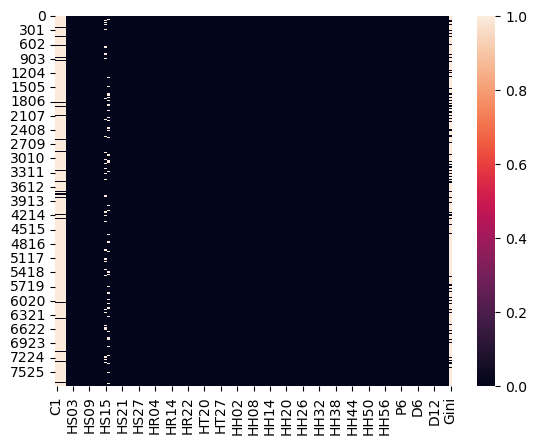

In [232]:
# Check missing values again
sns.heatmap(df_imputed.isnull())

In [233]:
# examine null values in d that keep breaking the loop

nulls_mask = df_imputed.loc[:, df_imputed.columns.isin(non_core_features)].isnull()

null_index = df_imputed.loc[:, df_imputed.columns.isin(non_core_features)].loc[nulls_mask.any(axis=1), nulls_mask.any(axis=0)].index

df_imputed.loc[null_index, :]

,C1,C2,C3,T1,HS01,HS02,HS03,HS04,HS05,HS06,...,D9,D10,D11,D12,D13,D14,Country Name,Country Code,Year,Gini


In [234]:
# percent of countries with more than two gini values
(df_imputed.groupby('Country Code')['Gini'].count()>4).mean()

0.8442622950819673

In [235]:
# use KNN to impute missing Gini values

updates = []

for country in unique_countries:
    imputer = KNNImputer(n_neighbors=2)
    country_rows = df_imputed['Country Code']==country
    country_block = df_imputed.loc[country_rows, ['Gini']]
    imputed_data = imputer.fit_transform(country_block)
    imputed_data_series = pd.Series(imputed_data.ravel(), index=country_block.index)
    updates.append(imputed_data_series)

updates = [item for sublist in updates for item in sublist]
df_imputed['Gini_knn'] = updates

In [236]:
# Backfill and forwardfill all remaining null values

df_imputed = df_imputed.groupby('Country Code', group_keys=False).apply(lambda group: group.bfill().ffill())

In [237]:
# split the data
X = df_imputed.drop(columns=['C1', 'C2', 'C3', 'T1', 'Country Name', 'Country Code', 'Year', 'Gini', 'Gini_knn'])
y = df_imputed['Gini_knn']

In [238]:
# models

results_df, trained_models = tscv_loop(X, y, 'imputed', 3)

Model Lasso requires scaling. Standard Scaler applied.
Model Lasso alpha is 0.001
Model Ridge requires scaling. Standard Scaler applied.
Model Ridge alpha is 0.1


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.562e+04, tolerance: 1.748e+01
  model = cd_fast.enet_coordinate_descent(
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.483e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.274e+04, tolerance: 2.688e+01
  model = cd_fast.enet_coordinate_descent(
/Users/lilianbur

In [239]:
# view results

results_df

,Fold,Dataset,Linear Regression Train Score,Linear Regression Test Score,Lasso Train Score,Lasso Test Score,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score
0,1,exploratory,0.807431,-1.129928,0.460003,0.711903,0.618340,0.647420,0.912739,0.719852
1,2,exploratory,0.789408,0.807142,0.647880,0.849672,0.736662,0.889681,0.955404,0.894450
2,3,exploratory,0.834503,0.778791,0.734382,0.852711,0.808055,0.884196,0.969668,0.871427
3,1,baseline,0.948447,-1.700506,0.871992,0.298582,0.876610,0.335915,0.996399,0.609845
4,2,baseline,0.800335,0.080635,0.752631,0.352040,0.764073,0.327086,0.994591,0.642871
5,3,baseline,0.744017,0.061401,0.700533,0.288440,0.711260,0.289586,0.994941,0.709607
6,1,imputed,0.498508,-1.527142,0.491011,-1.461664,0.497809,-1.466565,0.987895,-0.627979
7,2,imputed,0.404272,-0.104314,0.393692,-0.029398,0.404250,-0.099442,0.976594,0.200547
8,3,imputed,0.344941,0.207494,0.341089,0.205678,0.344935,0.207418,0.973487,0.303007


### Iterative Imputer Summary

Intermediary Note: 
- removed dataframe append calls in imputation and normalization loops
- applied min/max scaling only to imputed rows (seems to worsen model performance)
- should retry iterative imputer models without massaging step (tried this, and performance was improved, and/or revert back to min/max scaling across entire dataset

Feature Imputation

In Section III A we handled missing values with linear spline interpolation, which was simple and computationally low cost,  but may introduce excessive linear bias into the data. The goal of Section III B was to handle missing values in a more intelligent, robust way. In the final part of Section III, we will handle missing values using matrix decomposition methods.

In preparation for algorithmic imputation, additional observations for non-core features were imported from United Nations data (see Table 2 and Table 3). Non-core features columns in the CoResidence database start with 'D' (development indicators) or 'P' (population indicators). Once these additional rows were brought in, we leveraged these features to perform a more robust imputation of "core features" (columns starting with 'H', pertaining to household configuration).

- To impute missing values in the "core features" I chose Bayesian Ridge estimator inside of Iterative Imputer. ayesian Ridge assumes a prior distribution for model coefficients, which are updated as new data is encountered. The prior assumptions act as a regularization buffer, which accomodates modestly non-linear data and performs well on sparse, high dimensional data. In short, Bayesian Ridge is like a resilient and flexible linear regression.

- Within the loop that executes Iterative Imputer, I used a dynamic threshold of 60% sparsity per "informative column" for the supplemental columns assisting in imputation. In other words, for some countries, some reference columns were excluded.

- Once values were imputed, I normalized the results as follows:
    - Any and all negative values shifted
    - Add-to-one column groups scaled to add to one
    - Averages column groups scaled to min/max with a range defined by pre-scaled values for those columns
    
- After normalization, I turned around and imputed any missing P/D values using Iterative Imputer. While this appears to introduce circular imputation, the circle is interrupted in two ways: (1) Core features initially imputed started with at least two rows of real observations per country, which means that the initial imputation was anchored in something real; and (2) Normalizing the initial imputation output assumed that whatever essence was captured in the first round of imputation, once scaled, contains directional truth that may be more informative once scaled to proper magnitude.

Target Imputation
- Gaps in Gini values were imputed using Iterative Imputer with KNN estimator, to avoid coercing linearity. KNN Imputer was not used in the initial imputation step, because distance-based estimators are not robust to sparse data or high dimensional data. 84% of countries have at least 5 native Gini values, which should be enough to detect both linear non-linear patterns.

## C: Non-Negative Matrix Factorization

I wanted to handle missing values with at least one matrix decomposition method. Matrix decomposition captures global structure in the data, by breaking down the original data matrix into multiple interrelated matrices. The relationships between the underlying matrices reveal "latent features" or "components" that are essential properties of the data, which are not reducible to original features. In other words, data undergoes a "basis transformation" in which essential properties are revealed, which may transcend the original features.

Synthesizing missing values using interpolation and imputation relies heavily on row-wise relationships in the data, both when applying fitted models, and fitting those models. My data set is sparse, which means that it is missing a substantial amount of information. In addition to being sparse, it is high dimensional data, and potentially contains a lot of highly correlated features. Handling missing values piecewise in a low-information, high-dimensionality, and multicollinearity environment carries the risk of missing global patterns in the data.

I chose Non-Negative Matrix Factorization (NMF) over Truncated SVD or PCA because my data consists entirely of non-negative values (a requirement for NMF). Additionally, NMF provides greater interpretability by ensuring that each latent feature is a combination of additive contributions from the original features. In SVD or PCA methods, original features can be additive or subtractive relative latent components, which makes it difficult to interpret the aggregate essence of the latent component. 

NMF is slower, computationally, but better at preserving the objects we care about.


In [240]:
# create a copy of df_mstr to subject to SVD reconstruction

df_decompose = df_mstr.copy()

In [241]:
# sort values to maintain order of meaningful structure for purposes of decomposition

df_decompose = df_decompose.sort_values(by=['Country Code', 'Year'])

In [242]:
# drop unnecessary columns

df_decompose = df_decompose.drop(columns=['T1', 'C1', 'C2', 'C3'])

In [243]:
# knn impute gini values to prepare a y vector

unique_countries = df_decompose['Country Code'].unique().tolist()

country_blocks = []

for country in unique_countries:
    knn = KNNImputer(n_neighbors=2)
    country_block = df_decompose.loc[df_decompose['Country Code']==country, ['Gini']]
    country_block_imputed = knn.fit_transform(country_block)
    country_block_df = pd.DataFrame(country_block_imputed, columns=['Gini_knn'], index=country_block.index)
    country_blocks.append(country_block_df)

# concatenate each country block together
df_knn_gini = pd.concat(country_blocks)

# verify that indices match, prior to modelling
df_decompose.index.equals(df_knn_gini.index)


True

In [244]:
# drop target from df_decompose
df_decompose = df_decompose.drop('Gini', axis=1)

In [245]:
# fill null values with respective column means to prepare for nmf

df_filled = df_decompose.groupby('Country Code', group_keys=False).apply(lambda x: x.fillna(x.mean(numeric_only=True)))

In [246]:
# check that null values worked

null_mask = df_filled.isnull()
df_decompose.loc[df_filled.loc[null_mask.any(axis=1), null_mask.any(axis=0)].index]

,HS01,HS02,HS03,HS04,HS05,HS06,HS07,HS08,HS09,HS10,...,D8,D9,D10,D11,D12,D13,D14,Country Name,Country Code,Year


In [247]:
# now that values are filled, drop non-number columns prior to decomposition
df_filled = df_filled.drop(columns=['Country Name', 'Country Code', 'Year'])

In [248]:
# scale x for nmf

scaler = MinMaxScaler()

X_mm_scaled = scaler.fit_transform(df_filled)

# NMF Loop

In [249]:
# run NMF with varying component amounts
# initializing with a truncated svd to improve convergence

n_components_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

nmf_models = {}

for n_components in n_components_range:
    print(f"Running NMF for n_components={n_components}")
    nmf = NMF(n_components=n_components, max_iter=5000, random_state=21, tol=1e-3, init='nndsvda')
    W = nmf.fit_transform(X_mm_scaled)
    nmf_models[n_components] = W


Running NMF for n_components=10
Running NMF for n_components=20
Running NMF for n_components=30
Running NMF for n_components=40
Running NMF for n_components=50
Running NMF for n_components=60
Running NMF for n_components=70
Running NMF for n_components=80
Running NMF for n_components=90
Running NMF for n_components=100
Running NMF for n_components=110
Running NMF for n_components=120


In [250]:
# feed each W to models with GridSearchCV

best_parameters = []

for n_components, W in nmf_models.items():
    
    df_W = pd.DataFrame(W, columns=[f"LF{0+i}" for i in range(W.shape[1])], index=df_filled.index)
    df_W['n_components'] = n_components
    
    # bring back year, country code, and Gini_knn columns
    df_W['Year'] = df_decompose['Year']
    df_W['Country Code'] = df_decompose['Country Code']
    df_W['Gini_knn'] = df_knn_gini['Gini_knn']
    
    # shuffle country data to prepare for modeling
    W_shuffled = df_W.sample(frac=1)
    
    # sort by year
    W_sorted = W_shuffled.sort_values(by='Year', ascending=True)

    X = W_sorted.drop(columns=['Year', 'Country Code', 'Gini_knn'])
    y = W_sorted['Gini_knn']
    
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(),
        'Ridge': Ridge(),
        'Random Forest' : RandomForestRegressor(random_state=21),
        'Gradient Boost': GradientBoostingRegressor(random_state=21)
             }
    
    for model_name, model in models.items():
        tscv = TimeSeriesSplit(n_splits=3)
        
        if isinstance(model, Lasso):
            param_grid = {'alpha':[0.001, 0.01, 0.1, 1, 10],
                         'max_iter':[10000]}
            grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
            grid_search.fit(X, y)
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
        
        elif isinstance(model, Ridge):
            param_grid = {'alpha':[0.1, 1, 5, 10, 50],
                         'max_iter':[10000]}
            grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
            grid_search.fit(X, y)
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            
        else:
            best_params = {}
            best_score = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error').mean()

            
        best_parameters.append({
                'n_components':n_components,
                'model_name':model_name,
                'best_params':best_params,
                'best_score':best_score
            })
            

In [251]:
# Compare parameters

best_parameters_df = pd.DataFrame(best_parameters)

best_parameters_df

,n_components,model_name,best_params,best_score
0,10,Linear Regression,{},-31.275877
1,10,Lasso,"{'alpha': 0.01, 'max_iter': 10000}",-31.286170
2,10,Ridge,"{'alpha': 0.1, 'max_iter': 10000}",-31.276777
3,10,Random Forest,{},-10.919302
4,10,Gradient Boost,{},-12.604746
5,20,Linear Regression,{},-29.731412
6,20,Lasso,"{'alpha': 0.001, 'max_iter': 10000}",-29.104270
7,20,Ridge,"{'alpha': 0.1, 'max_iter': 10000}",-29.498523
8,20,Random Forest,{},-10.324770
9,20,Gradient Boost,{},-10.366253


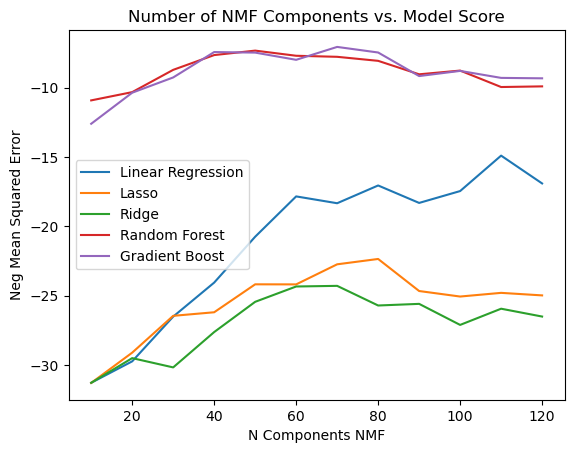

In [252]:
# visualize results

plt.figure()

for model_name in best_parameters_df['model_name'].unique():
    plot_df = best_parameters_df.loc[best_parameters_df['model_name']==model_name]
    plt.plot(plot_df['n_components'], plot_df['best_score'], label=model_name)

plt.legend()
plt.ylabel('Neg Mean Squared Error')
plt.xlabel('N Components NMF')
plt.title('Number of NMF Components vs. Model Score')
plt.show()
                              

In [253]:
# start fresh from df_decompose
df_decompose.index.equals(df_filled.index)
df_filled.index.equals(df_knn_gini.index)

True

In [254]:
# now run nmf again with optimal n_components

nmf = NMF(n_components=110, max_iter=5000, random_state=21, tol=1e-3, init='nndsvda')
W_optimal = nmf.fit_transform(X_mm_scaled)
W_optimal_df = pd.DataFrame(W_optimal, columns=[f"LF{i+1}" for i in range(W_optimal.shape[1])], index=df_filled.index)

In [255]:
# shuffle then sort by year

W_optimal_df['Year'] = df_decompose['Year']
W_optimal_df['Country Code'] = df_decompose['Country Code']
W_optimal_df['Country Name'] = df_decompose['Country Name']
W_optimal_df['Gini_knn'] = df_knn_gini['Gini_knn']

W_opt_shuffled = W_optimal_df.sample(frac=1)
W_opt_sorted = W_opt_shuffled.sort_values(by='Year')
W_opt_sorted.head()

,LF1,LF2,LF3,LF4,LF5,LF6,LF7,LF8,LF9,LF10,...,LF105,LF106,LF107,LF108,LF109,LF110,Year,Country Code,Country Name,Gini_knn
3270,0.016798,0.086917,0.000000,0.002313,0.000478,0.011557,0.000000,0.005863,0.015128,0.001918,...,0.045018,0.000000,0.021746,0.009016,0.322178,0.000000,1960,IRL,Ireland,32.772000
3782,0.022034,0.000000,0.015532,0.001785,0.031405,0.000000,0.003266,0.001009,0.000000,0.006047,...,0.042966,0.137424,0.015114,0.063270,0.227601,0.175252,1960,KGZ,Kyrgyz Republic,29.977273
4550,0.016502,0.022090,0.003962,0.005220,0.005433,0.006047,0.002858,0.008075,0.000000,0.001133,...,0.268610,0.158802,0.000955,0.181483,0.088757,0.147482,1960,MEX,Mexico,49.666667
320,0.000000,0.000109,0.005670,0.003825,0.000532,0.000000,0.008091,0.001880,0.004961,0.006114,...,0.000000,0.336477,0.000000,0.325961,0.038347,0.095200,1960,BDI,Burundi,37.020000
4999,0.025508,0.003157,0.000000,0.000492,0.010059,0.000351,0.000000,0.004662,0.006236,0.000463,...,0.225881,0.039952,0.000000,0.000000,0.163926,0.083067,1960,MUS,Mauritius,37.000000


In [256]:
# then run tscv_loop on output of nmf with optimal components
# first need to shuffle and sort W again

X = W_opt_sorted.drop(columns=['Year', 'Country Code', 'Country Name', 'Gini_knn'])
y = W_opt_sorted['Gini_knn']

results, trained_models = tscv_loop(X, y, 'nmf', 3, scaling=False)

In [257]:
results

,Fold,Dataset,Linear Regression Train Score,Linear Regression Test Score,Lasso Train Score,Lasso Test Score,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score
0,1,exploratory,0.807431,-1.129928,0.460003,0.711903,0.618340,0.647420,0.912739,0.719852
1,2,exploratory,0.789408,0.807142,0.647880,0.849672,0.736662,0.889681,0.955404,0.894450
2,3,exploratory,0.834503,0.778791,0.734382,0.852711,0.808055,0.884196,0.969668,0.871427
3,1,baseline,0.948447,-1.700506,0.871992,0.298582,0.876610,0.335915,0.996399,0.609845
4,2,baseline,0.800335,0.080635,0.752631,0.352040,0.764073,0.327086,0.994591,0.642871
5,3,baseline,0.744017,0.061401,0.700533,0.288440,0.711260,0.289586,0.994941,0.709607
6,1,imputed,0.498508,-1.527142,0.491011,-1.461664,0.497809,-1.466565,0.987895,-0.627979
7,2,imputed,0.404272,-0.104314,0.393692,-0.029398,0.404250,-0.099442,0.976594,0.200547
8,3,imputed,0.344941,0.207494,0.341089,0.205678,0.344935,0.207418,0.973487,0.303007
9,1,nmf,0.906063,0.827583,0.698201,0.675062,0.662648,0.637770,0.997351,0.876690


# Section IV - Model Comparisons and Conclusions

In [258]:
# feed interpolated data to NMF

X_imputed = df_imputed.drop(columns=['C1', 'C2', 'C3', 'T1', 'Country Name', 'Country Code', 'Year', 'Gini', 'Gini_knn'])
scaler = MinMaxScaler()

X_imputed
X_imputed_scaled = scaler.fit_transform(X_imputed)

nmf_hybrid = NMF(n_components=110, max_iter=5000, random_state=21, tol=1e-3, init='nndsvda')
W_hybrid = nmf_hybrid.fit_transform(X_imputed_scaled)

W_hybrid_df = pd.DataFrame(W_hybrid, index=X_imputed.index, columns=[f"LF{0+i}" for i in range(W_hybrid.shape[1])])
W_hybrid_df['Year'] = df_imputed['Year']
W_hybrid_df['Country Code'] = df_imputed['Country Code']
W_hybrid_df['Country Name'] = df_imputed['Country Name']
W_hybrid_df['Gini_knn'] = df_imputed['Gini_knn']

#Shuffle
W_hybrid_df = W_hybrid_df.sample(frac=1)

#Sort
W_hybrid_df = W_hybrid_df.sort_values(by='Year')

#Split
X_hybrid = W_hybrid_df.drop(columns=['Country Name', 'Country Code', 'Year', 'Gini_knn'])
y_hybrid = W_hybrid_df['Gini_knn']

#Test
results, models = tscv_loop(X_hybrid, y_hybrid, 'NMF hybrid', 3, scaling=True)

Model Lasso requires scaling. Standard Scaler applied.
Model Lasso alpha is 0.001
Model Ridge requires scaling. Standard Scaler applied.
Model Ridge alpha is 0.1


In [259]:
results

,Fold,Dataset,Linear Regression Train Score,Linear Regression Test Score,Lasso Train Score,Lasso Test Score,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score
0,1,exploratory,0.807431,-1.129928,0.460003,0.711903,0.618340,0.647420,0.912739,0.719852
1,2,exploratory,0.789408,0.807142,0.647880,0.849672,0.736662,0.889681,0.955404,0.894450
2,3,exploratory,0.834503,0.778791,0.734382,0.852711,0.808055,0.884196,0.969668,0.871427
3,1,baseline,0.948447,-1.700506,0.871992,0.298582,0.876610,0.335915,0.996399,0.609845
4,2,baseline,0.800335,0.080635,0.752631,0.352040,0.764073,0.327086,0.994591,0.642871
5,3,baseline,0.744017,0.061401,0.700533,0.288440,0.711260,0.289586,0.994941,0.709607
6,1,imputed,0.498508,-1.527142,0.491011,-1.461664,0.497809,-1.466565,0.987895,-0.627979
7,2,imputed,0.404272,-0.104314,0.393692,-0.029398,0.404250,-0.099442,0.976594,0.200547
8,3,imputed,0.344941,0.207494,0.341089,0.205678,0.344935,0.207418,0.973487,0.303007
9,1,nmf,0.906063,0.827583,0.698201,0.675062,0.662648,0.637770,0.997351,0.876690


In [260]:
# svd

# scale the data
scaler = StandardScaler()
X_ss_scaled = scaler.fit_transform(df_filled)

svd_models = {}
singular_values_dict = {}

for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components, random_state=21)
    U = svd.fit_transform(X_ss_scaled)
    svd_models[n_components] = U
    singular_values_dict[n_components] = svd.singular_values_

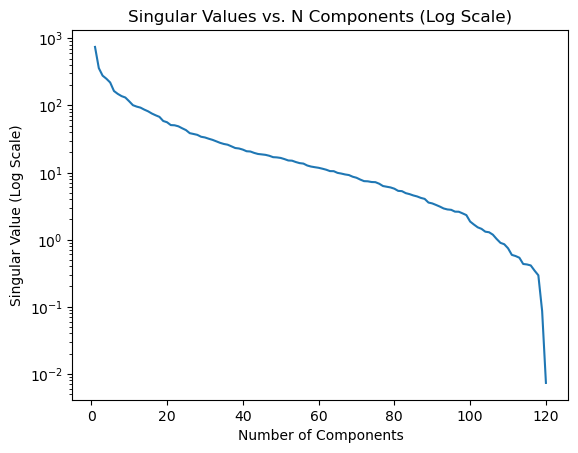

In [261]:
plt.figure()

x = list(range(1, max(singular_values_dict.keys())+1))
y = singular_values_dict[max(x)]

plt.plot(x, y)
plt.yscale('log')
plt.xlabel('Number of Components')
plt.ylabel('Singular Value (Log Scale)')
plt.title("Singular Values vs. N Components (Log Scale)")
plt.show()

In [262]:
# feed the different U versions to different models

svd_best_parameters = []

for n_components, U in svd_models.items():
    df_U = pd.DataFrame(U, index=df_filled.index, columns=[f"SV{i+1}" for i in range(U.shape[1])])
    df_U['n_components'] = n_components
    
    # shuffle
    df_U['Year'] = df_decompose['Year']
    df_U['Country Code'] = df_decompose['Country Code']
    df_U['Country Name'] = df_decompose['Country Name']
    df_U['Gini_knn'] = df_knn_gini['Gini_knn']
    
    df_U = df_U.sample(frac=1)

    # sort
    df_U.sort_values(by='Year')
    
    # split
    X = df_U.drop(columns=['Year', 'Country Code', 'Country Name', 'Gini_knn'])
    y = df_U['Gini_knn']
    
    # feed to models
    
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(),
        'Ridge': Ridge(),
        'Random Forest' : RandomForestRegressor(random_state=21),
        'Gradient Boost': GradientBoostingRegressor(random_state=21)
             }
    
    for model_name, model in models.items():
        tscv = TimeSeriesSplit(n_splits=3)
        
        if isinstance(model, Lasso):
            param_grid = {'alpha':[0.001, 0.01, 0.1, 1, 10],
                         'max_iter':[10000]}
            grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
            grid_search.fit(X, y)
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
        
        elif isinstance(model, Ridge):
            param_grid = {'alpha':[0.1, 1, 5, 10, 50],
                         'max_iter':[10000]}
            grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
            grid_search.fit(X, y)
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            
        else:
            best_params = {}
            best_score = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error').mean()

            
        svd_best_parameters.append({
                'n_components':n_components,
                'model_name':model_name,
                'best_params':best_params,
                'best_score':best_score
            })


In [266]:
# inspect parameter values
svd_params_df = pd.DataFrame(svd_best_parameters)
svd_params_df

,n_components,model_name,best_params,best_score
0,10,Linear Regression,{},-33.021662
1,10,Lasso,"{'alpha': 0.1, 'max_iter': 10000}",-33.001580
2,10,Ridge,"{'alpha': 50, 'max_iter': 10000}",-33.019463
3,10,Random Forest,{},-4.149624
4,10,Gradient Boost,{},-7.977535
5,20,Linear Regression,{},-28.567463
6,20,Lasso,"{'alpha': 0.01, 'max_iter': 10000}",-28.552878
7,20,Ridge,"{'alpha': 50, 'max_iter': 10000}",-28.541869
8,20,Random Forest,{},-3.592108
9,20,Gradient Boost,{},-6.722630


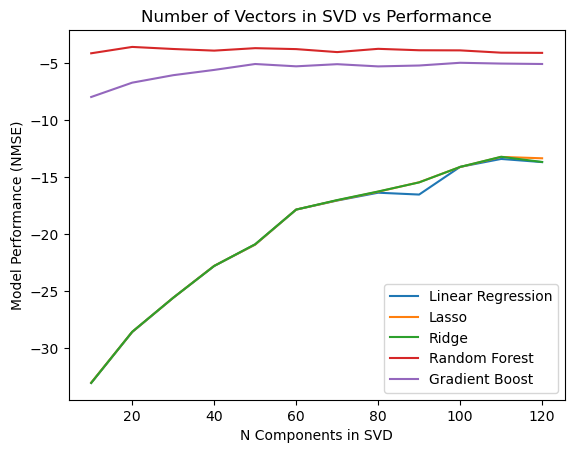

In [267]:
# plot

for model in svd_params_df['model_name'].unique():
    x = svd_params_df.loc[svd_params_df['model_name']==model, 'n_components']
    y = svd_params_df.loc[svd_params_df['model_name']==model, 'best_score']
    plt.plot(x, y, label=model)

plt.legend()
plt.xlabel('N Components in SVD')
plt.ylabel('Model Performance (NMSE)')
plt.title('Number of Vectors in SVD vs Performance')
plt.show()

In [268]:
# perform final svd with optimal number of components equal to 110

scaler = StandardScaler()
X_ss_scaled = scaler.fit_transform(df_filled)

svd = TruncatedSVD(n_components=110, random_state=21)
U = svd.fit_transform(X_ss_scaled)

df_U = pd.DataFrame(U, columns=[f"SV{i+1}" for i in range(U.shape[1])], index=df_filled.index)

# add back columns

df_U['Year'] = df_decompose['Year']
df_U['Country Code'] = df_decompose['Country Code']
df_U['Country Name'] = df_decompose['Country Name']
df_U['Gini_knn'] = df_knn_gini['Gini_knn']

# shuffle

df_U = df_U.sample(frac=1)

# sort

df_U = df_U.sort_values(by='Year')

df_U

# split

X = df_U.drop(columns=['Year', 'Country Code', 'Country Name', 'Gini_knn'])
y = df_U['Gini_knn']

# feed to models

results, models = tscv_loop(X, y, 'svd', 3, scaling=False)

In [270]:
results

,Fold,Dataset,Linear Regression Train Score,Linear Regression Test Score,Lasso Train Score,Lasso Test Score,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score
0,1,exploratory,0.807431,-1.129928,0.460003,0.711903,0.618340,0.647420,0.912739,0.719852
1,2,exploratory,0.789408,0.807142,0.647880,0.849672,0.736662,0.889681,0.955404,0.894450
2,3,exploratory,0.834503,0.778791,0.734382,0.852711,0.808055,0.884196,0.969668,0.871427
3,1,baseline,0.948447,-1.700506,0.871992,0.298582,0.876610,0.335915,0.996399,0.609845
4,2,baseline,0.800335,0.080635,0.752631,0.352040,0.764073,0.327086,0.994591,0.642871
5,3,baseline,0.744017,0.061401,0.700533,0.288440,0.711260,0.289586,0.994941,0.709607
6,1,imputed,0.498508,-1.527142,0.491011,-1.461664,0.497809,-1.466565,0.987895,-0.627979
7,2,imputed,0.404272,-0.104314,0.393692,-0.029398,0.404250,-0.099442,0.976594,0.200547
8,3,imputed,0.344941,0.207494,0.341089,0.205678,0.344935,0.207418,0.973487,0.303007
9,1,nmf,0.906063,0.827583,0.698201,0.675062,0.662648,0.637770,0.997351,0.876690


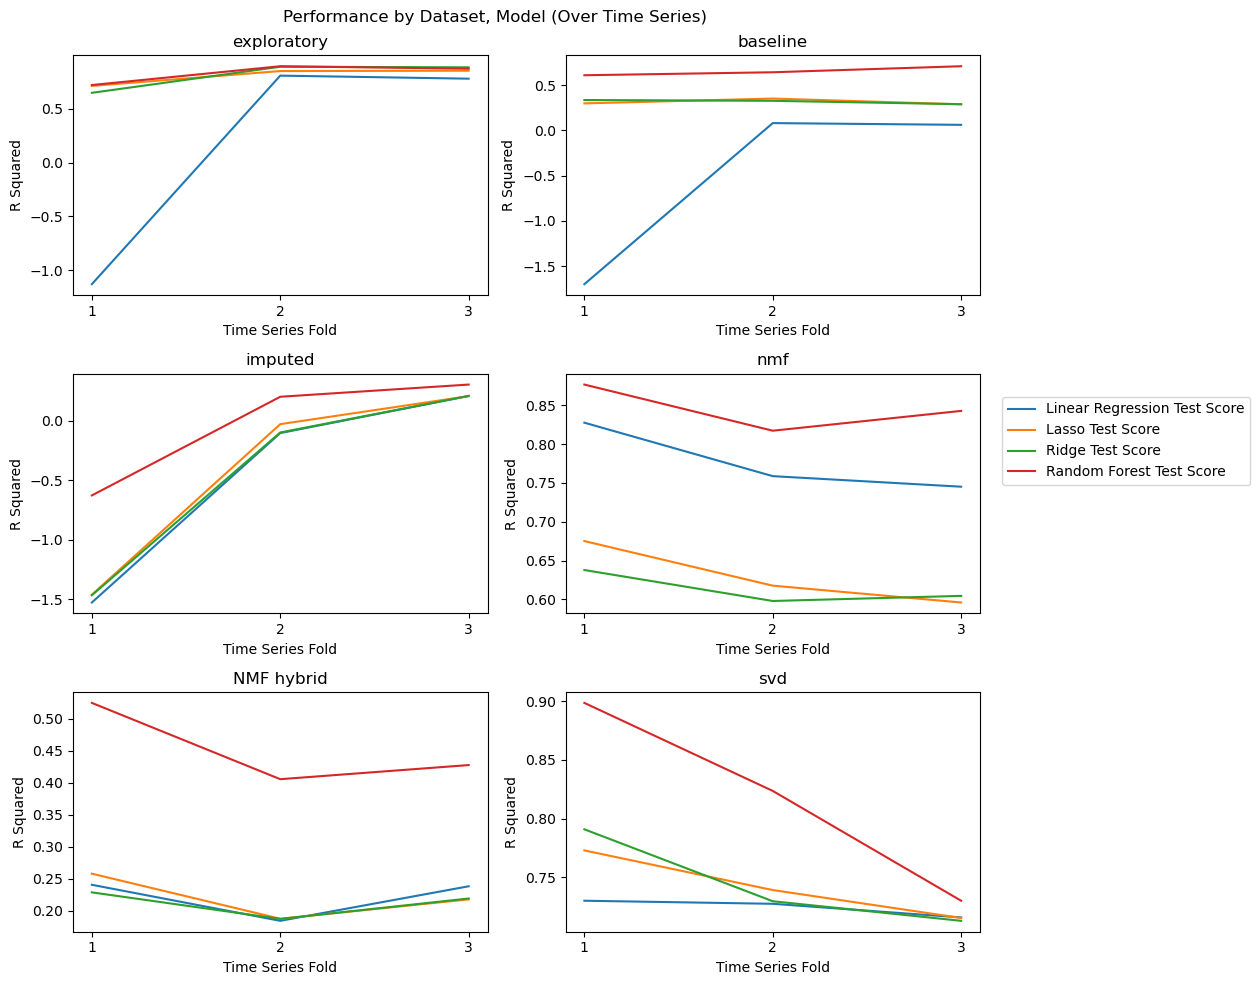

In [366]:
# plot test performance

unique_datasets = results['Dataset'].unique()
unique_models = results.columns[results.columns.str.contains("Test")]

n_rows = (len(unique_datasets)+1)//2
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))

for i, dataset in enumerate(unique_datasets):
    row = i//n_cols
    column = i%n_cols
    for model in unique_models:
        folds = results.loc[results['Dataset']==dataset, 'Fold']
        test_scores = results.loc[results['Dataset']==dataset, model]
        ax[row, column].plot(folds, test_scores, label=model)
        ax[row, column].set_ylabel('R Squared')
        ax[row, column].set_xlabel('Time Series Fold')
        ax[row, column].set_xticks(range(1, max(folds)+1))
        ax[row, column].set_title(dataset)
    
fig.legend(unique_models, loc='upper left', bbox_to_anchor=(1,0.60))
plt.suptitle("Performance by Dataset, Model (Over Time Series)")
plt.tight_layout()

In [ ]:
# x-axis HDI, y-axis Gini

In [ ]:
# incorporate grid search in tscv loop

In [ ]:
# collect all scores